# Hierarchical

In [2]:
# imports

import pandas as pd
import numpy as np
from math import pi
from math import ceil, floor
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import random
import joblib
from tqdm import tqdm
import re
from IPython.display import clear_output
import mapply
mapply.init(n_workers=7, progressbar=True)
from scipy.spatial.distance import pdist, squareform
from scipy.stats import mode
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import AgglomerativeClustering

/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# utils

cat_cols = ['date_month', 'date_day', 'date_year', 'congressional_district', 'state',
            'incident_characteristics1', 'city_or_county', 'party']

orig_num_cols = ['latitude', 'longitude', 'min_age_participants', 'avg_age_participants',
        'max_age_participants', 'n_participants_child', 'n_participants_teen',
        'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured',
        'n_arrested', 'n_unharmed', 'n_participants',
        'povertyPercentage', 'candidatevotes', 'totalvotes']

K_MIN = 2
K_MAX = 20

OUTLIERS_REM = 'remove_outliers_iqr'
#OUTLIERS_REM = 'flag'
#SCALER = 'std'
SCALER = 'minmax'

MODEL_NAMES = ['Original Model', 'Augmented Model', 'Indicators Model', 'Original Reduced Model', 'Augmented Reduced Model', 'Indicators Reduced Model']

def remove_outliers_iqr(data, column, threshold=1.5):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]


def prepare(df, scaler='std', with_original=True, with_indicators=True):
    df.loc[:, cat_cols] = df.loc[:, cat_cols].astype('object')
    numerical_df = df.select_dtypes(include=['int64', 'float64'])

    if not with_indicators:
        if not with_original:
            return None
        numerical_df = numerical_df[orig_num_cols]
    elif not with_original:
        numerical_df = numerical_df[[col for col in numerical_df.columns if col not in orig_num_cols]]

    if scaler == 'minmax':
        scaler = MinMaxScaler()
    else:
        scaler = StandardScaler()
        
    numerical_scaled = scaler.fit_transform(numerical_df.values)
    numerical_scaled = pd.DataFrame(numerical_scaled, columns=numerical_df.columns)

    return numerical_df, numerical_scaled, scaler


def features_reduction_corr(df, correlation_threshold=0.7):
    # Compute the correlation matrix
    correlation_matrix = df.corr()

    # Identify highly correlated features
    highly_correlated_features = set()

    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
                colname = correlation_matrix.columns[i]
                highly_correlated_features.add(colname)

    # Remove highly correlated features
    df_filtered = df.drop(columns=highly_correlated_features)
    return df_filtered


def features_reduction_var(df, variance_threshold=2):
    # Compute the variance of each feature
    feature_variances = df.var()

    # Identify features below the variance threshold
    low_variance_features = feature_variances[feature_variances < variance_threshold].index

    # Prune (remove) features below the threshold
    df_pruned = df.drop(columns=low_variance_features)

    return df_pruned


def perform_PCA(df, centroids=None, n_components=2):
    pca = PCA(n_components=n_components)

    points_pca = pca.fit_transform(df)
    if centroids is not None:
        centroids_pca = pca.transform(centroids)
        return points_pca, centroids_pca
    return points_pca


def generate_random_df(stats_df, sample_size=1):
    columns = stats_df['Attribute'].tolist()
    random_row = {}
    for j in tqdm(range(len(columns))):
        col = columns[j]
        to_sample_from = stats_df[stats_df['Attribute'] == col]
        if to_sample_from['Possible Values'][j] is not None:
            random_row[col] = np.random.choice(to_sample_from['Possible Values'][j], size=sample_size)
        else:
            random_row[col] = np.random.uniform(to_sample_from['Min Value'][j], to_sample_from['Max Value'][j], size=sample_size)
    random_df = pd.DataFrame(random_row)
    return random_df


def augment(df):
    # from data cleaning ----------------------------------------------------------------------------------
    augmented_participants = df.copy()

    PREFIX = lambda c: f'p_{c[2:]}'

    participants_cols = ['n_males', 'n_females', 'n_participants_child', 'n_participants_teen', 'n_participants_adult', 'n_killed', 'n_injured', 'n_arrested', 'n_unharmed']

    # indicators

    # Age Change wrt the mean in the same (month, congressional_district)
    for col in participants_cols:
        augmented_participants[PREFIX(col)] = augmented_participants[col] / augmented_participants['n_participants']

    augmented_age = augmented_participants.copy()
    PREFIX = lambda cs: [f'month_cd_change_{c}' for c in cs]

    augmented_age = augmented_age.set_index(['date_year', 'date_month', 'state', 'congressional_district'])
    augmented_age = augmented_age.sort_index()

    cols = ['min_age_participants', 'avg_age_participants', 'max_age_participants']
    mean_val = augmented_age.groupby(augmented_age.index.names)[cols].mean()
    augmented_age[PREFIX(cols)] = augmented_age[cols] - mean_val

    augmented_age = augmented_age.reset_index()

    # Age Change wrt the mean in the same (month, state)
    PREFIX = lambda cs: [f'year_state_change_{c}' for c in cs]

    augmented_age = augmented_age.set_index(['date_year', 'state'])
    augmented_age = augmented_age.sort_index()

    cols = ['min_age_participants', 'avg_age_participants', 'max_age_participants']
    mean_val = augmented_age.groupby(augmented_age.index.names)[cols].mean()
    augmented_age[PREFIX(cols)] = augmented_age[cols] - mean_val

    augmented_age = augmented_age.reset_index()


    # Number of participants wrt the sum in that (month, congressional_district)
    augmented_p_ratio = augmented_age.copy()
    PREFIX = lambda cs: [f'month_cd_ratio_{c[2:]}' for c in cs]

    new_params = [p + '_ratio' for p in participants_cols]

    augmented_p_ratio = augmented_p_ratio.set_index(['date_year', 'date_month', 'state', 'congressional_district'])
    augmented_p_ratio = augmented_p_ratio.sort_index()
    sums = augmented_p_ratio.groupby(augmented_p_ratio.index.names)[participants_cols].sum()

    augmented_p_ratio[PREFIX(participants_cols)] = augmented_p_ratio[participants_cols].div(sums, axis=0)
    augmented_p_ratio = augmented_p_ratio.reset_index()

    # Number of participants wrt the sum in that (month, state)
    PREFIX = lambda cs: [f'year_state_ratio_{c[2:]}' for c in cs]

    new_params = [p + '_ratio' for p in participants_cols]

    augmented_p_ratio = augmented_p_ratio.set_index(['date_year', 'state'])
    augmented_p_ratio = augmented_p_ratio.sort_index()
    sums = augmented_p_ratio.groupby(augmented_p_ratio.index.names)[participants_cols].sum()

    augmented_p_ratio[PREFIX(participants_cols)] = augmented_p_ratio[participants_cols].div(sums, axis=0)
    augmented_p_ratio = augmented_p_ratio.reset_index()

    # Replace NaNs (0/0) with 0
    augmented_p_ratio = augmented_p_ratio.fillna(0)

    augmented_incidents = augmented_p_ratio.copy()
    PREFIX = lambda _: 'month_cd_incidents'

    augmented_incidents = augmented_incidents.set_index(['date_year', 'date_month', 'state', 'congressional_district'])
    augmented_incidents = augmented_incidents.sort_index()
    augmented_incidents['month_cd_incidents'] = augmented_incidents.groupby(augmented_incidents.index.names).size()
    augmented_incidents['month_cd_votes_incidents'] = augmented_incidents['month_cd_incidents'] / augmented_incidents['totalvotes']

    augmented_incidents = augmented_incidents.reset_index()

    augmented_incidents = augmented_incidents.set_index(['date_year', 'state'])
    augmented_incidents = augmented_incidents.sort_index()
    augmented_incidents['year_state_incidents'] = augmented_incidents.groupby(augmented_incidents.index.names).size()

    augmented_incidents = augmented_incidents.reset_index()

    augmented_population = augmented_incidents.copy()

    votes = df.copy()
    votes = votes[['date_year', 'state', 'congressional_district', 'totalvotes']]
    votes = votes.set_index(['date_year', 'state', 'congressional_district'])
    votes = votes.sort_index()

    state_votes = votes.groupby(['date_year', 'state']).sum()

    augmented_population = augmented_population.set_index(['date_year', 'state', 'congressional_district'])
    augmented_population = augmented_population.sort_index()

    cd_population = augmented_population['totalvotes'] * augmented_population['state_population'] // state_votes['totalvotes']
    cd_population.dropna(inplace=True)

    augmented_population['cd_population'] = cd_population

    augmented_population = augmented_population.reset_index()

    augmented_party = augmented_population.copy()

    REP_df = augmented_party[augmented_party['party'] == 'REPUBLICAN'].copy()
    DEM_df = augmented_party[augmented_party['party'] == 'DEMOCRAT'].copy()
    REP_df['percentage_republican'] = REP_df['candidatevotes'] / REP_df['totalvotes']
    REP_df['percentage_democrat'] = 1 - (REP_df['candidatevotes'] / REP_df['totalvotes'])
    DEM_df['percentage_democrat'] = DEM_df['candidatevotes'] / DEM_df['totalvotes']
    DEM_df['percentage_republican'] = 1 - (DEM_df['candidatevotes'] / DEM_df['totalvotes'])
    augmented_party = pd.concat([REP_df, DEM_df], ignore_index=True).reset_index(drop=True).sample(frac=1)

    regex = re.compile('[^a-zA-Z0-9]')
    def rename(s):
        return regex.sub('_', s)

    k = 4

    augmented_charateristics = augmented_party.copy()

    vc = augmented_charateristics['incident_characteristics1'].value_counts()
    most_common = vc.head(k).index.tolist()

    augmented_charateristics = augmented_charateristics.set_index(['date_year', 'date_month', 'state', 'congressional_district', 'incident_characteristics1'])
    augmented_charateristics = augmented_charateristics.sort_index()
    something = augmented_charateristics.groupby(['date_year', 'date_month', 'state', 'congressional_district', 'incident_characteristics1']).size()
    morething = augmented_charateristics.groupby(['date_year', 'date_month', 'state', 'congressional_district']).size()

    # create a column for each of the k most common incident_characteristics1 plus a column for the others
    for c in most_common:
        nc = rename(c)
        nc = 'cd_month_' + nc
        perc_state_month = something.xs(c, level='incident_characteristics1') / morething
        perc_state_month.fillna(0, inplace=True)
        augmented_charateristics[nc] = perc_state_month
    nc = 'cd_month_OTHER'
    perc_state_month = 1 - augmented_charateristics[['cd_month_' + rename(c) for c in most_common]].sum(axis=1)
    augmented_charateristics[nc] = perc_state_month

    augmented_charateristics = augmented_charateristics.reset_index()

    augmented_charateristics = augmented_charateristics.set_index(['date_year', 'state', 'incident_characteristics1'])
    augmented_charateristics = augmented_charateristics.sort_index()
    something = augmented_charateristics.groupby(['date_year', 'state', 'incident_characteristics1']).size()
    morething = augmented_charateristics.groupby(['date_year', 'state']).size()

    # create a column for each of the k most common incident_characteristics1 plus a column for the others
    for c in most_common:
        nc = rename(c)
        nc = 'state_year_' + nc
        perc_state_month = something.xs(c, level='incident_characteristics1') / morething
        perc_state_month.fillna(0, inplace=True)
        augmented_charateristics[nc] = perc_state_month
    nc = 'state_year_OTHER'
    perc_state_month = 1 - augmented_charateristics[['state_year_' + rename(c) for c in most_common]].sum(axis=1)
    augmented_charateristics[nc] = perc_state_month

    df = augmented_charateristics.reset_index()
    
    return df

---
## Preparing datasets

In [4]:
df_init = pd.read_csv('./dataset/data/final_clean2.csv')
df_init = df_init[df_init['state'] == 'CALIFORNIA']

if OUTLIERS_REM == 'flag':
    df_init = df_init[df_init['OUTLIER'] == 0]
else:
    for col in orig_num_cols:
        df_init = remove_outliers_iqr(df_init, col)

cols = cat_cols + orig_num_cols + ['state_population', 'timestamp']
df_init = df_init[cols]
df_init = augment(df_init)
#-------------------------------------------------------------------

summary_stats = pd.DataFrame({
    'Unique Values': df_init.nunique(),
    'Max Value': df_init.max(),
    'Min Value': df_init.min()
})
summary_stats['Possible Values'] = df_init.apply(lambda col: col.unique() if col.nunique() <= 8000 else None)
summary_stats = summary_stats.reset_index().rename(columns={'index': 'Attribute'})

random_df_init = generate_random_df(stats_df=summary_stats, sample_size=len(df_init.values))
random_df_init = augment(random_df_init)

100%|██████████| 77/77 [00:00<00:00, 1995.28it/s]


### Actual data

Dataset dimentions: (6026, 77)
Dataset dimentions without ouliers, with only numerical cols, without indicators: (6026, 18)
Dataset dimentions without ouliers, with only numerical cols, with indicators: (6026, 69)
Dataset dimentions without ouliers, with only numerical cols, only indicators: (6026, 51)


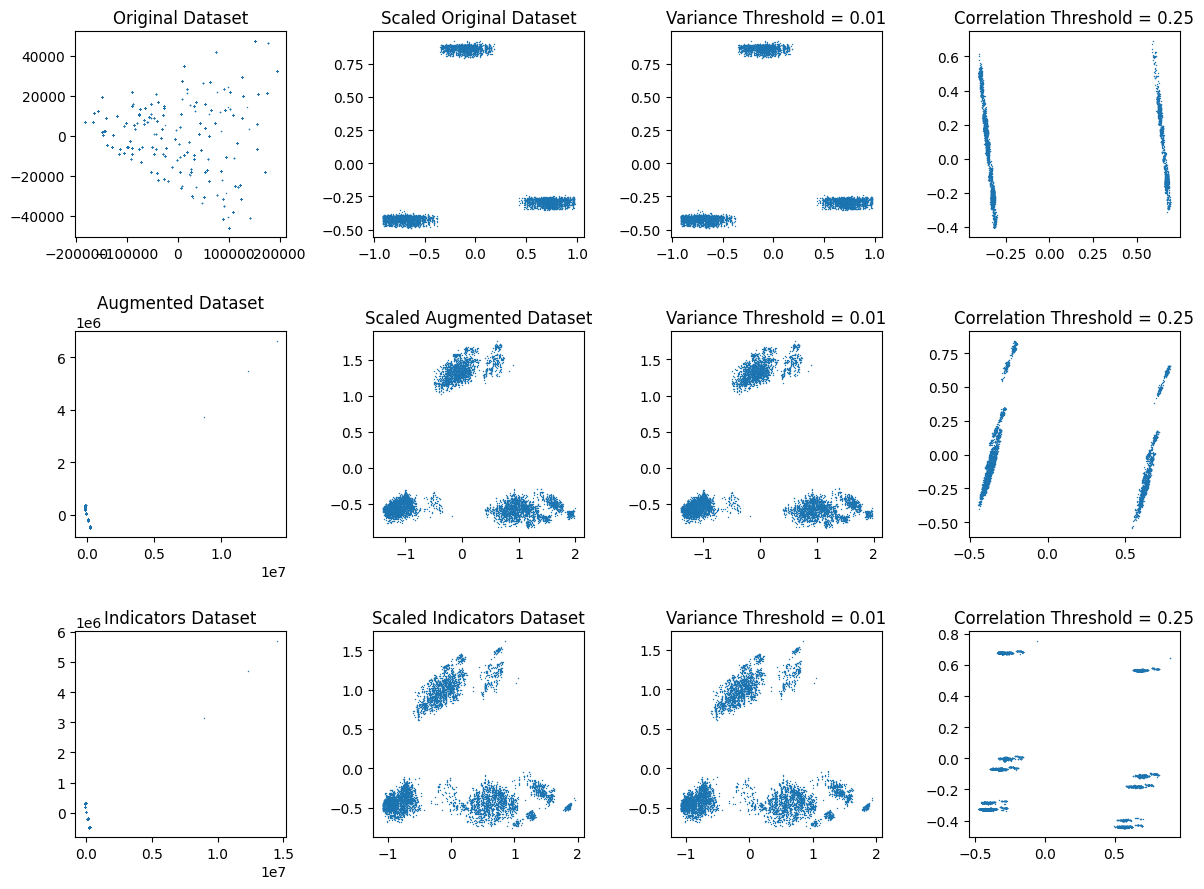

Original Dataset

Initial n_cols = 18

Survived columns (variance_threshold = 0.01):----------------------------------------------
n_cols = 11
Index(['latitude', 'longitude', 'min_age_participants', 'avg_age_participants',
       'max_age_participants', 'n_killed', 'n_injured', 'n_arrested',
       'povertyPercentage', 'candidatevotes', 'totalvotes'],
      dtype='object')

Survived columns (correlation_threshold = 0.25):----------------------------------------------
n_cols = 3
Index(['latitude', 'min_age_participants', 'n_killed'], dtype='object')

Augmented Dataset

Initial n_cols = 69

Survived columns (variance_threshold = 0.01):----------------------------------------------
n_cols = 43
Index(['latitude', 'longitude', 'min_age_participants', 'avg_age_participants',
       'max_age_participants', 'n_killed', 'n_injured', 'n_arrested',
       'povertyPercentage', 'candidatevotes', 'totalvotes', 'state_population',
       'timestamp', 'p_killed', 'p_injured', 'p_arrested',
       'mon

In [5]:
df_orig, df_orig_s, scaler_orig = prepare(df=df_init, scaler=SCALER, with_indicators=False, with_original=True)
df, df_s, scaler = prepare(df=df_init, scaler=SCALER, with_indicators=True, with_original=True)
df_ind, df_ind_s, scaler_ind = prepare(df=df_init, scaler=SCALER, with_indicators=True, with_original=False)

print(f'Dataset dimentions: {df_init.shape}')
print(f'Dataset dimentions without ouliers, with only numerical cols, without indicators: {df_orig.shape}')
print(f'Dataset dimentions without ouliers, with only numerical cols, with indicators: {df.shape}')
print(f'Dataset dimentions without ouliers, with only numerical cols, only indicators: {df_ind.shape}')

dataframes = [df_orig, df, df_ind]
scaled_dataframes = [df_orig_s, df_s, df_ind_s]
scalers = [scaler_orig, scaler, scaler_ind]
titles = ['Original Dataset', 'Augmented Dataset', 'Indicators Dataset']
N = len(dataframes)

if SCALER == 'minmax':
    var_thr = 0.01
    corr_thr = 0.25
else:
    var_thr = 1
    corr_thr = 0.25

reduced1s = []
reduced2s = []

for ds in scaled_dataframes:
    rs1 = features_reduction_var(ds, variance_threshold=var_thr)
    rs2 = features_reduction_corr(rs1, correlation_threshold=corr_thr)
    reduced1s.append(rs1)
    reduced2s.append(rs2)

scaled_dataframes = scaled_dataframes + reduced2s
dataframes = dataframes*2
scalers = scalers*2

plt.figure(figsize=(12, 9))

for d, ds, rs1, rs2, t, i in zip(dataframes, scaled_dataframes, reduced1s, reduced2s, titles, np.arange(1, N*4, 4)):

    pca = perform_PCA(df=d, n_components=2)
    pca_s = perform_PCA(df=ds, n_components=2)
    pca_rs1 = perform_PCA(df=rs1, n_components=2)
    pca_rs2 = perform_PCA(df=rs2, n_components=2)

    plt.subplot(3, 4, i)
    plt.scatter(pca[:, 0], pca[:, 1], s=1, edgecolors='black', linewidths=0.001)
    plt.title(t)

    plt.subplot(3, 4, i+1)
    plt.scatter(pca_s[:, 0], pca_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
    plt.title(f'Scaled {t}')

    plt.subplot(3, 4, i+2)
    plt.scatter(pca_rs1[:, 0], pca_rs1[:, 1], s=1, edgecolors='black', linewidths=0.001)
    plt.title(f'Variance Threshold = {var_thr}')

    plt.subplot(3, 4, i+3)
    plt.scatter(pca_rs2[:, 0], pca_rs2[:, 1], s=1, edgecolors='black', linewidths=0.001)
    plt.title(f'Correlation Threshold = {corr_thr}')

plt.tight_layout()
plt.show()

for ds, rs1, rs2, t in zip(scaled_dataframes, reduced1s, reduced2s, titles):
    print(f'{t}\n\nInitial n_cols = {ds.shape[1]}')
    print(f'\nSurvived columns (variance_threshold = {var_thr}):----------------------------------------------')
    print(f'n_cols = {len(rs1.columns)}')
    print(rs1.columns)

    print(f'\nSurvived columns (correlation_threshold = {corr_thr}):----------------------------------------------')
    print(f'n_cols = {len(rs2.columns)}')
    print(f'{rs2.columns}\n')

### Random data

Dataset dimentions: (6026, 83)
Dataset dimentions without ouliers, with only numerical cols, without indicators: (6026, 18)
Dataset dimentions without ouliers, with only numerical cols, with indicators: (6026, 75)
Dataset dimentions without ouliers, with only numerical cols, only indicators: (6026, 57)


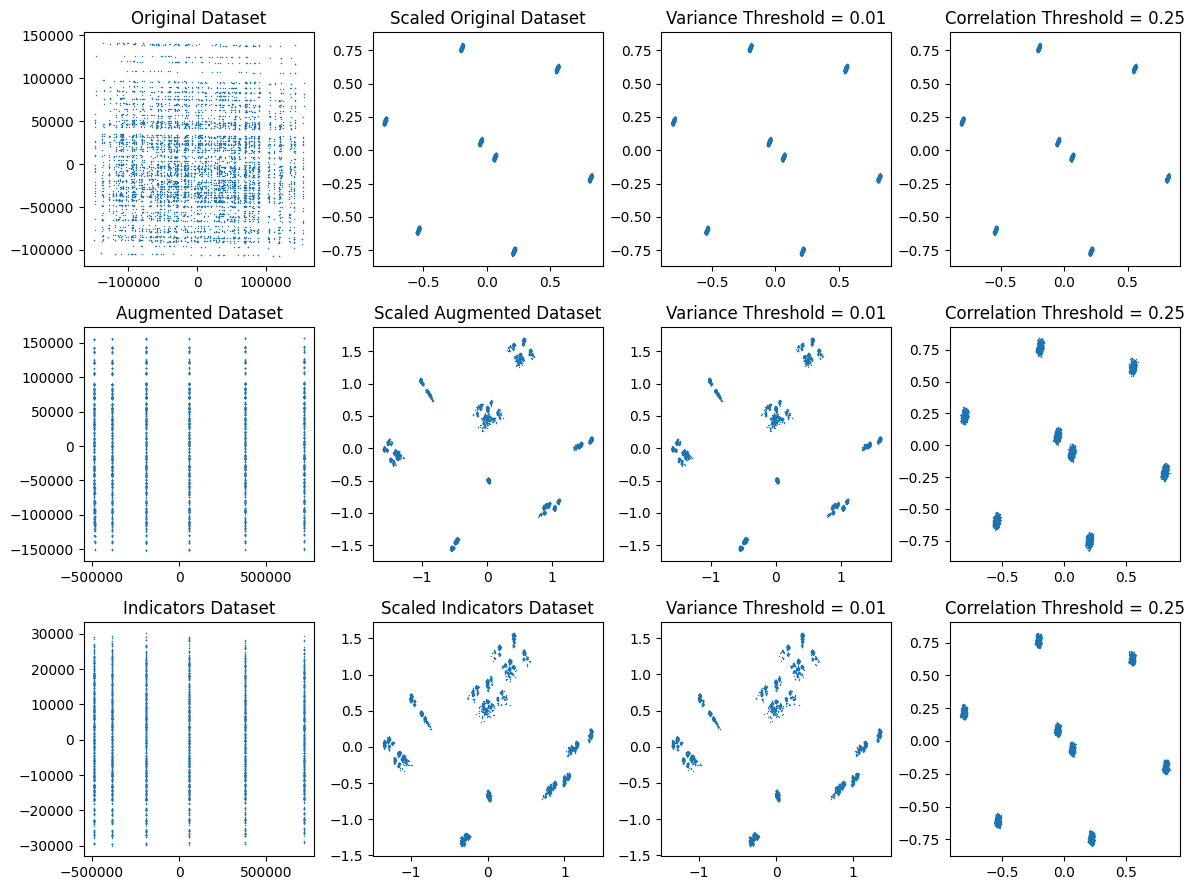

Original Dataset

Initial n_cols = 18

Survived columns (variance_threshold = 0.01):----------------------------------------------
n_cols = 11
Index(['latitude', 'longitude', 'min_age_participants', 'avg_age_participants',
       'max_age_participants', 'n_killed', 'n_injured', 'n_arrested',
       'povertyPercentage', 'candidatevotes', 'totalvotes'],
      dtype='object')

Survived columns (correlation_threshold = 0.25):----------------------------------------------
n_cols = 11
Index(['latitude', 'longitude', 'min_age_participants', 'avg_age_participants',
       'max_age_participants', 'n_killed', 'n_injured', 'n_arrested',
       'povertyPercentage', 'candidatevotes', 'totalvotes'],
      dtype='object')

Augmented Dataset

Initial n_cols = 75

Survived columns (variance_threshold = 0.01):----------------------------------------------
n_cols = 51
Index(['latitude', 'longitude', 'min_age_participants', 'avg_age_participants',
       'max_age_participants', 'n_killed', 'n_injured', 'n

In [6]:
random_df_orig, random_df_orig_s, random_scaler_orig = prepare(df=random_df_init, scaler=SCALER, with_indicators=False, with_original=True)
random_df, random_df_s, random_scaler = prepare(df=random_df_init, scaler=SCALER, with_indicators=True, with_original=True)
random_df_ind, random_df_ind_s, random_scaler_ind = prepare(df=random_df_init, scaler=SCALER, with_indicators=True, with_original=False)

print(f'Dataset dimentions: {random_df_init.shape}')
print(f'Dataset dimentions without ouliers, with only numerical cols, without indicators: {random_df_orig.shape}')
print(f'Dataset dimentions without ouliers, with only numerical cols, with indicators: {random_df.shape}')
print(f'Dataset dimentions without ouliers, with only numerical cols, only indicators: {random_df_ind.shape}')

random_dataframes = [random_df_orig, random_df, random_df_ind]
random_scaled_dataframes = [random_df_orig_s, random_df_s, random_df_ind_s]
random_scalers = [random_scaler_orig, random_scaler, random_scaler_ind]
titles = ['Original Dataset', 'Augmented Dataset', 'Indicators Dataset']
N = len(random_dataframes)

if SCALER == 'minmax':
    var_thr = 0.01
    corr_thr = 0.25
else:
    var_thr = 1
    corr_thr = 0.25

reduced1s = []
reduced2s = []

for ds in random_scaled_dataframes:
    rs1 = features_reduction_var(ds, variance_threshold=var_thr)
    rs2 = features_reduction_corr(rs1, correlation_threshold=corr_thr)
    reduced1s.append(rs1)
    reduced2s.append(rs2)

random_scaled_dataframes = random_scaled_dataframes + reduced2s
random_dataframes = random_dataframes*2
random_scalers = random_scalers*2

plt.figure(figsize=(12, 9))

for d, ds, rs1, rs2, t, i in zip(random_dataframes, random_scaled_dataframes, reduced1s, reduced2s, titles, np.arange(1, N*4, 4)):

    pca = perform_PCA(df=d, n_components=2)
    pca_s = perform_PCA(df=ds, n_components=2)
    pca_rs1 = perform_PCA(df=rs1, n_components=2)
    pca_rs2 = perform_PCA(df=rs2, n_components=2)

    plt.subplot(3, 4, i)
    plt.scatter(pca[:, 0], pca[:, 1], s=1, edgecolors='black', linewidths=0.001)
    plt.title(t)

    plt.subplot(3, 4, i+1)
    plt.scatter(pca_s[:, 0], pca_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
    plt.title(f'Scaled {t}')

    plt.subplot(3, 4, i+2)
    plt.scatter(pca_rs1[:, 0], pca_rs1[:, 1], s=1, edgecolors='black', linewidths=0.001)
    plt.title(f'Variance Threshold = {var_thr}')

    plt.subplot(3, 4, i+3)
    plt.scatter(pca_rs2[:, 0], pca_rs2[:, 1], s=1, edgecolors='black', linewidths=0.001)
    plt.title(f'Correlation Threshold = {corr_thr}')

plt.tight_layout()
plt.show()

for ds, rs1, rs2, t in zip(random_scaled_dataframes, reduced1s, reduced2s, titles):
    print(f'{t}\n\nInitial n_cols = {ds.shape[1]}')
    print(f'\nSurvived columns (variance_threshold = {var_thr}):----------------------------------------------')
    print(f'n_cols = {len(rs1.columns)}')
    print(rs1.columns)

    print(f'\nSurvived columns (correlation_threshold = {corr_thr}):----------------------------------------------')
    print(f'n_cols = {len(rs2.columns)}')
    print(f'{rs2.columns}\n')

---
## Performing agglomerative hierarchical clustering with the various methods

single linkage: 100%|██████████| 12/12 [00:08<00:00,  1.50it/s]


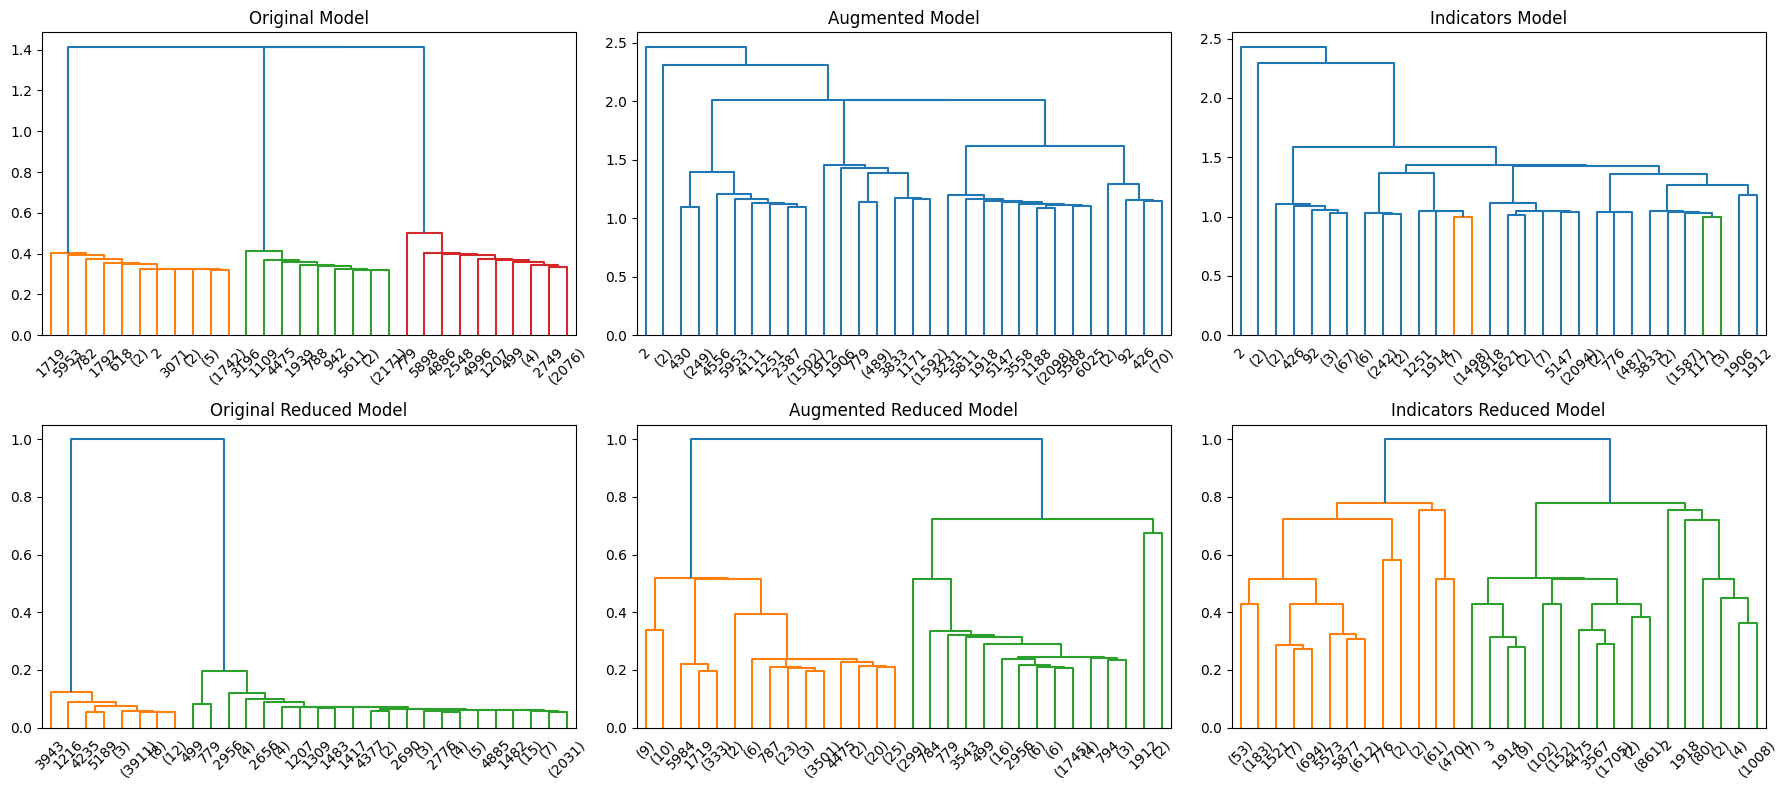

complete linkage: 100%|██████████| 12/12 [00:16<00:00,  1.35s/it]


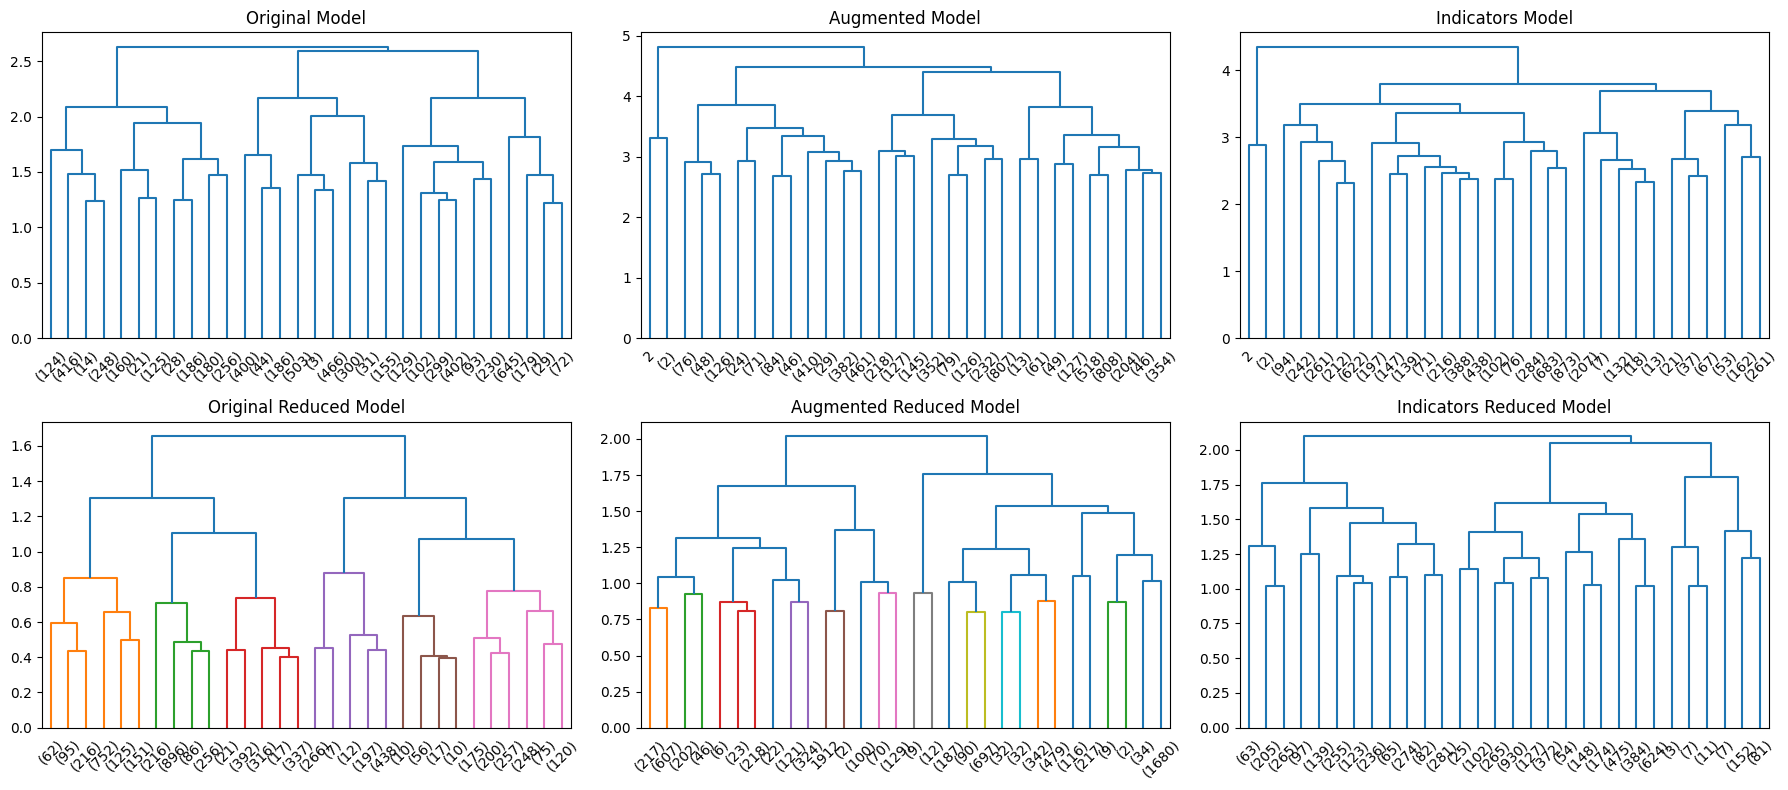

ward linkage: 100%|██████████| 12/12 [00:17<00:00,  1.45s/it]


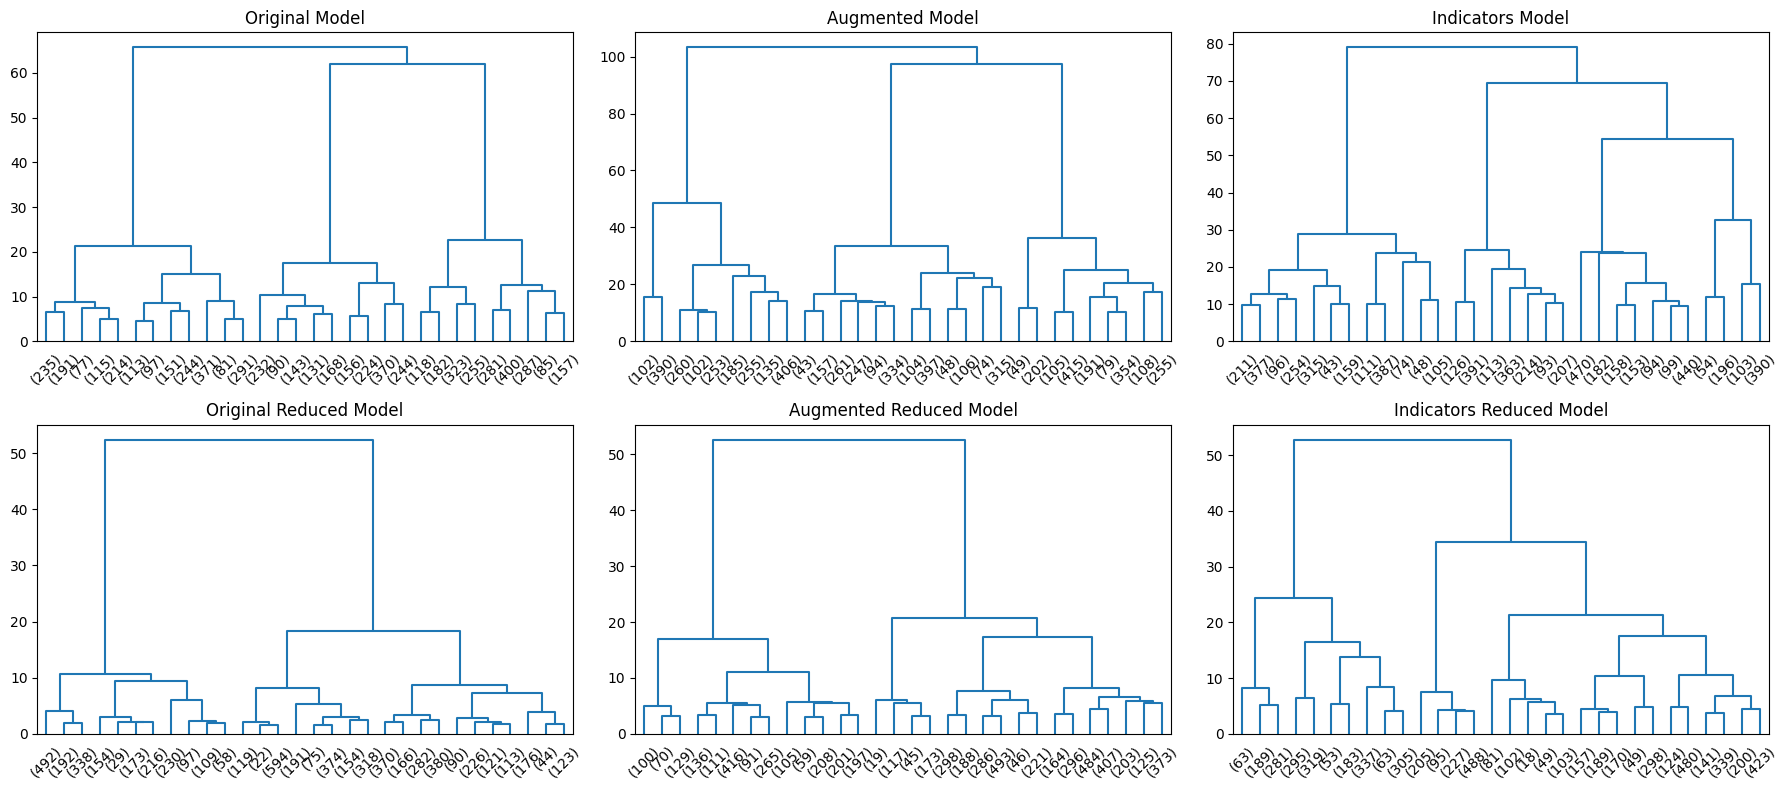

average linkage: 100%|██████████| 12/12 [00:17<00:00,  1.43s/it]


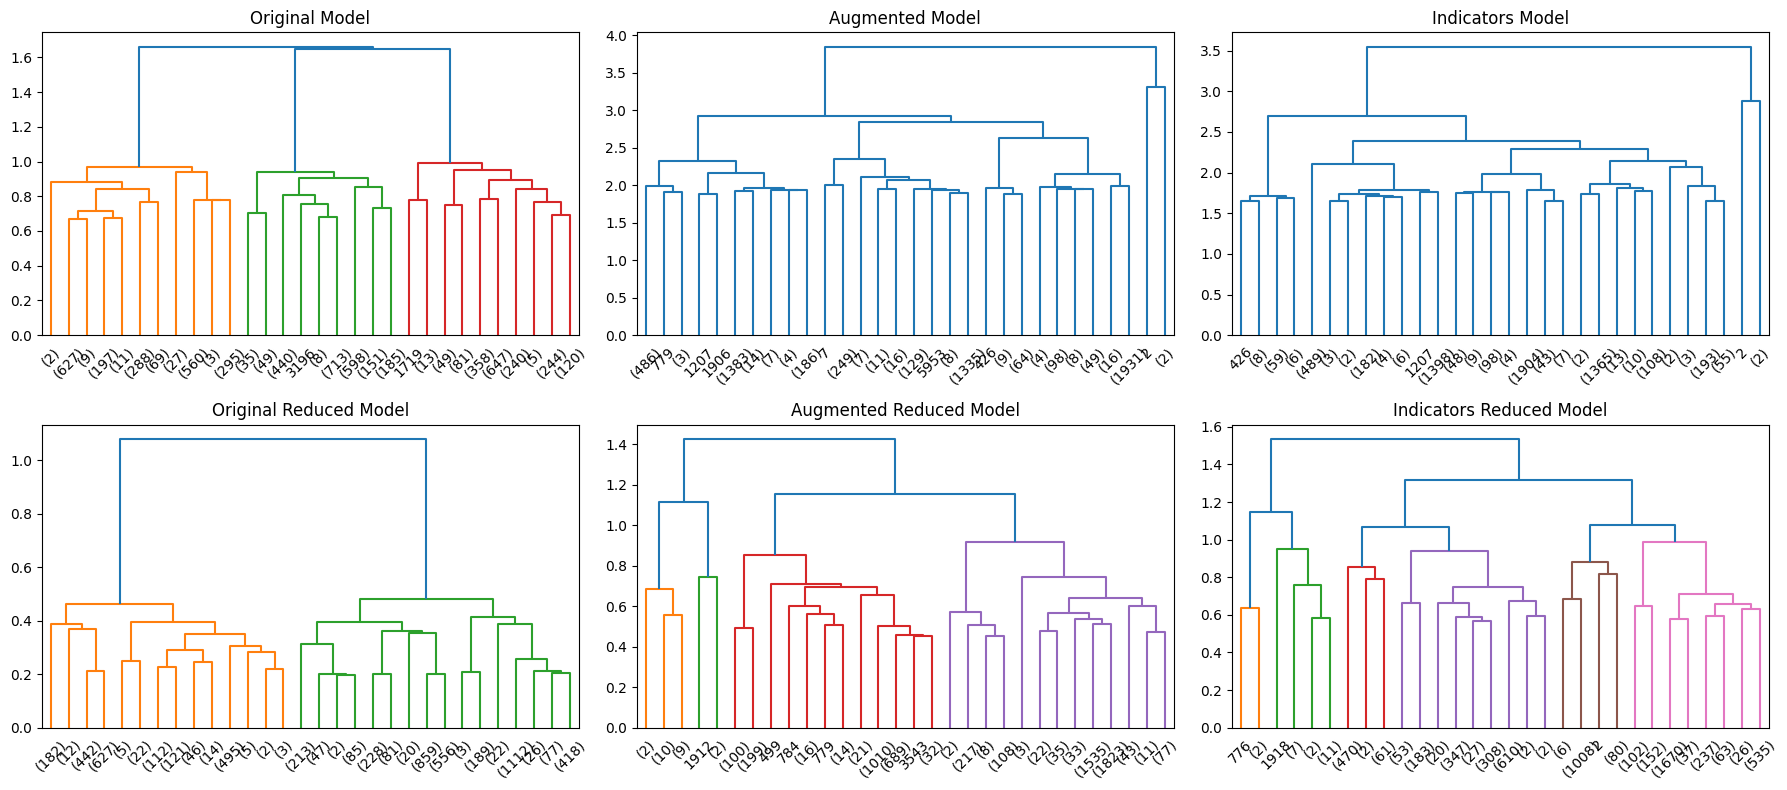

weighted linkage: 100%|██████████| 12/12 [00:17<00:00,  1.44s/it]


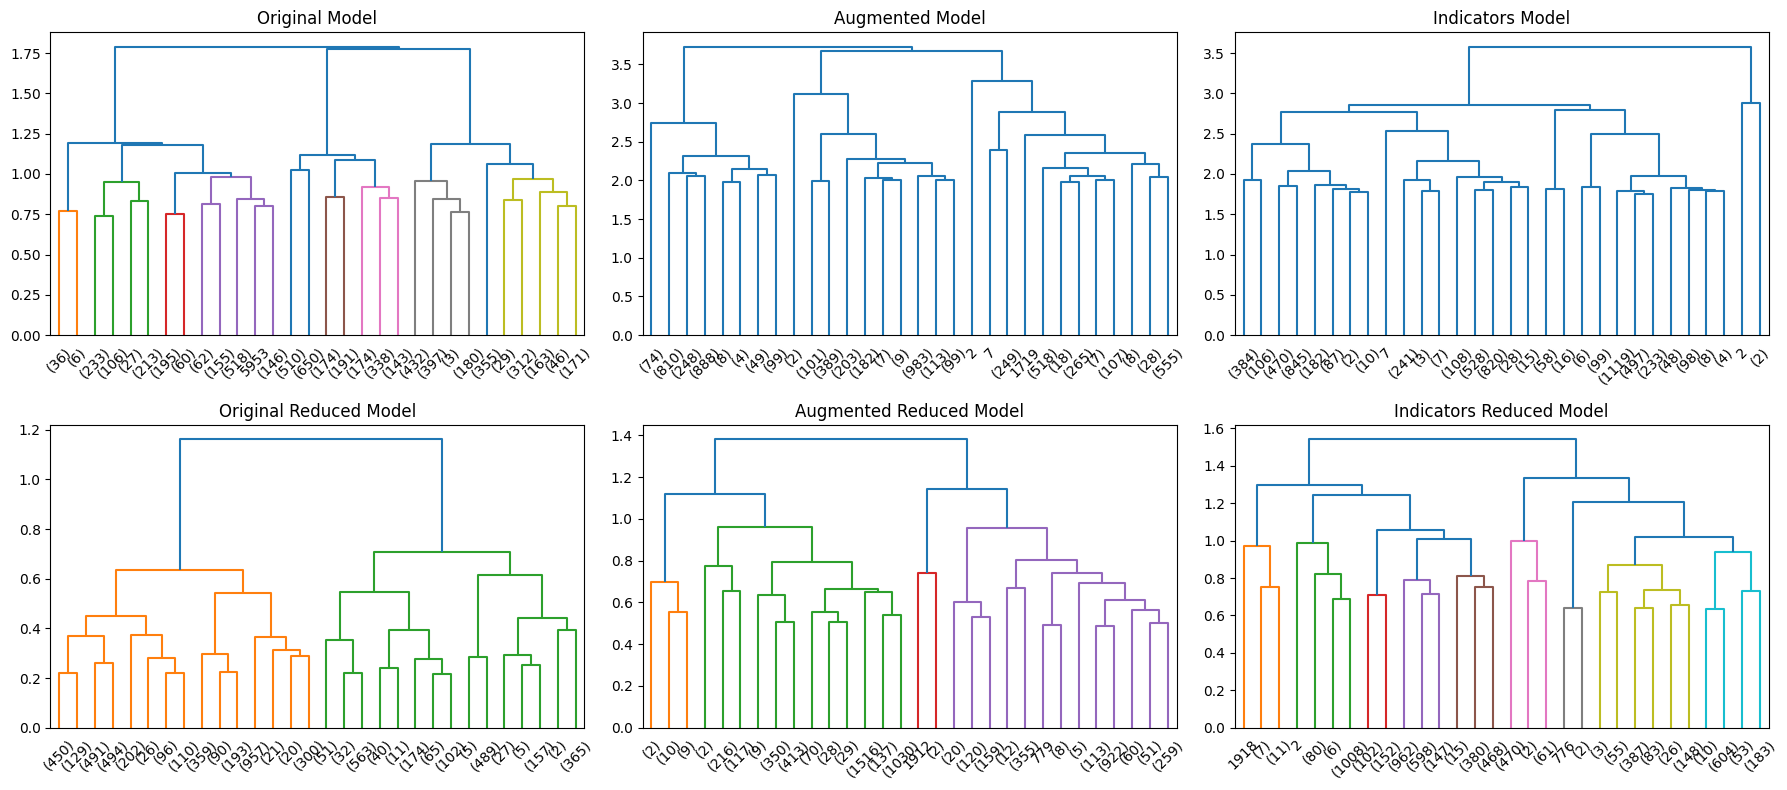

centroid linkage: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it]


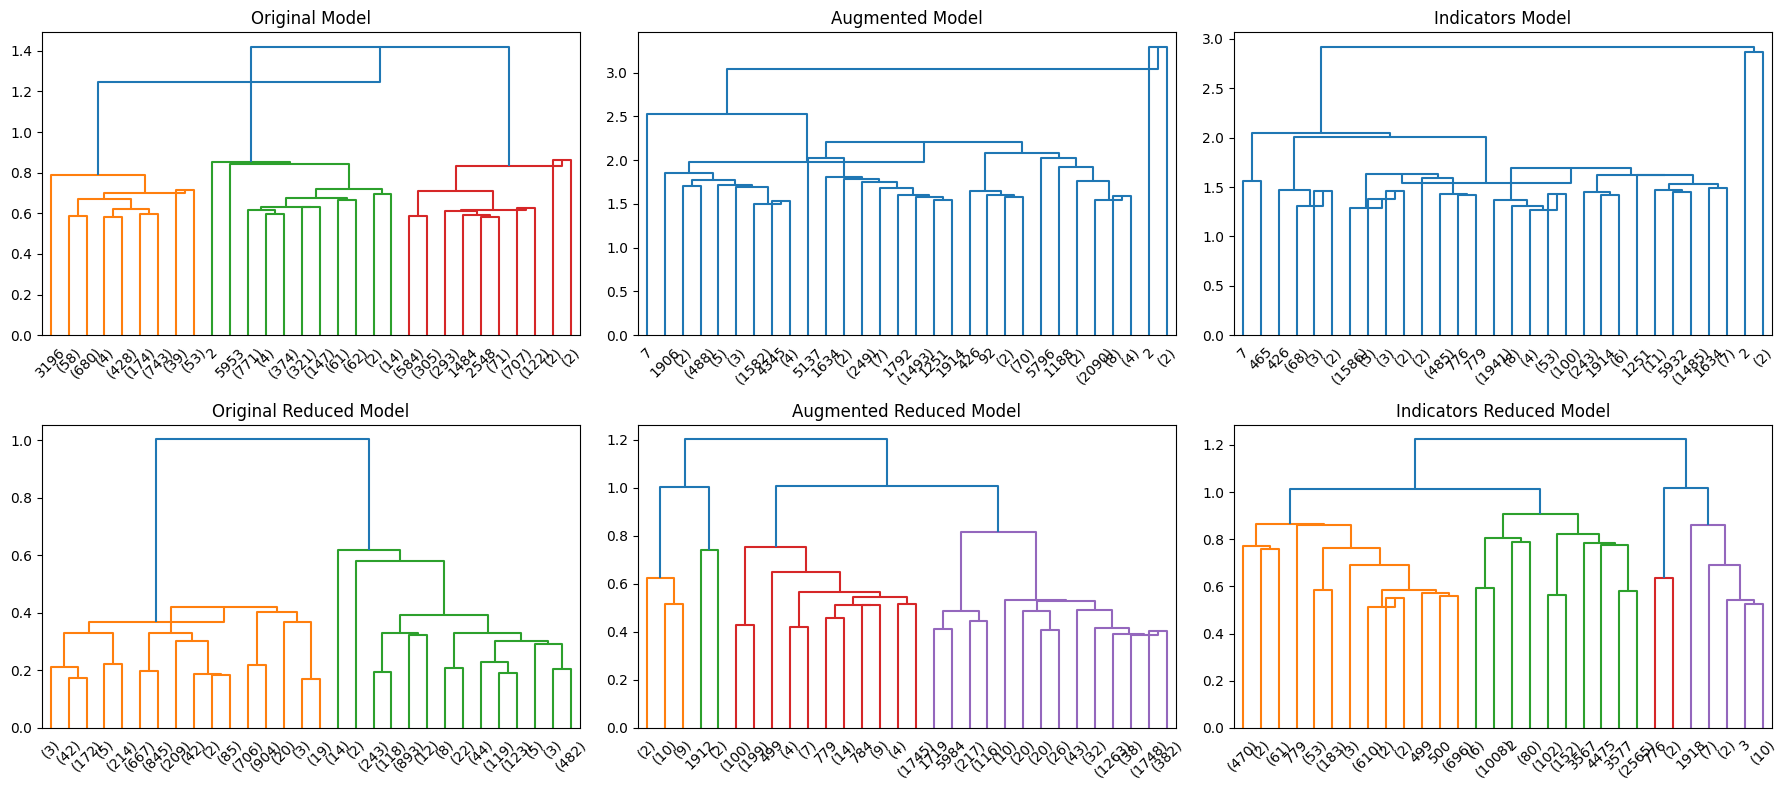

median linkage: 100%|██████████| 12/12 [00:17<00:00,  1.46s/it]


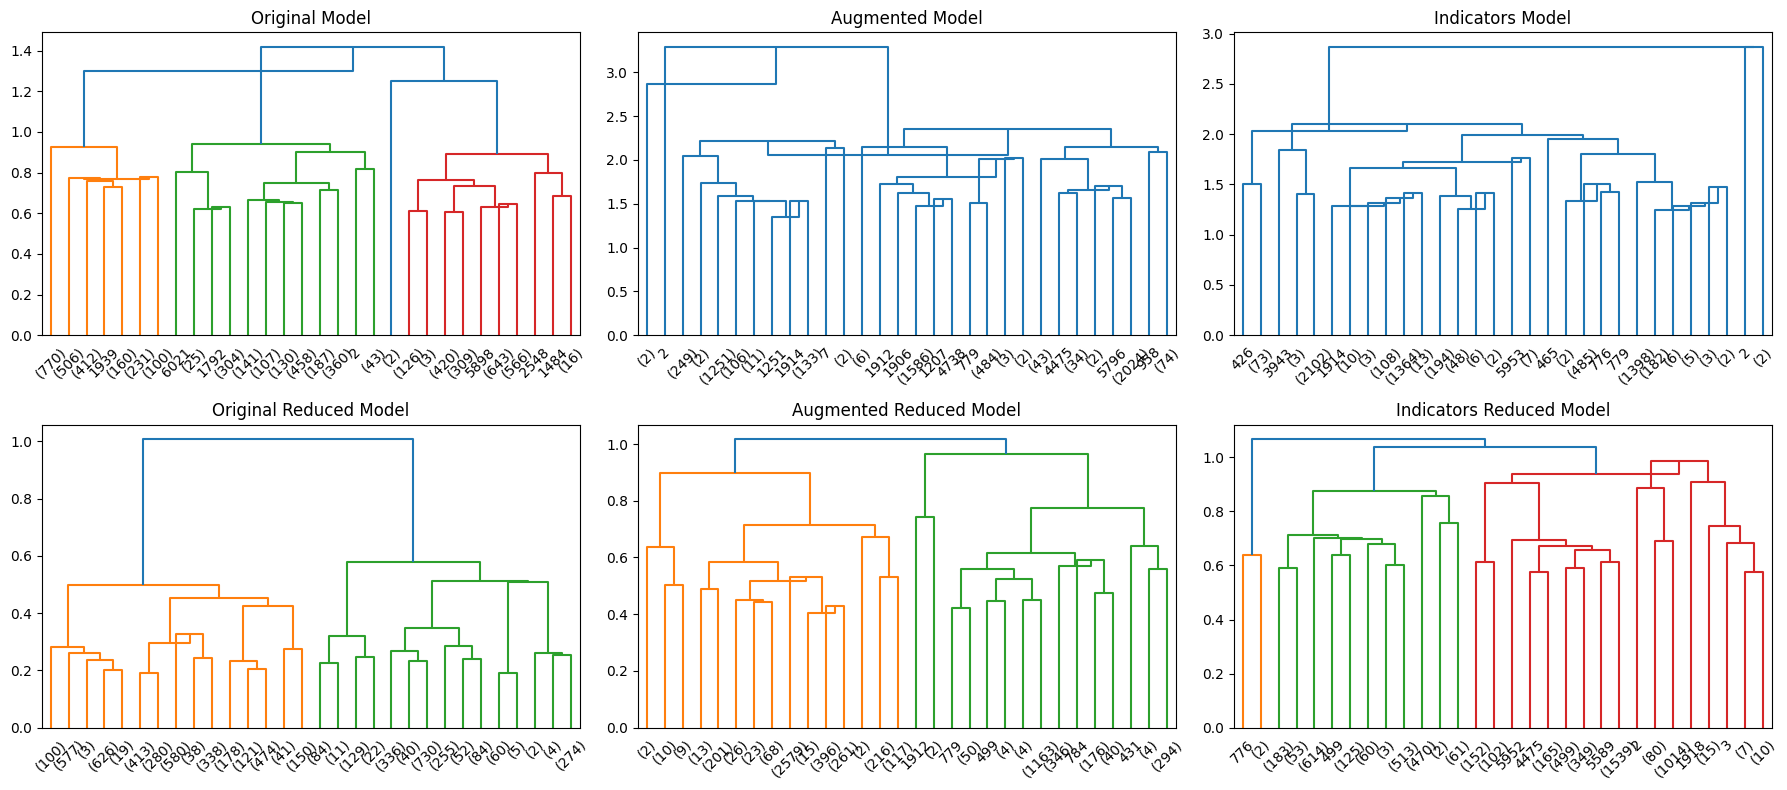

In [10]:
methods = ['single', 'complete', 'ward', 'average', 'weighted', 'centroid', 'median']
model_dict = {}
for method in methods:
    model_dict[method] = []

all_dataframes = scaled_dataframes + random_scaled_dataframes
model_names = MODEL_NAMES + ['Random ' + name for name in MODEL_NAMES]

for method in methods:
    fig, axes = plt.subplots(2, 3, figsize=(18, 8))
    i = -1
    for j in tqdm(range(len(all_dataframes)), desc=method+' linkage', position=0, leave=True):
        dataframe = all_dataframes[j]
        model_name = model_names[j]
        
        data_dist = pdist(dataframe, metric='euclidean')
        data_link = linkage(data_dist, method=method, metric='euclidean')
        model_dict[method].append(data_link)

        if 'Random' not in model_name:        
            if j%3 == 0:
                i += 1

            ax = axes[i, j%3]
            res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp', ax=ax)
            ax.set_title(f'{model_name}')

    plt.tight_layout()
    plt.show()

---
## Analysis

In [42]:
# organize results

data_names = ['Original', 'Augmented', 'Indicators']
data_names += [s + ' Reduced' for s in data_names]
data_names += ['Random ' + s for s in data_names]

best_models = {}

for method in methods:
    best_models[method] = {}
    for s in ['labels', 'silhouette', 'height']:
        best_models[method][s] = []
    best_models[method]['dataset'] = data_names

for i in range(len(all_dataframes)):
    dataframe = all_dataframes[i]
    for method in methods:
        data_link = model_dict[method][i]
        best_sil = -2
        heights = np.unique(data_link[:, 2])
        heights = heights[-11:-1]
        for height in tqdm(heights, desc=f'{model_names[i]}, {method}', leave=False):
            
            # Cut the hierarchy at the current height
            labels = fcluster(data_link, height, criterion='distance')

            # Compute silhouette score
            sil = silhouette_score(dataframe, labels)

            if sil > best_sil:
                best_sil = sil
                best_height = height
                best_labels = labels

        best_models[method]['labels'].append(best_labels)
        best_models[method]['silhouette'].append(best_sil)
        best_models[method]['height'].append(best_height)

In [79]:
# save results

for method in methods:
    dataframe = pd.DataFrame(best_models[method])
    dataframe.to_csv(f'models/Hier_{method}.csv', index=True)

/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with f

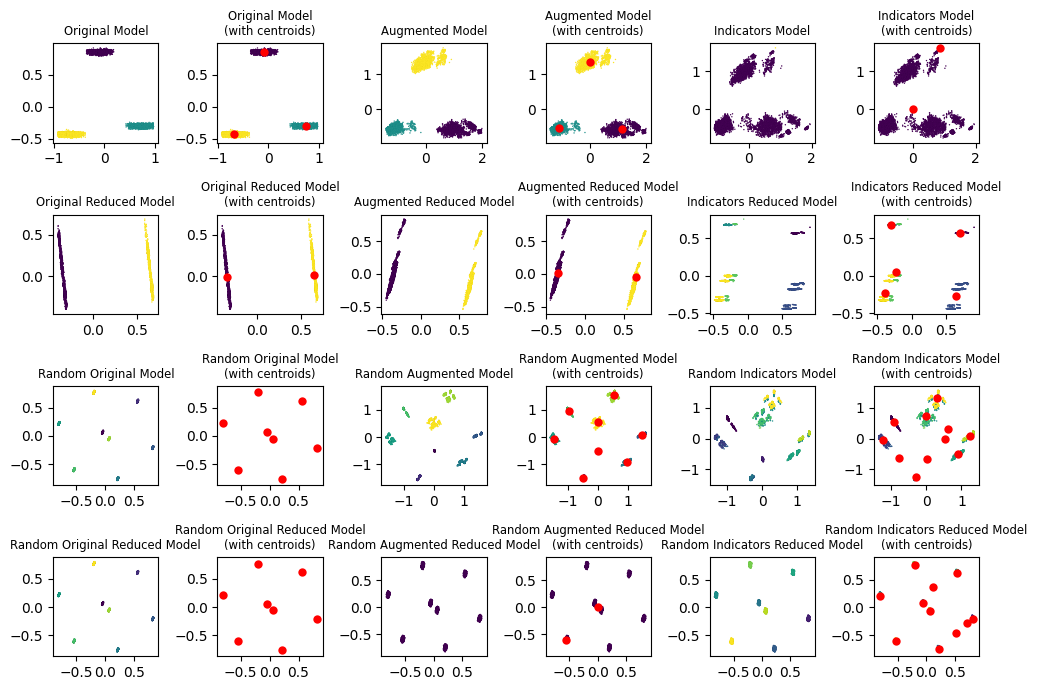

In [78]:
# PCA clustering

plt.figure(figsize=(10, 7))
N = 12
for i, j in zip(range(N), np.arange(1, N*2, 2)):
    model = list(best_models2.values())[i]
    labels = model['labels'][np.argmax(model['silhouette'])]
    data = all_dataframes[i]

    plt.subplot(4, 6, j)
    plt.title(model_names[i], fontsize='small')
    pca_d, pca_c = perform_PCA(df=data, n_components=2, centroids=all_meanss[i])
    plt.scatter(pca_d[:, 0], pca_d[:, 1], c=labels, s=1, edgecolors='black', linewidths=0.001)

    plt.subplot(4, 6, j+1)
    plt.title(f'{model_names[i]}\n(with centroids)', fontsize='small')
    pca_d, pca_c = perform_PCA(df=data, n_components=2, centroids=all_meanss[i])
    plt.scatter(pca_d[:, 0], pca_d[:, 1], c=labels, s=1, edgecolors='black', linewidths=0.001)
    plt.scatter(pca_c[:, 0], pca_c[:, 1], c='red', edgecolors='black', linewidths=0.001)

plt.tight_layout()
plt.show()

In [106]:
# visualize result and stats

model_stats = {
    'dataset': data_names,
    'best method': [],
    'silhouette mean': [],
    'silhouette variance': [],
    'silhouette max': [],
    'silhouette min': [],
    'best height': [],
    'height mean': [],
    'height variance': [],
    'height max': [],
    'height min': [],
    'best k': [],
    'k mean': [],
    'k variance': [],
    'k max': [],
    'k min': []
}
best_models2 = {}

for i, dataset in enumerate(data_names):
    best_models2[dataset] = {
        'method': [],
        'silhouette': [],
        'height': [],
        'labels': [],
        'k': []
    }

    for method in methods:
        best_models2[dataset]['method'].append(method)
        best_models2[dataset]['silhouette'].append(best_models[method]['silhouette'][i])
        best_models2[dataset]['height'].append(best_models[method]['height'][i])
        best_models2[dataset]['labels'].append(best_models[method]['labels'][i])
        best_models2[dataset]['k'].append(len(np.unique(best_models[method]['labels'][i])))
    
    model_stats['best method'].append(best_models2[dataset]['method'][np.argmax(best_models2[dataset]['silhouette'])])

    model_stats['silhouette mean'].append(np.mean(best_models2[dataset]['silhouette']))
    model_stats['silhouette variance'].append(np.var(best_models2[dataset]['silhouette']))
    model_stats['silhouette max'].append(np.max(best_models2[dataset]['silhouette']))
    model_stats['silhouette min'].append(np.min(best_models2[dataset]['silhouette']))

    model_stats['best height'].append(best_models2[dataset]['height'][np.argmax(best_models2[dataset]['silhouette'])])
    model_stats['height mean'].append(np.mean(best_models2[dataset]['height']))
    model_stats['height variance'].append(np.var(best_models2[dataset]['height']))
    model_stats['height max'].append(np.max(best_models2[dataset]['height']))
    model_stats['height min'].append(np.min(best_models2[dataset]['height']))

    model_stats['best k'].append(best_models2[dataset]['k'][np.argmax(best_models2[dataset]['silhouette'])])
    model_stats['k mean'].append(np.mean(best_models2[dataset]['k']))
    model_stats['k variance'].append(np.var(best_models2[dataset]['k']))
    model_stats['k max'].append(np.max(best_models2[dataset]['k']))
    model_stats['k min'].append(np.min(best_models2[dataset]['k']))

model_stats_df = pd.DataFrame(model_stats)
print('Stats')
display(model_stats_df)

best_models2_dfs = [pd.DataFrame(best_models2[dataframe]) for dataframe in data_names]
for dataframe, data_name in zip(best_models2_dfs, data_names):
    print(data_name)
    display(dataframe)

Stats


dataset best method  silhouette mean  \
0                    Original      single         0.512991   
1                   Augmented        ward         0.359197   
2                  Indicators      single         0.384085   
3            Original Reduced      single         0.670266   
4           Augmented Reduced      single         0.552343   
5          Indicators Reduced        ward         0.436765   
6             Random Original      single         0.220790   
7            Random Augmented     average         0.132045   
8           Random Indicators    weighted         0.124850   
9     Random Original Reduced      single         0.220790   
10   Random Augmented Reduced      single         0.091319   
11  Random Indicators Reduced    weighted         0.113189   

    silhouette variance  silhouette max  silhouette min  best height  \
0              0.000000        0.512991        0.512991     0.502682   
1              0.000183        0.371067        0.329292    48.477395   
2              0.000745        0.409695        0.328230     2.295832   
3              0.000000        0.670266        0.670266     0.196303   
4              0.000003        0.553358        0.549804     0.724536   
5              0.000378        0.454514        0.390702    17.613063   
6              0.005323        0.274419        0.104111     0.659708   
7              0.002736        0.184702        0.044497     3.002945   
8              0.001773        0.157118        0.025712     2.937327   
9              0.005323        0.274419        0.104111     0.659708   
10             0.002550        0.137126       -0.020678     1.552427   
11             0.000929        0.144486        0.047625     1.984292   

    height mean  height variance  height max  height min  best k    k mean  \
0      4.228152        56.665282   22.630433    0.502682       3  3.000000   
1      9.167098       258.037278   48.477395    1.622095       3  4.428571   
2      6.544439        84.262738   28.996041    2.097963       2  2.571429   
3      3.175409        38.437276   18.342744    0.196303       2  2.000000   
4      3.915721        47.014500   20.695772    0.724536       2  2.285714   
5      3.460279        33.553467   17.613063    0.754810       5  5.714286   
6      3.075429        15.478102   12.662119    0.659708       8  6.428571   
7      6.671760        80.027770   28.541318    2.055782       8  6.571429   
8      6.581423        86.949609   29.378076    1.879363      11  6.714286   
9      3.075429        15.478102   12.662119    0.659708       8  6.428571   
10     4.219262        21.441559   15.498884    1.552427       2  4.142857   
11     3.851893        20.584523   14.906092    1.280766      11  5.285714   

    k variance  k max  k min  
0     0.000000      3      3  
1     1.102041      6      3  
2     1.102041      5      2  
3     0.000000      2      2  
4     0.204082      3      2  
5     5.632653      9      2  
6     7.959184      9      2  
7    14.530612     11      2  
8    15.346939     11      2  
9     7.959184      9      2  
10    9.551020     11      2  
11   14.775510     11      2

Original


method  silhouette     height  \
0    single    0.512991   0.502682   
1  complete    0.512991   2.166600   
2      ward    0.512991  22.630433   
3   average    0.512991   0.990540   
4  weighted    0.512991   1.194722   
5  centroid    0.512991   0.861733   
6    median    0.512991   1.250352   

                                              labels  k  
0  [3, 3, 1, 2, 1, 2, 3, 1, 2, 1, 3, 3, 1, 2, 1, ...  3  
1  [2, 2, 1, 3, 1, 3, 2, 1, 3, 1, 2, 2, 1, 3, 1, ...  3  
2  [3, 3, 2, 1, 2, 1, 3, 2, 1, 2, 3, 3, 2, 1, 2, ...  3  
3  [1, 1, 3, 2, 3, 2, 1, 3, 2, 3, 1, 1, 3, 2, 3, ...  3  
4  [3, 3, 1, 2, 1, 2, 3, 1, 2, 1, 3, 3, 1, 2, 1, ...  3  
5  [3, 3, 2, 1, 2, 1, 3, 2, 1, 2, 3, 3, 2, 1, 2, ...  3  
6  [3, 3, 2, 1, 2, 1, 3, 2, 1, 2, 3, 3, 2, 1, 2, ...  3

Augmented


method  silhouette     height  \
0    single    0.357927   1.622095   
1  complete    0.369171   3.849672   
2      ward    0.371067  48.477395   
3   average    0.357927   2.635005   
4  weighted    0.371067   3.289632   
5  centroid    0.329292   2.078914   
6    median    0.357927   2.216971   

                                              labels  k  
0  [1, 1, 5, 4, 2, 4, 3, 2, 4, 2, 3, 3, 2, 4, 2, ...  5  
1  [1, 1, 1, 4, 2, 4, 3, 2, 4, 2, 3, 3, 2, 4, 2, ...  4  
2  [1, 1, 3, 2, 3, 2, 1, 3, 2, 3, 1, 1, 3, 2, 3, ...  3  
3  [4, 4, 5, 3, 2, 3, 1, 2, 3, 2, 1, 1, 2, 3, 2, ...  5  
4  [2, 2, 3, 1, 3, 1, 2, 3, 1, 3, 2, 2, 3, 1, 3, ...  3  
5  [5, 5, 6, 3, 2, 3, 1, 4, 3, 2, 1, 1, 2, 3, 2, ...  6  
6  [1, 1, 5, 4, 2, 4, 3, 2, 4, 2, 3, 3, 2, 4, 2, ...  5

Indicators


method  silhouette     height  \
0    single    0.409695   2.295832   
1  complete    0.398063   3.794023   
2      ward    0.328230  28.996041   
3   average    0.398063   2.878334   
4  weighted    0.398063   2.878334   
5  centroid    0.398063   2.870544   
6    median    0.358420   2.097963   

                                              labels  k  
0  [1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  2  
1  [1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...  2  
2  [5, 5, 5, 1, 4, 1, 5, 4, 1, 4, 5, 5, 4, 1, 4, ...  5  
3  [2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  2  
4  [2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  2  
5  [2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  2  
6  [2, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  3

Original Reduced


method  silhouette     height  \
0    single    0.670266   0.196303   
1  complete    0.670266   1.304142   
2      ward    0.670266  18.342744   
3   average    0.670266   0.480756   
4  weighted    0.670266   0.706323   
5  centroid    0.670266   0.618649   
6    median    0.670266   0.578949   

                                              labels  k  
0  [2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, ...  2  
1  [2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, ...  2  
2  [1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, ...  2  
3  [1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, ...  2  
4  [2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, ...  2  
5  [2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, ...  2  
6  [2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, ...  2

Augmented Reduced


method  silhouette     height  \
0    single    0.553358   0.724536   
1  complete    0.553358   1.759385   
2      ward    0.553358  20.695772   
3   average    0.549804   1.115092   
4  weighted    0.553358   1.145456   
5  centroid    0.549804   1.003323   
6    median    0.553358   0.966485   

                                              labels  k  
0  [2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, ...  2  
1  [1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, ...  2  
2  [1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, ...  2  
3  [2, 2, 3, 1, 1, 3, 2, 3, 3, 3, 2, 2, 3, 3, 3, ...  3  
4  [2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, ...  2  
5  [2, 2, 3, 1, 1, 3, 2, 3, 3, 3, 2, 2, 3, 3, 3, ...  3  
6  [2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, ...  2

Indicators Reduced


method  silhouette     height  \
0    single    0.444898   0.754810   
1  complete    0.390702   2.045754   
2      ward    0.454514  17.613063   
3   average    0.444636   0.881150   
4  weighted    0.444033   1.208903   
5  centroid    0.441808   0.862350   
6    median    0.436762   0.855921   

                                              labels  k  
0  [2, 2, 4, 3, 3, 3, 1, 3, 3, 3, 1, 1, 3, 3, 3, ...  4  
1  [1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, ...  2  
2  [1, 1, 4, 4, 4, 5, 2, 5, 5, 5, 2, 2, 5, 5, 5, ...  5  
3  [4, 4, 7, 2, 2, 9, 6, 9, 9, 9, 6, 6, 9, 9, 9, ...  9  
4  [4, 4, 2, 1, 1, 3, 5, 3, 3, 3, 5, 5, 3, 3, 3, ...  5  
5  [1, 1, 3, 6, 6, 4, 2, 4, 4, 4, 2, 2, 4, 4, 4, ...  6  
6  [3, 3, 7, 8, 8, 8, 2, 5, 5, 5, 2, 2, 5, 5, 5, ...  9

Random Original


method  silhouette     height  \
0    single    0.274419   0.659708   
1  complete    0.232667   2.118150   
2      ward    0.274419  12.662119   
3   average    0.274419   1.410902   
4  weighted    0.274304   1.553130   
5  centroid    0.111189   1.459534   
6    median    0.104111   1.664460   

                                              labels  k  
0  [3, 1, 4, 6, 3, 2, 7, 7, 1, 3, 4, 6, 8, 7, 3, ...  8  
1  [5, 3, 7, 8, 5, 3, 2, 2, 6, 5, 7, 8, 1, 2, 5, ...  9  
2  [4, 2, 3, 7, 4, 1, 5, 5, 2, 4, 3, 7, 6, 5, 4, ...  8  
3  [1, 3, 2, 8, 1, 5, 7, 7, 3, 1, 2, 8, 4, 7, 1, ...  8  
4  [2, 4, 1, 7, 2, 3, 5, 5, 4, 2, 1, 7, 6, 5, 2, ...  8  
5  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  2  
6  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  2

Random Augmented


method  silhouette     height  \
0    single    0.101707   2.055782   
1  complete    0.168229   4.106171   
2      ward    0.169082  28.541318   
3   average    0.184702   3.002945   
4  weighted    0.178449   3.246267   
5  centroid    0.077648   2.851210   
6    median    0.044497   2.898630   

                                              labels   k  
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   2  
1  [10, 7, 8, 3, 10, 11, 2, 2, 7, 10, 8, 3, 4, 2,...  11  
2  [10, 8, 11, 2, 10, 9, 1, 1, 8, 10, 11, 2, 4, 1...  11  
3  [3, 8, 4, 2, 3, 7, 1, 1, 8, 3, 4, 2, 6, 1, 3, ...   8  
4  [1, 6, 3, 2, 1, 4, 9, 9, 6, 1, 3, 2, 8, 9, 1, ...   9  
5  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   3  
6  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   2

Random Indicators


method  silhouette     height  \
0    single    0.119107   1.879363   
1  complete    0.142390   3.979987   
2      ward    0.142375  29.378076   
3   average    0.153291   2.616721   
4  weighted    0.157118   2.937327   
5  centroid    0.133954   2.679087   
6    median    0.025712   2.599399   

                                              labels   k  
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   2  
1  [6, 7, 6, 6, 6, 8, 6, 6, 7, 6, 6, 6, 8, 6, 6, ...   8  
2  [3, 10, 1, 7, 3, 3, 7, 7, 10, 3, 1, 7, 8, 7, 3...  10  
3  [11, 9, 9, 5, 11, 10, 4, 4, 9, 11, 9, 5, 7, 4,...  11  
4  [10, 9, 9, 5, 10, 11, 2, 2, 9, 10, 9, 5, 1, 2,...  11  
5  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   2  
6  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   3

Random Original Reduced


method  silhouette     height  \
0    single    0.274419   0.659708   
1  complete    0.232667   2.118150   
2      ward    0.274419  12.662119   
3   average    0.274419   1.410902   
4  weighted    0.274304   1.553130   
5  centroid    0.111189   1.459534   
6    median    0.104111   1.664460   

                                              labels  k  
0  [3, 1, 4, 6, 3, 2, 7, 7, 1, 3, 4, 6, 8, 7, 3, ...  8  
1  [5, 3, 7, 8, 5, 3, 2, 2, 6, 5, 7, 8, 1, 2, 5, ...  9  
2  [4, 2, 3, 7, 4, 1, 5, 5, 2, 4, 3, 7, 6, 5, 4, ...  8  
3  [1, 3, 2, 8, 1, 5, 7, 7, 3, 1, 2, 8, 4, 7, 1, ...  8  
4  [2, 4, 1, 7, 2, 3, 5, 5, 4, 2, 1, 7, 6, 5, 2, ...  8  
5  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  2  
6  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  2

Random Augmented Reduced


method  silhouette     height  \
0    single    0.137126   1.552427   
1  complete    0.071301   3.247008   
2      ward    0.102565  15.498884   
3   average    0.114843   2.542978   
4  weighted    0.096952   2.530285   
5  centroid    0.137126   2.048371   
6    median   -0.020678   2.114883   

                                              labels   k  
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   2  
1  [4, 5, 5, 1, 4, 3, 4, 4, 5, 4, 5, 1, 2, 4, 4, ...   5  
2  [11, 8, 10, 4, 11, 8, 1, 1, 9, 11, 10, 4, 2, 1...  11  
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   2  
4  [2, 1, 1, 1, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, ...   2  
5  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   2  
6  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...   5

Random Indicators Reduced


method  silhouette     height  \
0    single    0.128621   1.280766   
1  complete    0.097453   2.931812   
2      ward    0.139742  14.906092   
3   average    0.117199   2.257459   
4  weighted    0.144486   1.984292   
5  centroid    0.117199   1.804806   
6    median    0.047625   1.798024   

                                              labels   k  
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   2  
1  [5, 2, 6, 6, 5, 3, 5, 5, 2, 3, 6, 6, 1, 5, 5, ...   6  
2  [8, 9, 11, 7, 8, 4, 5, 5, 9, 8, 11, 7, 2, 5, 8...  11  
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   2  
4  [2, 5, 4, 11, 2, 7, 10, 10, 5, 2, 4, 11, 9, 10...  11  
5  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   2  
6  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   3

In [80]:
# save results and stats

filenames = ['Orig', 'Augm', 'Ind']
filenames += [s+'Red' for s in filenames]
filenames += ['Rand'+s for s in filenames]

for dataframe, filename in zip(best_models2_dfs, filenames):
    dataframe.to_csv(f'models/Hier_{filename}.csv', index=True)

model_stats_df.to_csv(f'models/Hier_Stats.csv', index=True)

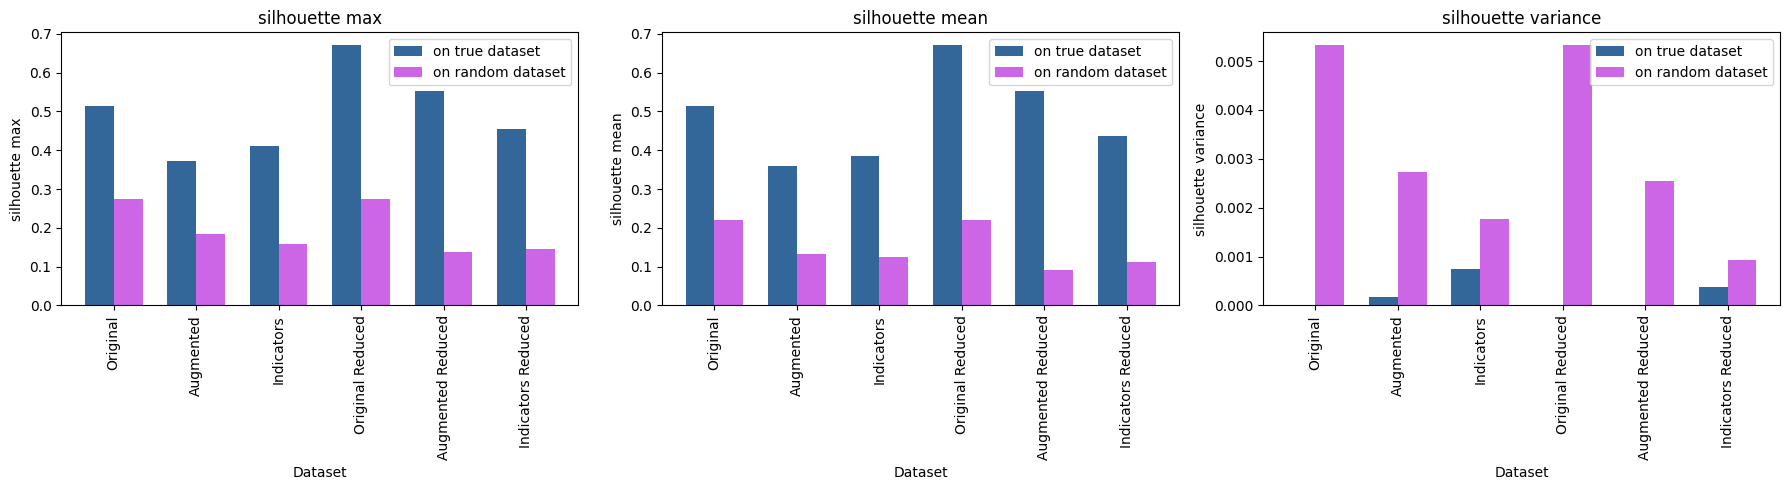

In [60]:
# assessment: comparing obtained models with random data models

plt.figure(figsize=(18, 5))
for i, key in enumerate(['silhouette max', 'silhouette mean', 'silhouette variance']):
    values = [sil for sil in model_stats[key]]
    values_part1 = values[0:6]
    values_part2 = values[6:12]

    color_part1 = (0.2, 0.4, 0.6)
    color_part2 = (0.8, 0.4, 0.9)

    bar_width = 0.35
    bar_positions_part1 = np.arange(len(data_names)/2)
    bar_positions_part2 = bar_positions_part1 + bar_width

    plt.subplot(1, 3, i+1)
    plt.bar(bar_positions_part1, values_part1, width=bar_width, color=color_part1, label='on true dataset')
    plt.bar(bar_positions_part2, values_part2, width=bar_width, color=color_part2, label='on random dataset')
    plt.xticks(bar_positions_part1 + bar_width / 2, data_names[0:6], rotation=90)
    plt.xlabel('Dataset')
    plt.ylabel(key)
    plt.title(key)
    plt.legend()

plt.tight_layout()
plt.show()

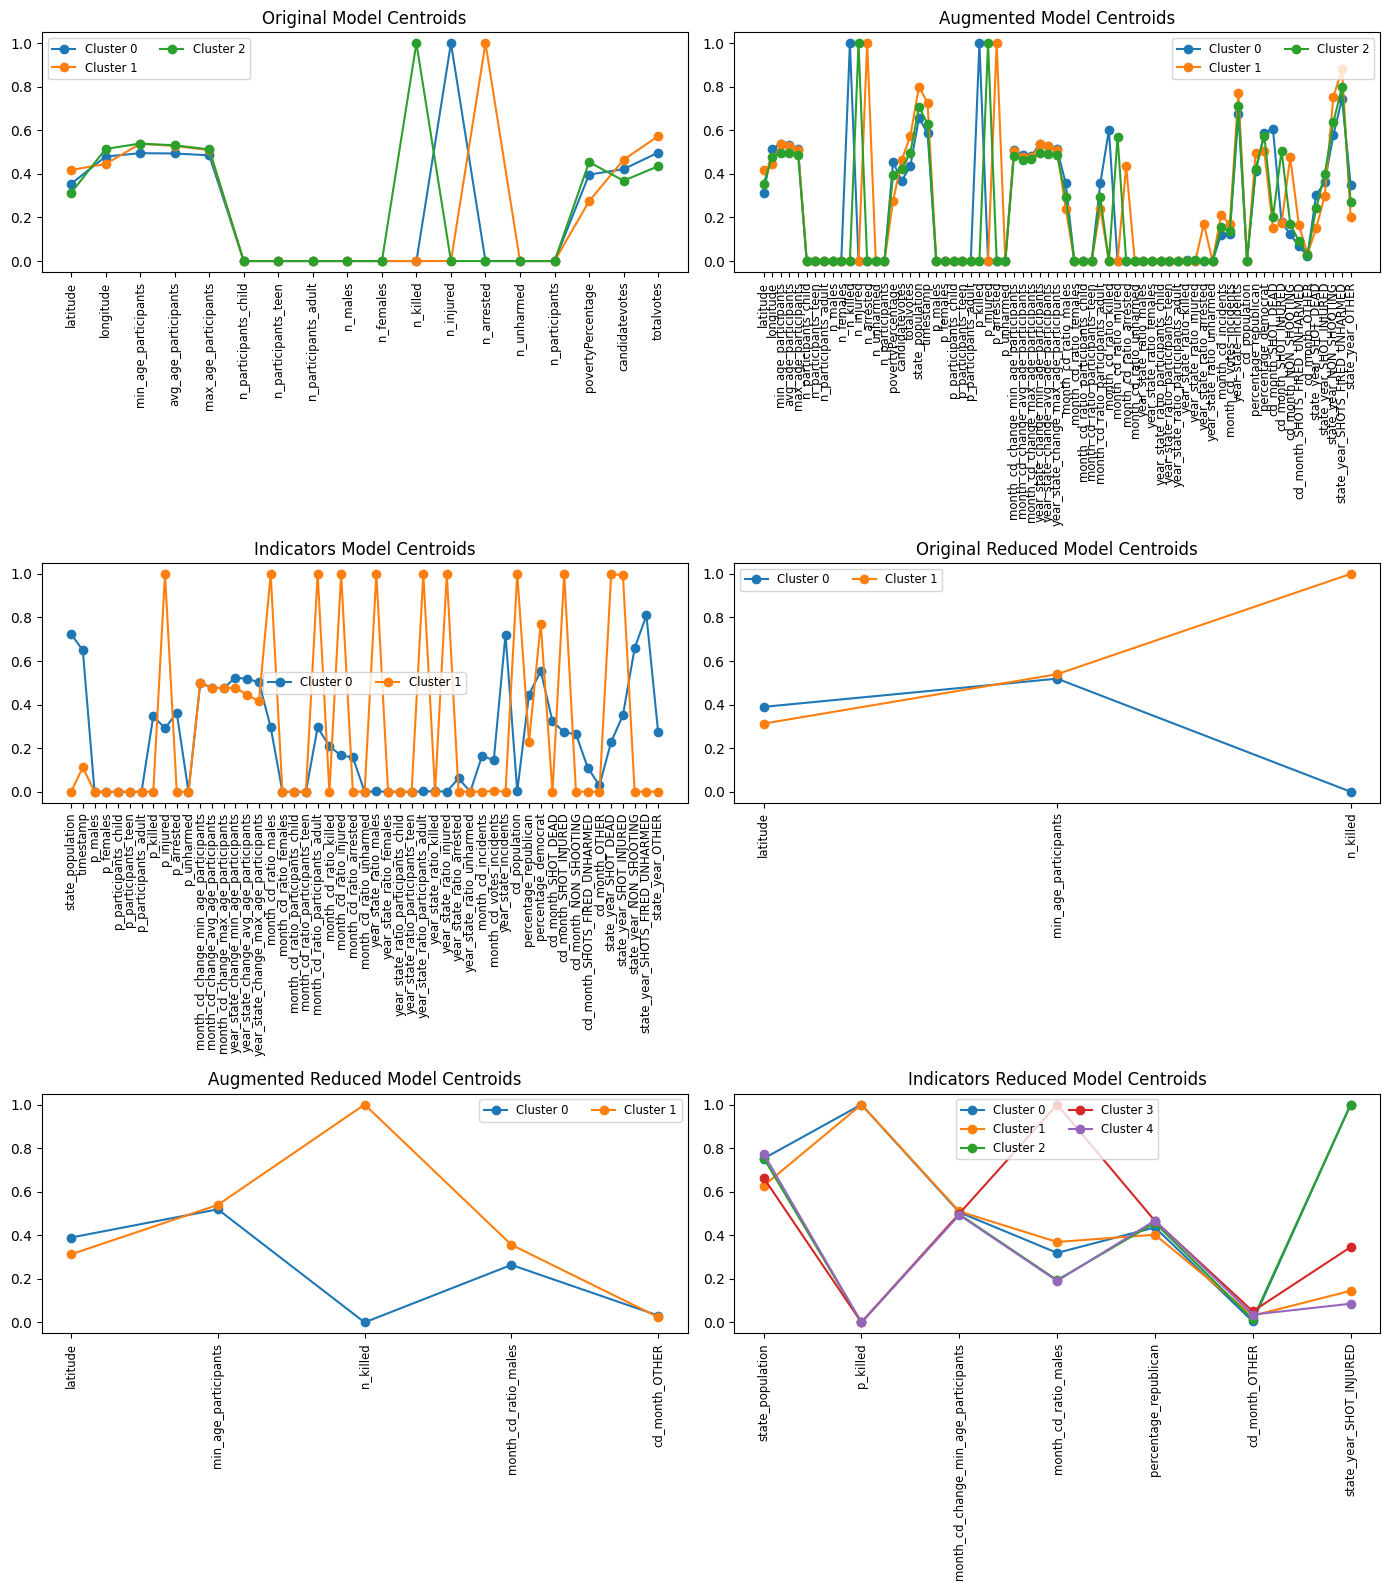

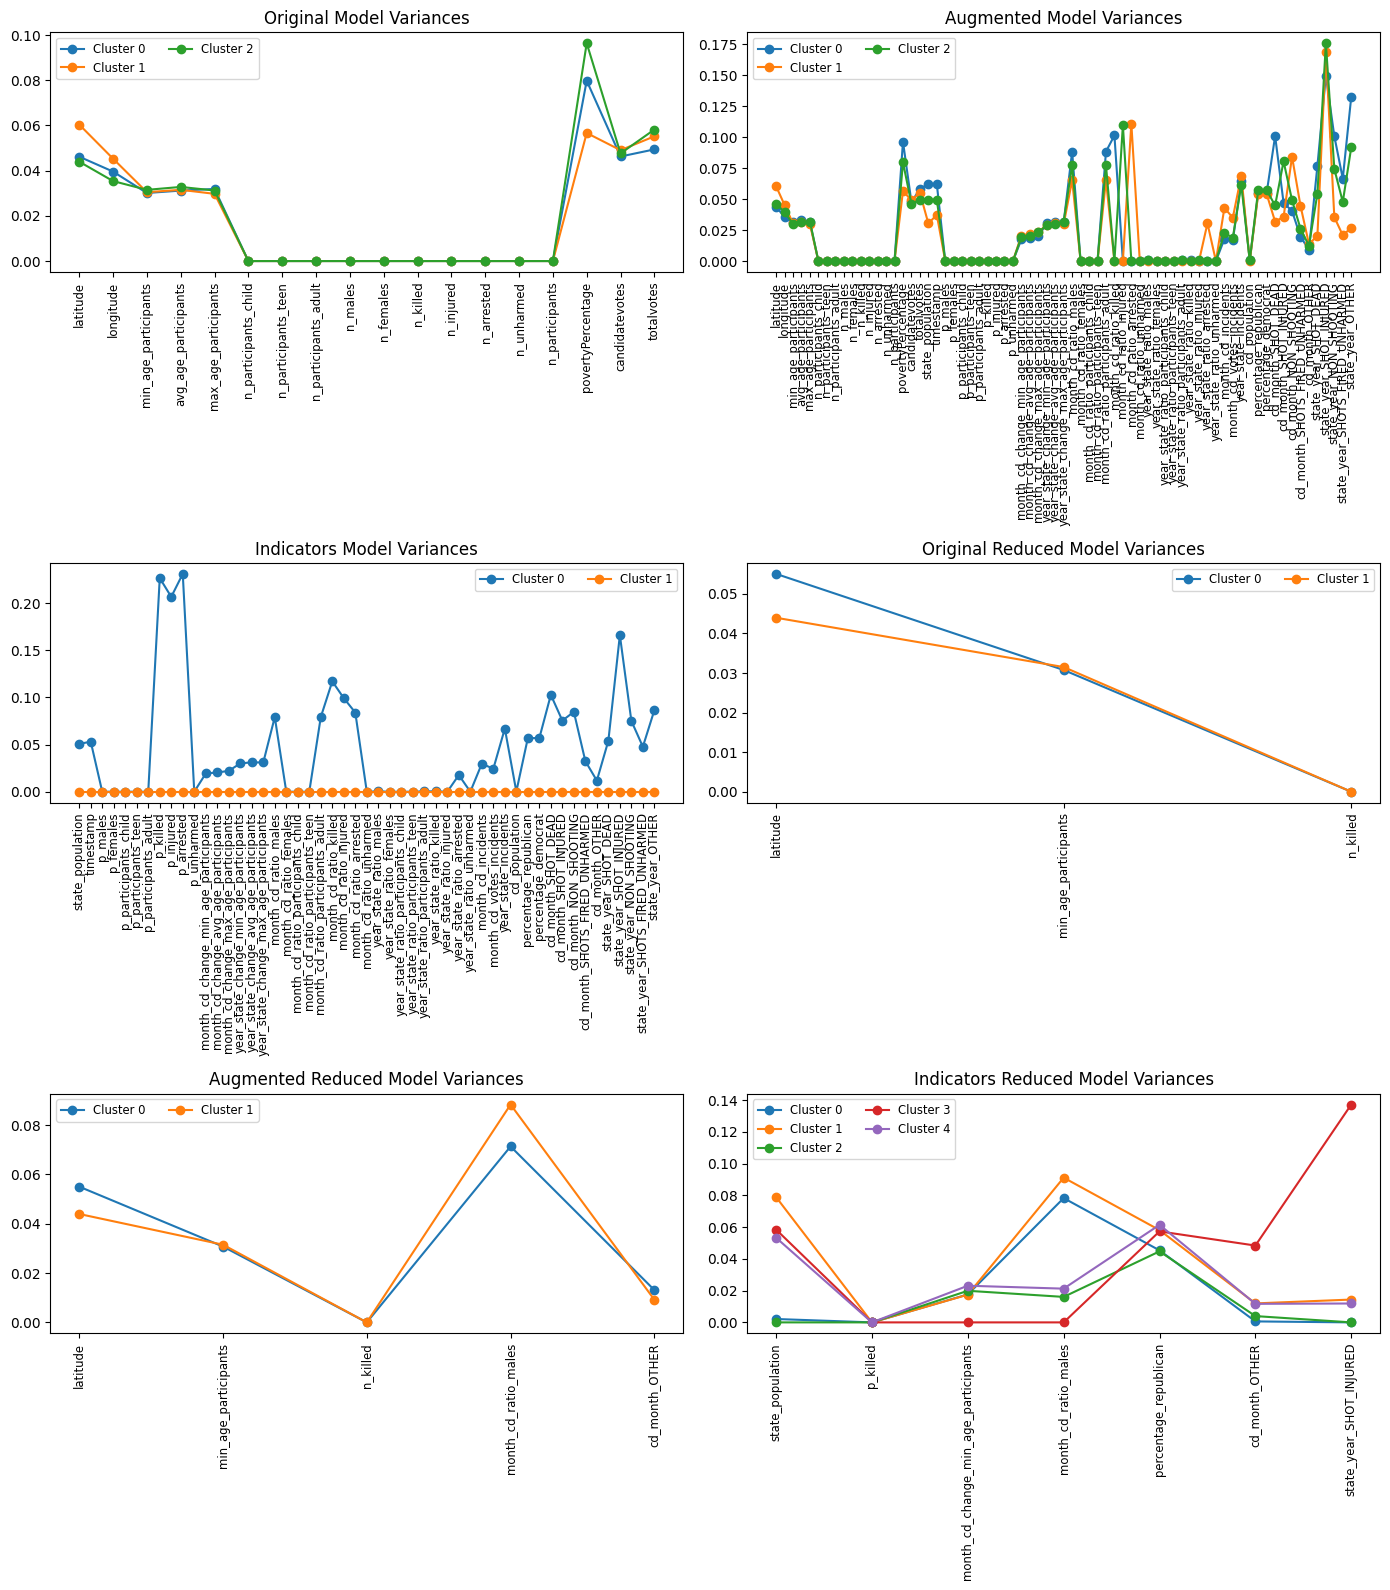

In [70]:
# plot centroids

all_meanss = []
all_variancess = []
for model, dataframe in zip(best_models2.values(), all_dataframes):
    points = dataframe.values
    labels = model['labels'][np.argmax(model['silhouette'])]
    means = []
    variances = []
    for cluster_label in np.unique(labels):
        cluster = [points[i] for i in range(len(points)) if labels[i] == cluster_label]
        means.append(np.mean(cluster, axis=0))
        variances.append(np.var(cluster, axis=0))
    all_meanss.append(means)
    all_variancess.append(variances)

true_meanss = all_meanss[0:6]
random_meanss = all_meanss[6:12]

true_variancess = all_variancess[0:6]
random_variancess = all_variancess[6:12]

plt.figure(figsize=(14, 16))
N = 6

for i in range(N):
    cols = scaled_dataframes[i].columns
    means = true_meanss[i]
    plt.subplot(3, 2, i+1)
    plt.title(f'{model_names[i]} Centroids')
    for z in range(len(means)):
        plt.plot(means[z], marker='o', label=f'Cluster {z}')
        plt.xticks(range(len(cols)), cols, rotation=90, fontsize='small')
        plt.legend(fontsize='small', ncol=2)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 16))
for i in range(N):
    cols = scaled_dataframes[i].columns
    variances = true_variancess[i]
    plt.subplot(3, 2, i+1)
    plt.title(f'{model_names[i]} Variances')
    for z in range(len(variances)):
        plt.plot(variances[z], marker='o', label=f'Cluster {z}')
        plt.xticks(range(len(cols)), cols, rotation=90, fontsize='small')
        plt.legend(fontsize='small', ncol=2)
plt.tight_layout()
plt.show()

In [77]:
# plot attributes with low variance inside each cluster and that present enough different values between at least 2 centroids

N = 6
for i in range(N):
    means = true_meanss[i]
    variances = true_variancess[i]
    cols = scaled_dataframes[i].columns
    model_name = model_names[i]
    l = ''.join(['-' for j in range(50-len(model_name))])
    print(f'{model_name}{l}')
    dists = []
    for mean1 in means:
        for mean2 in means:
            dists.append(np.abs(mean1-mean2))
    model_vars = np.var(means, axis=0)
    for z in range(len(cols)):
        max_dist = np.max([d[z] for d in dists])
        if max_dist > 0.5:
            if False not in [variances[j][z] < 0.1 for j in range(len(variances))]:
                print(cols[z])

Original Model------------------------------------
n_killed
n_injured
n_arrested
Augmented Model-----------------------------------
n_killed
n_injured
n_arrested
p_killed
p_injured
p_arrested
Indicators Model----------------------------------
state_population
timestamp
month_cd_ratio_males
month_cd_ratio_participants_adult
month_cd_ratio_injured
year_state_ratio_males
year_state_ratio_participants_adult
year_state_ratio_injured
year_state_incidents
cd_population
cd_month_SHOT_INJURED
state_year_SHOT_DEAD
state_year_NON_SHOOTING
state_year_SHOTS_FIRED_UNHARMED
Original Reduced Model----------------------------
n_killed
Augmented Reduced Model---------------------------
n_killed
Indicators Reduced Model--------------------------
p_killed
month_cd_ratio_males


Original Model


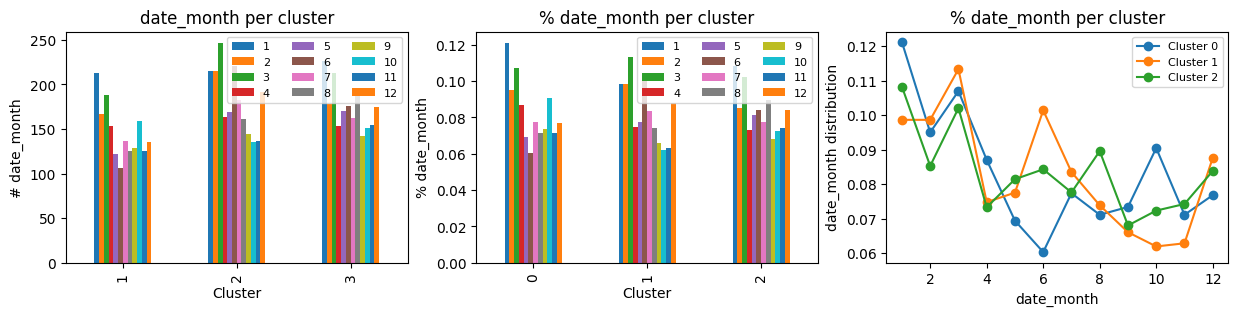

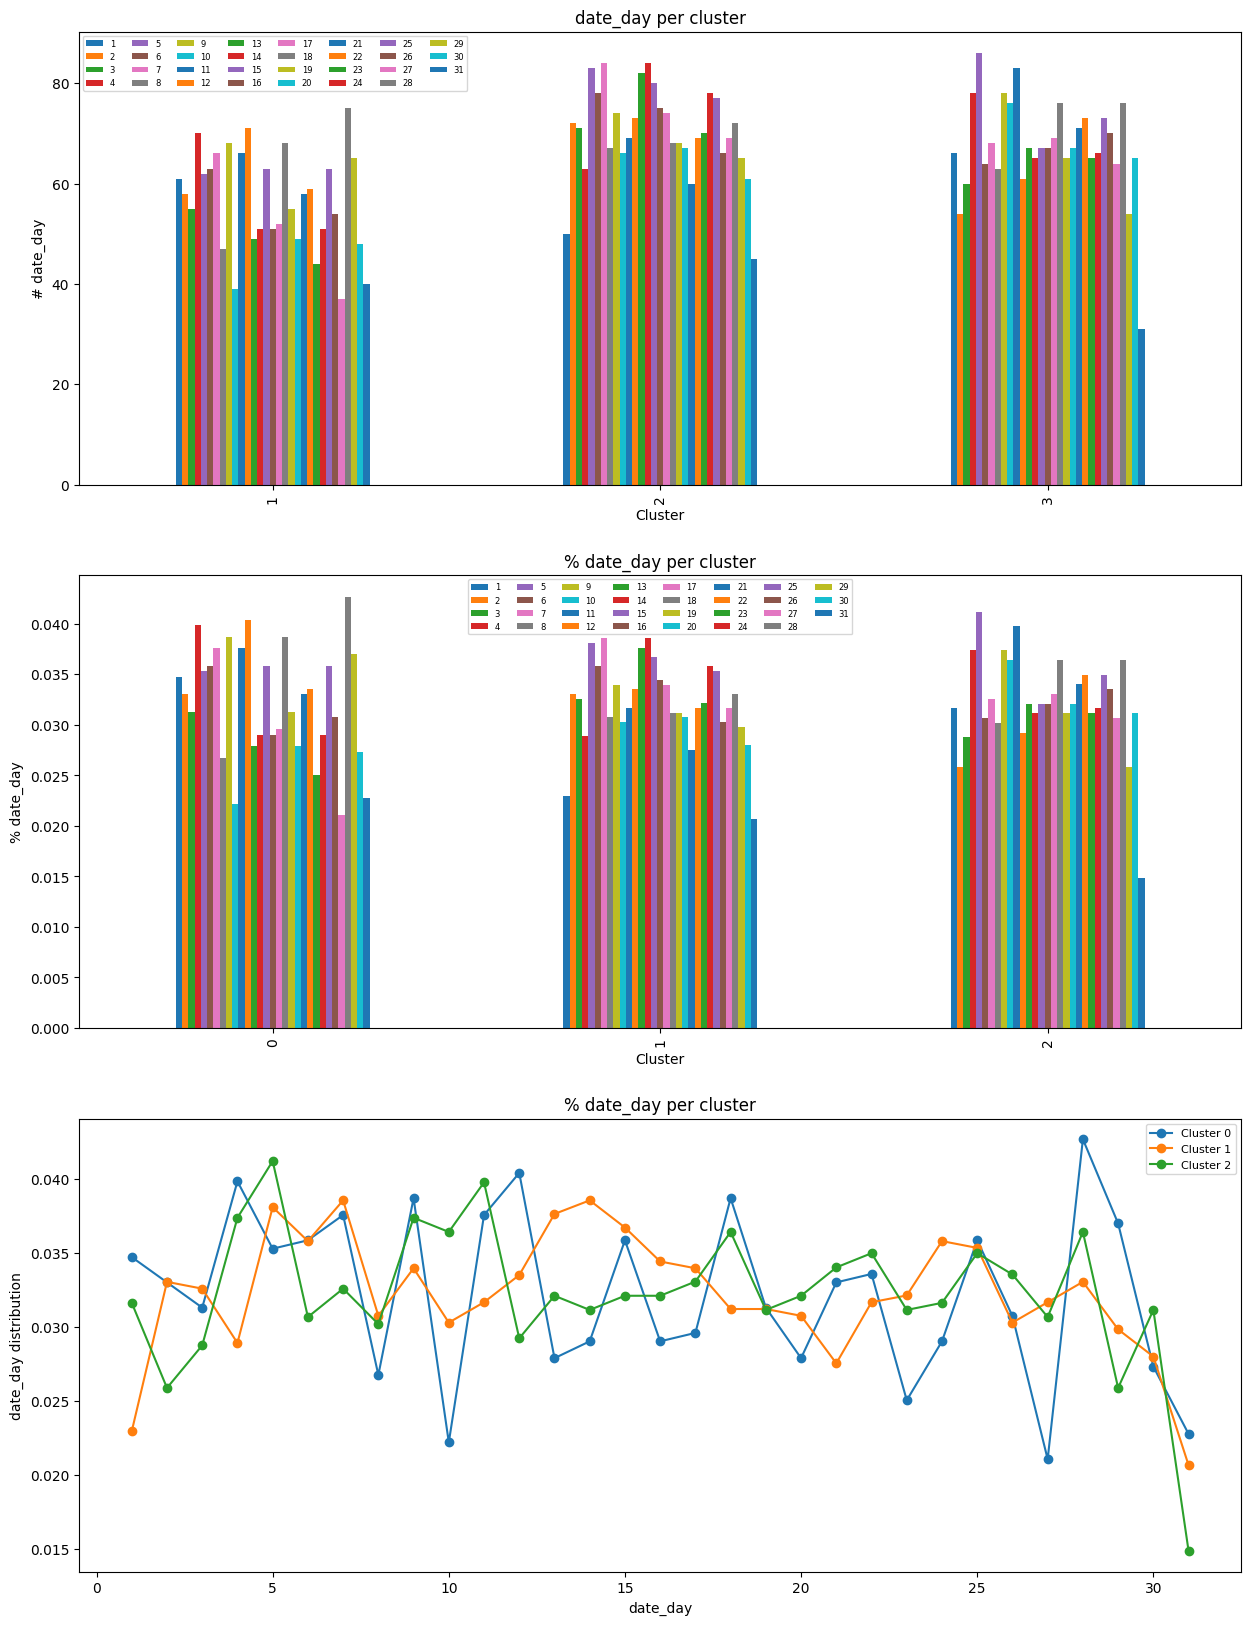

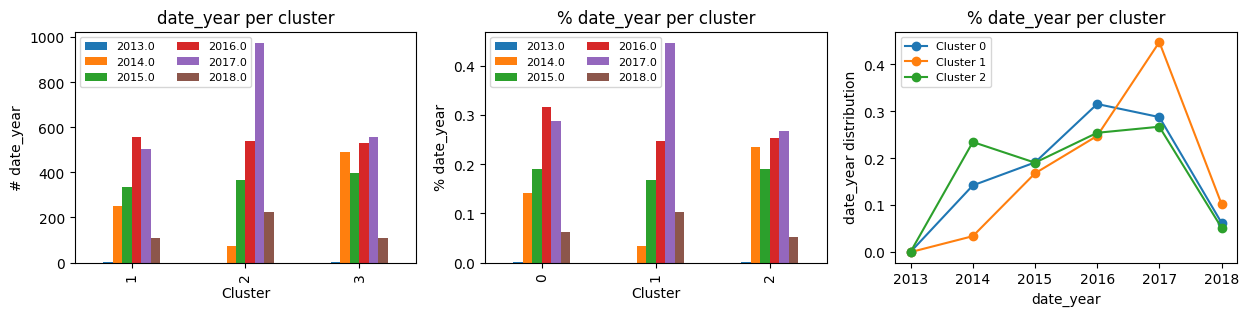

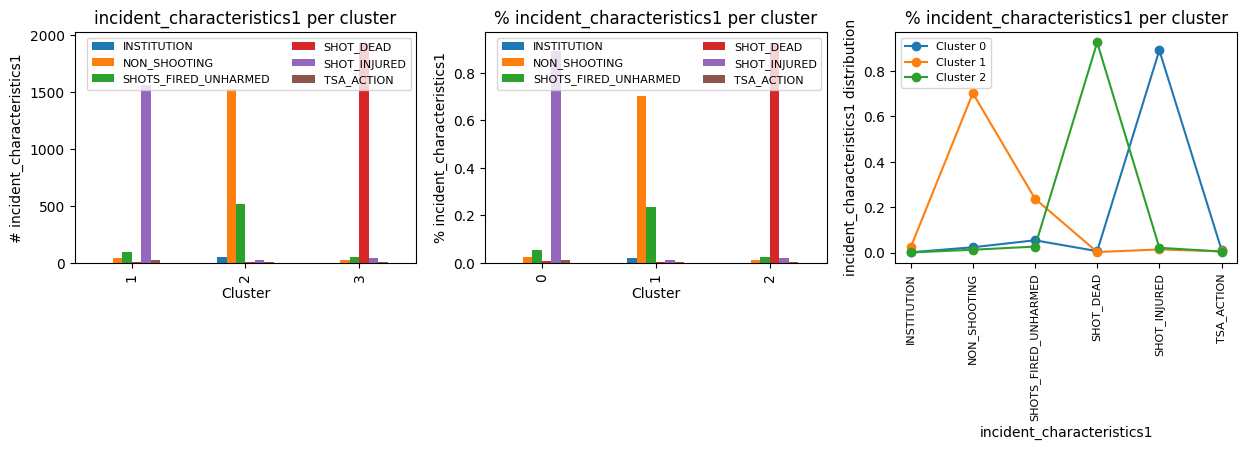

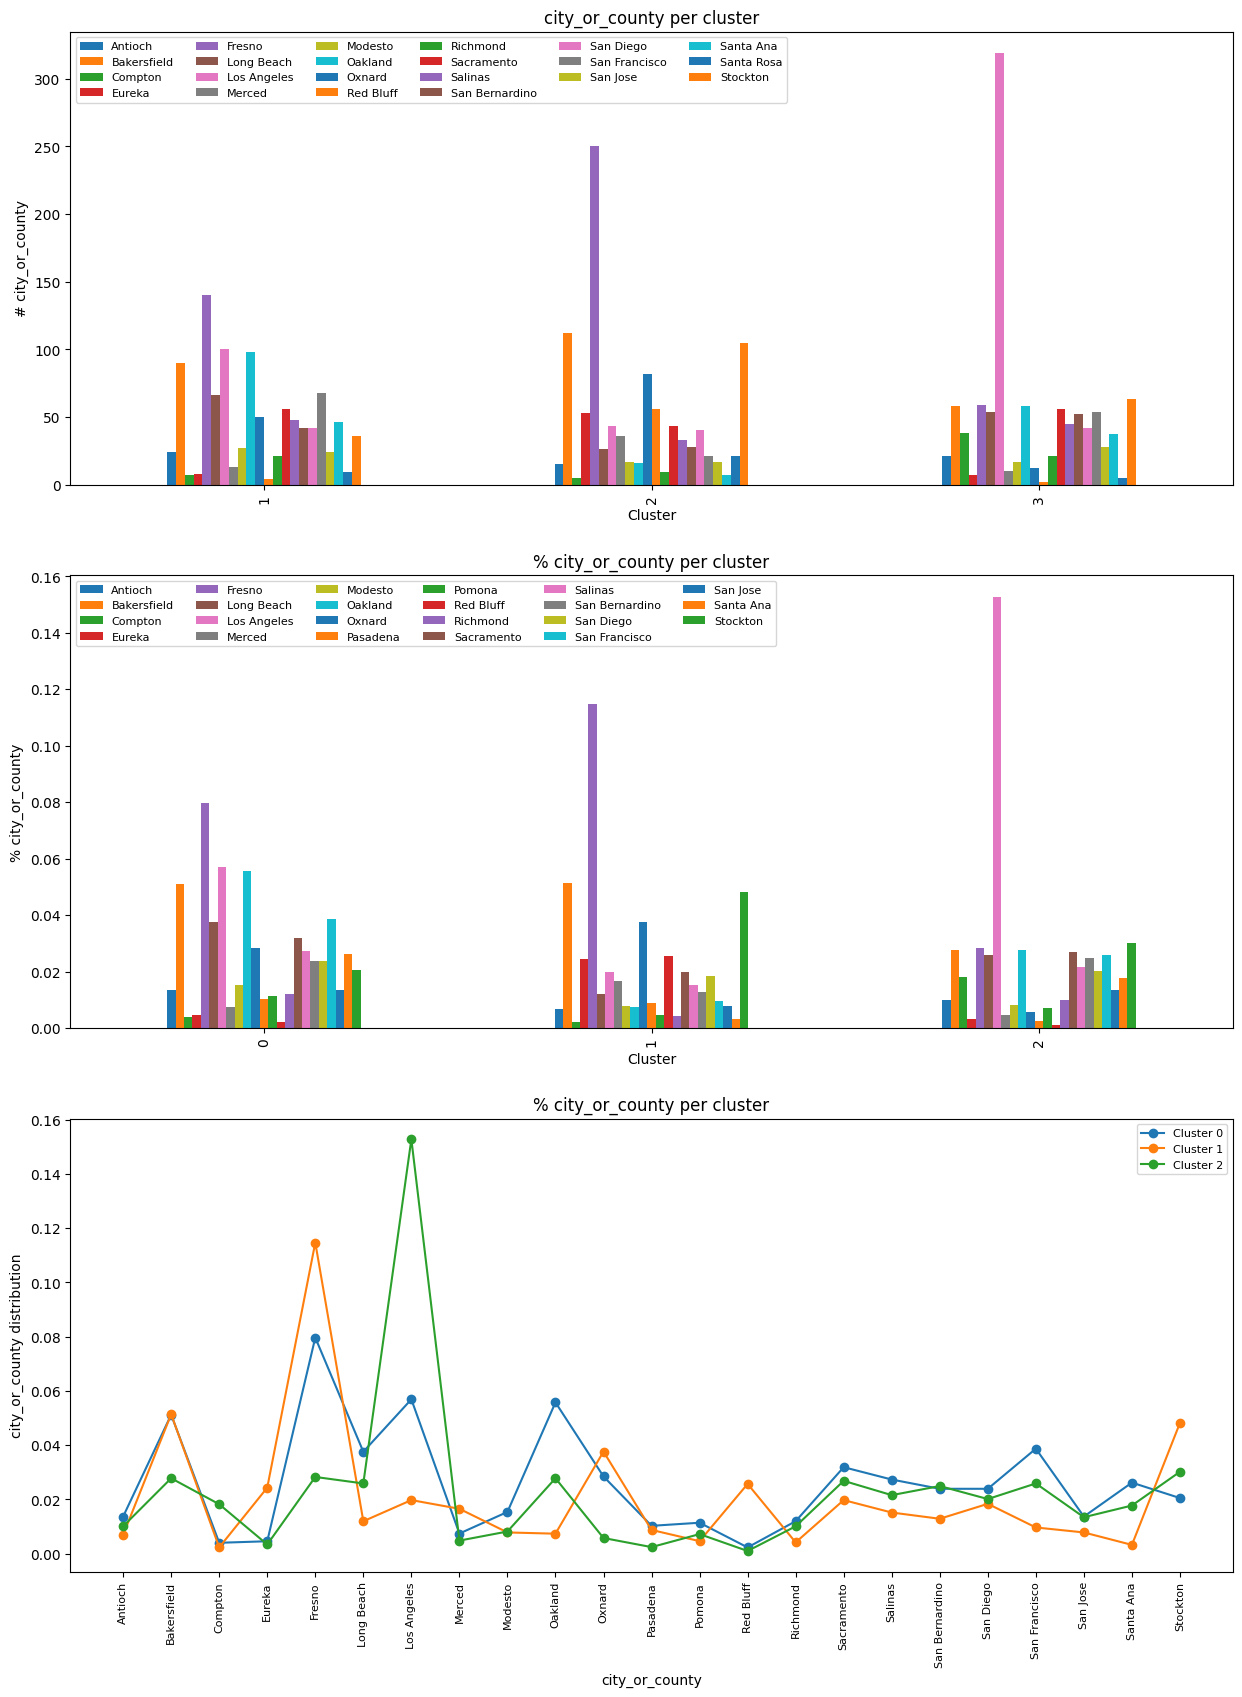

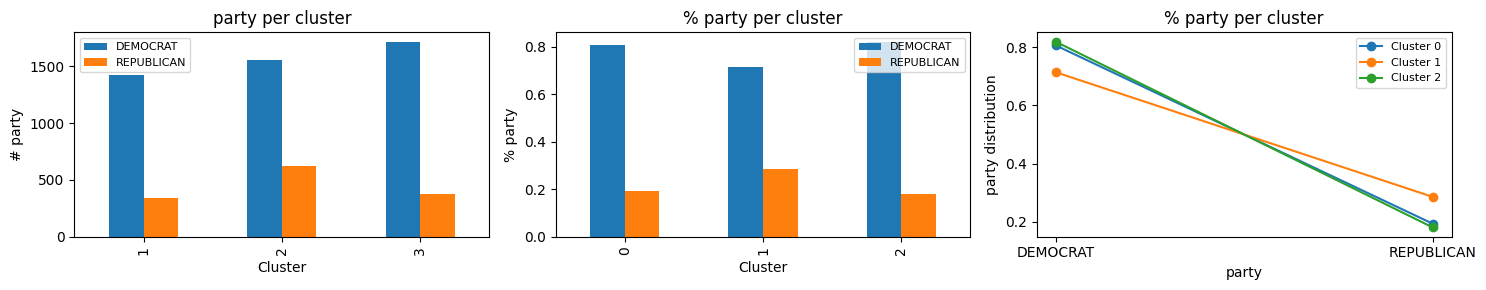

Augmented Model


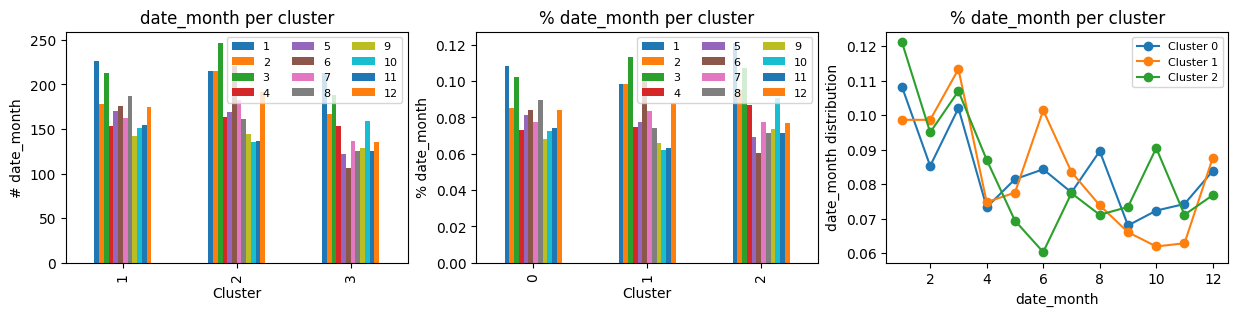

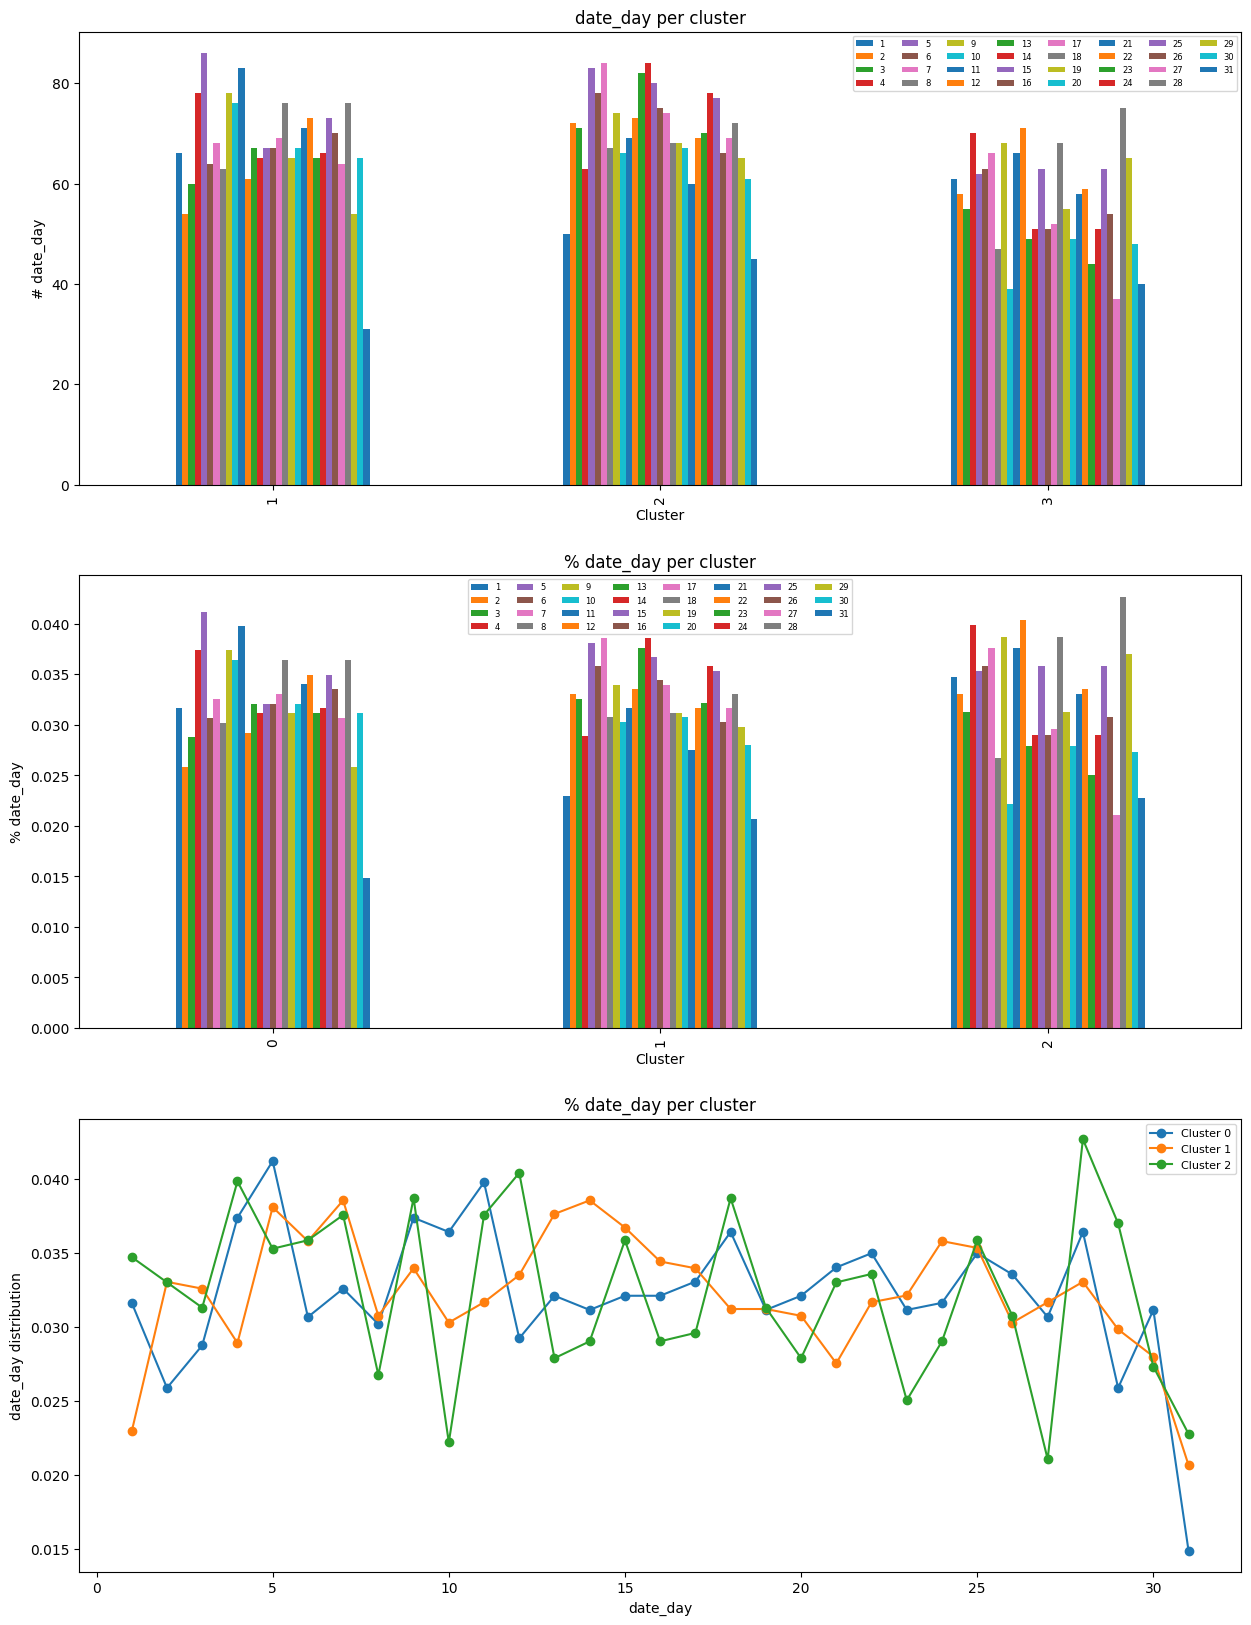

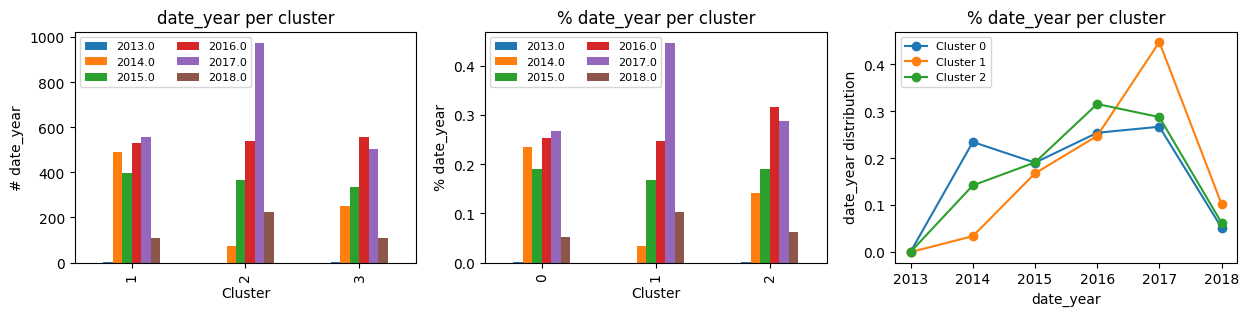

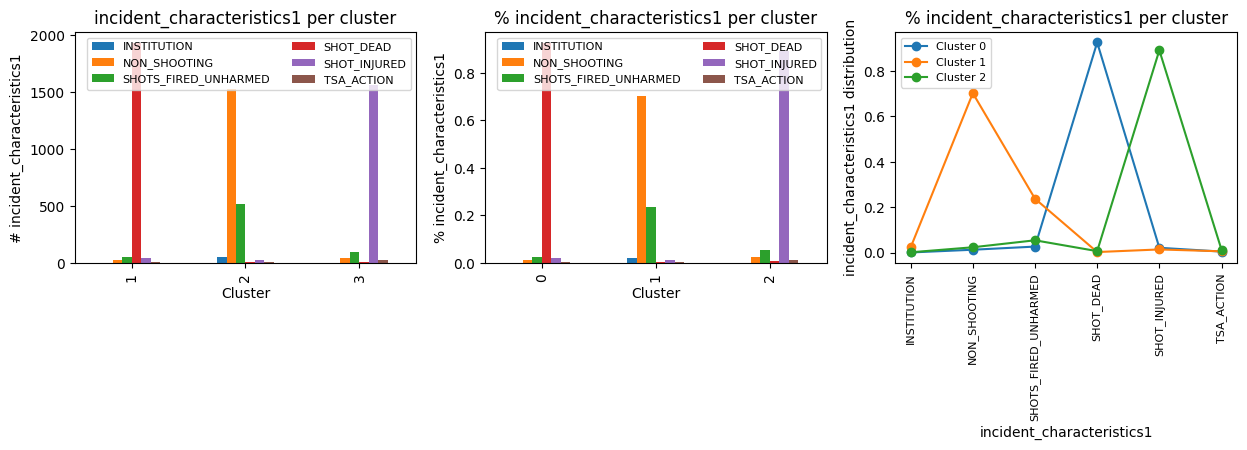

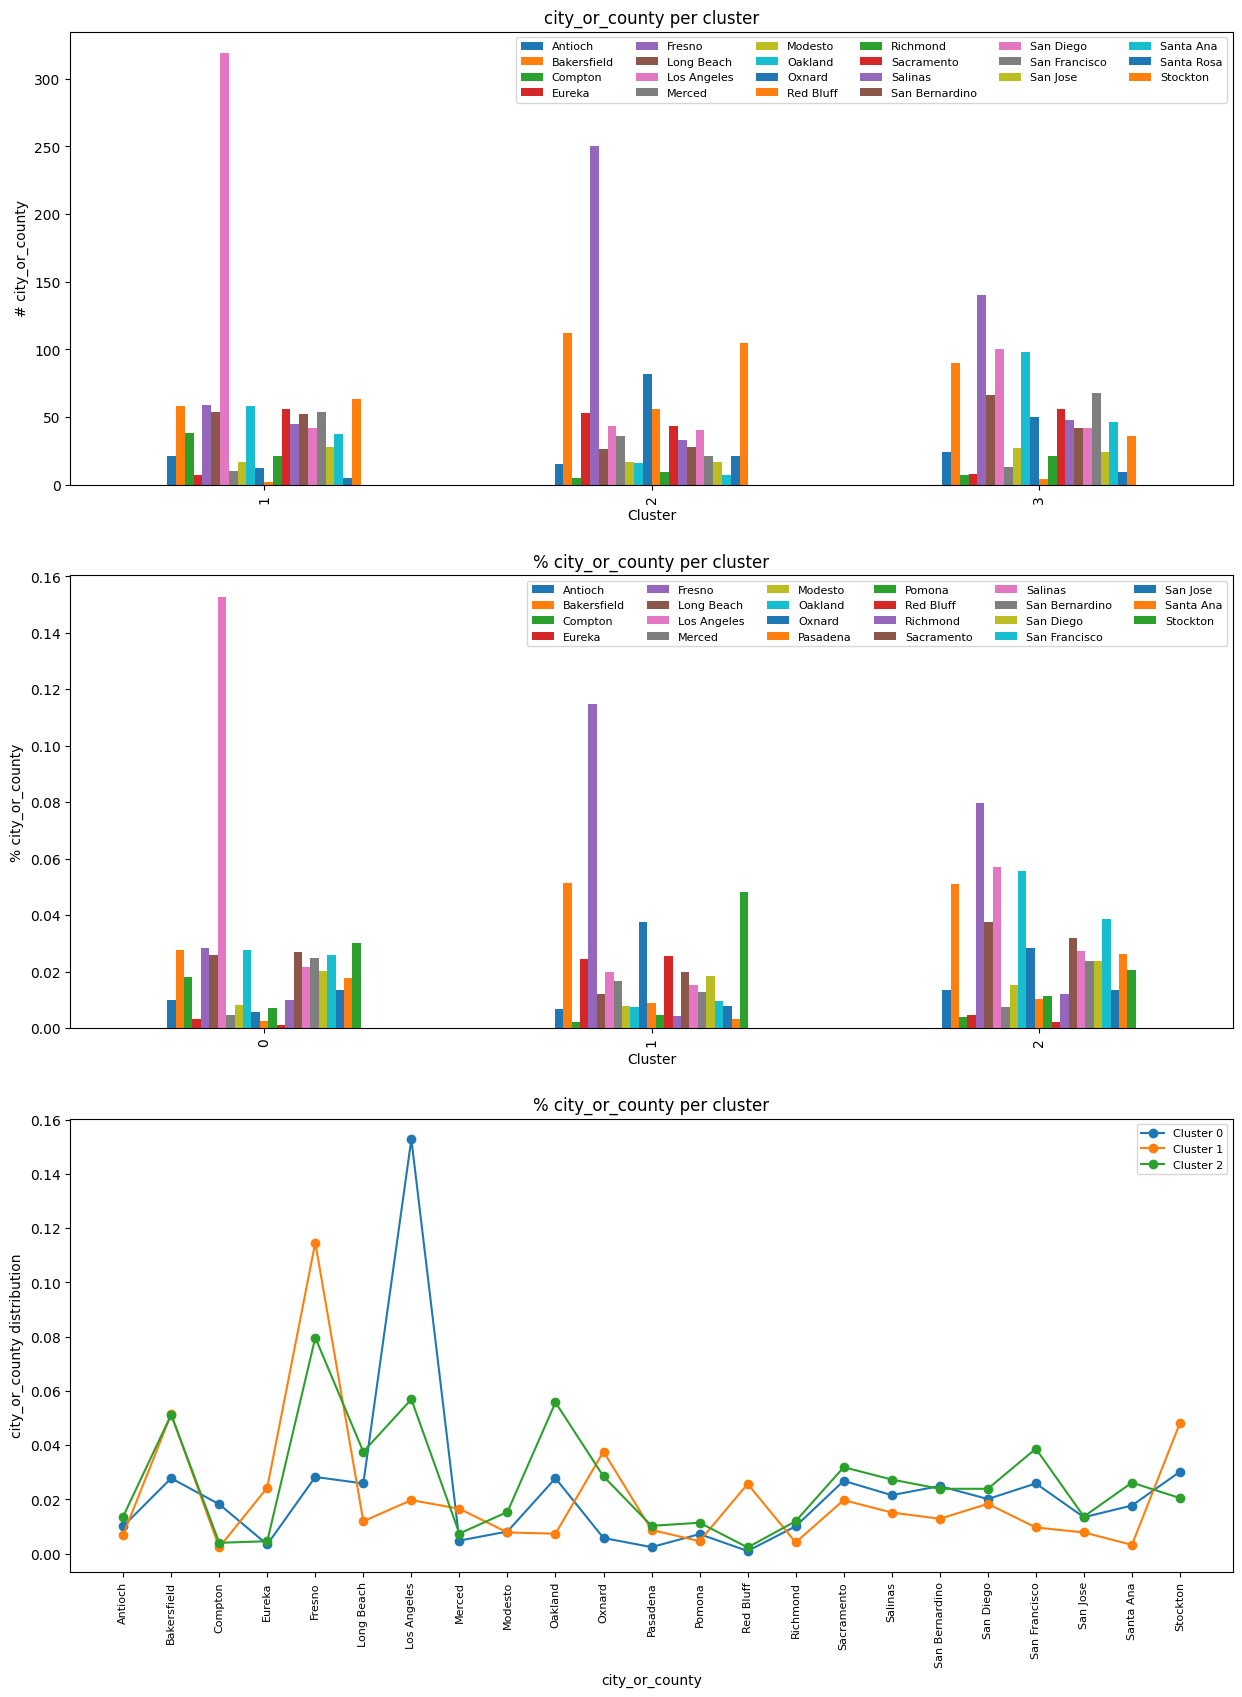

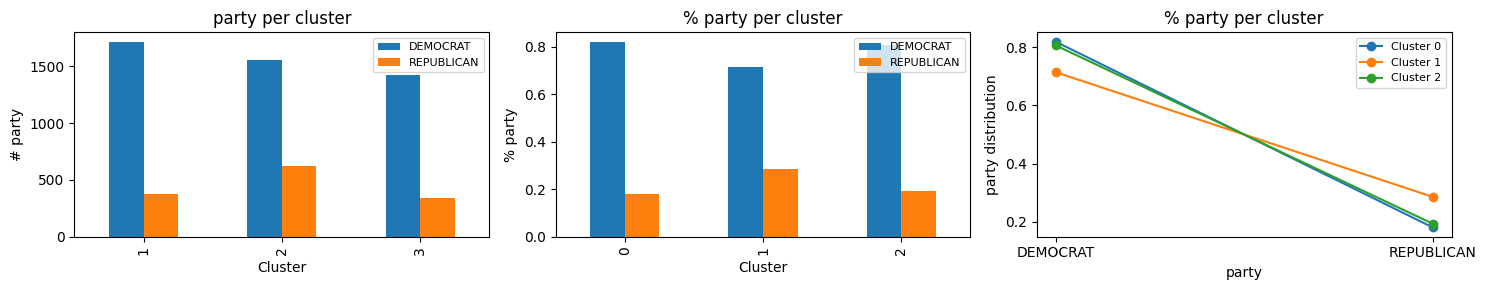

Indicators Model


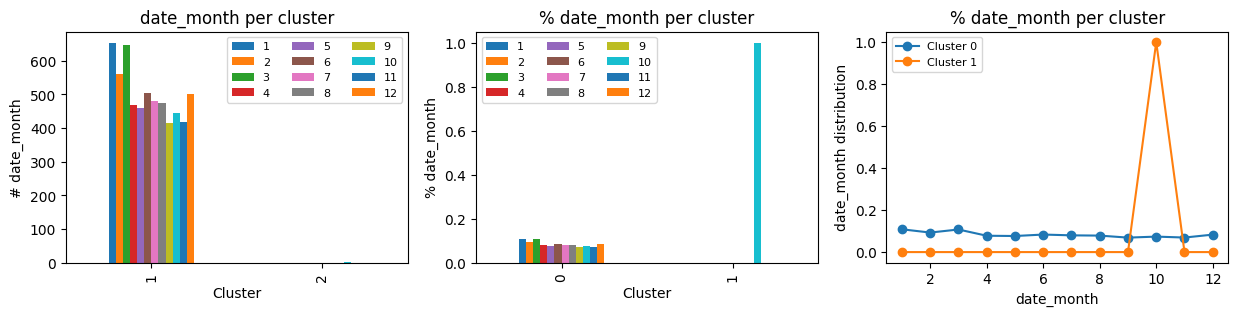

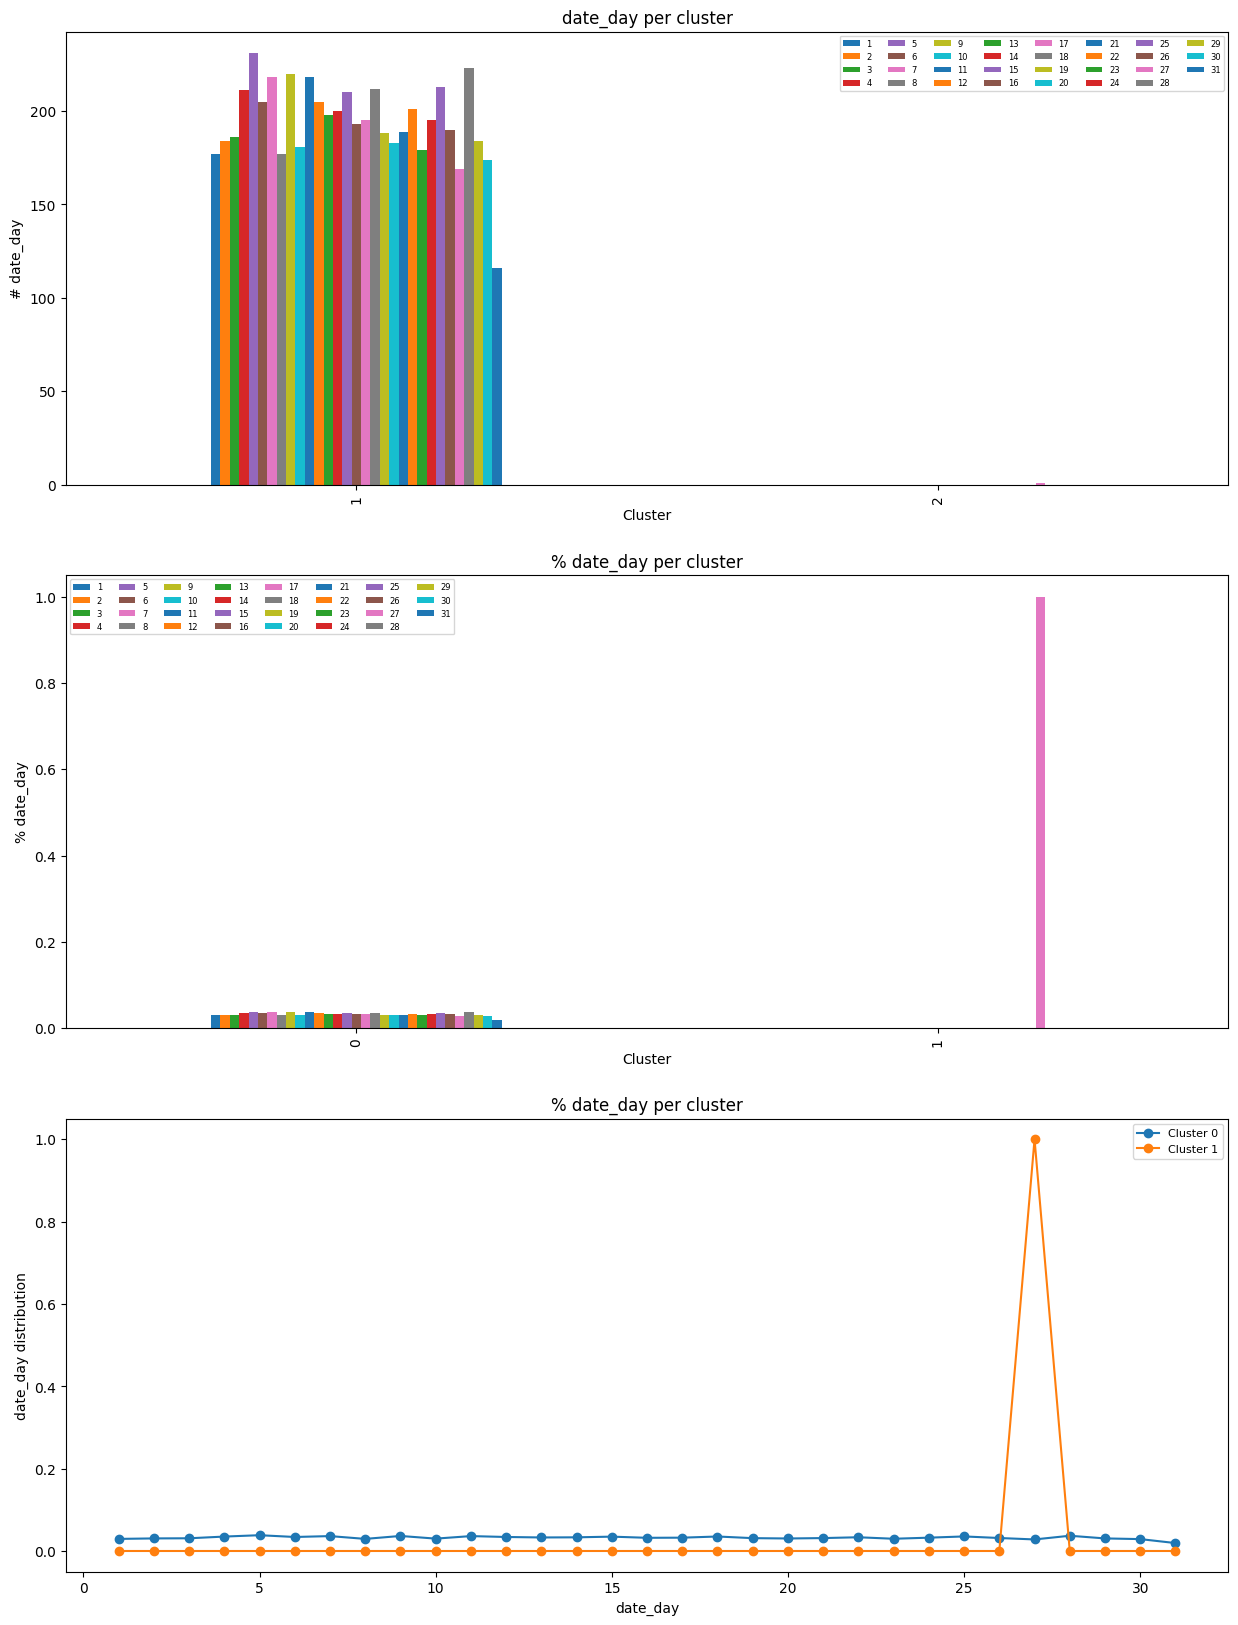

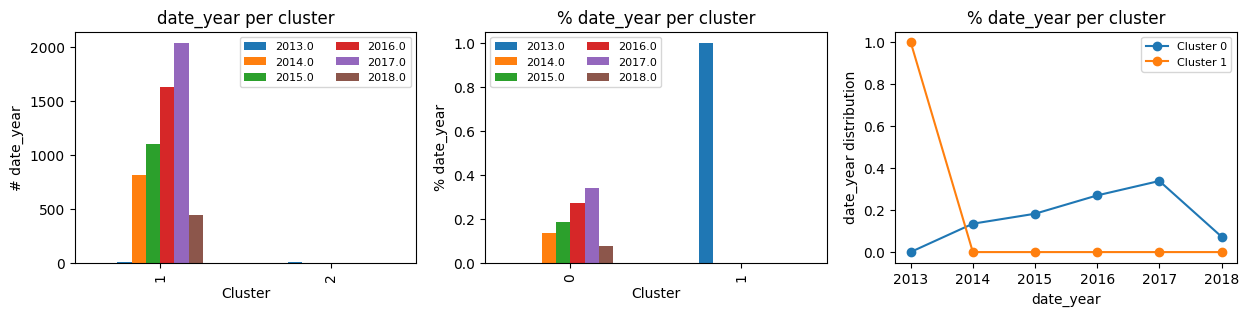

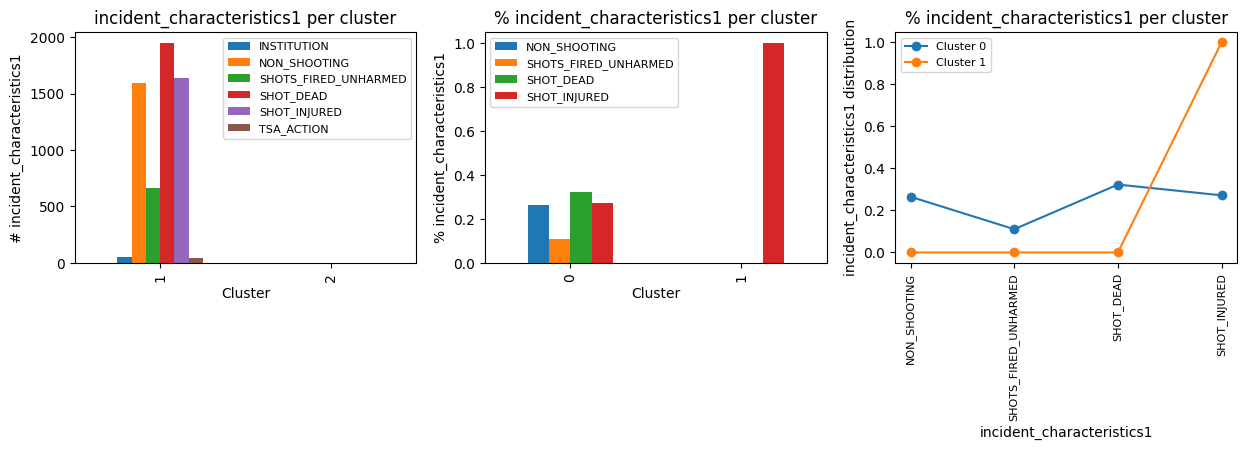

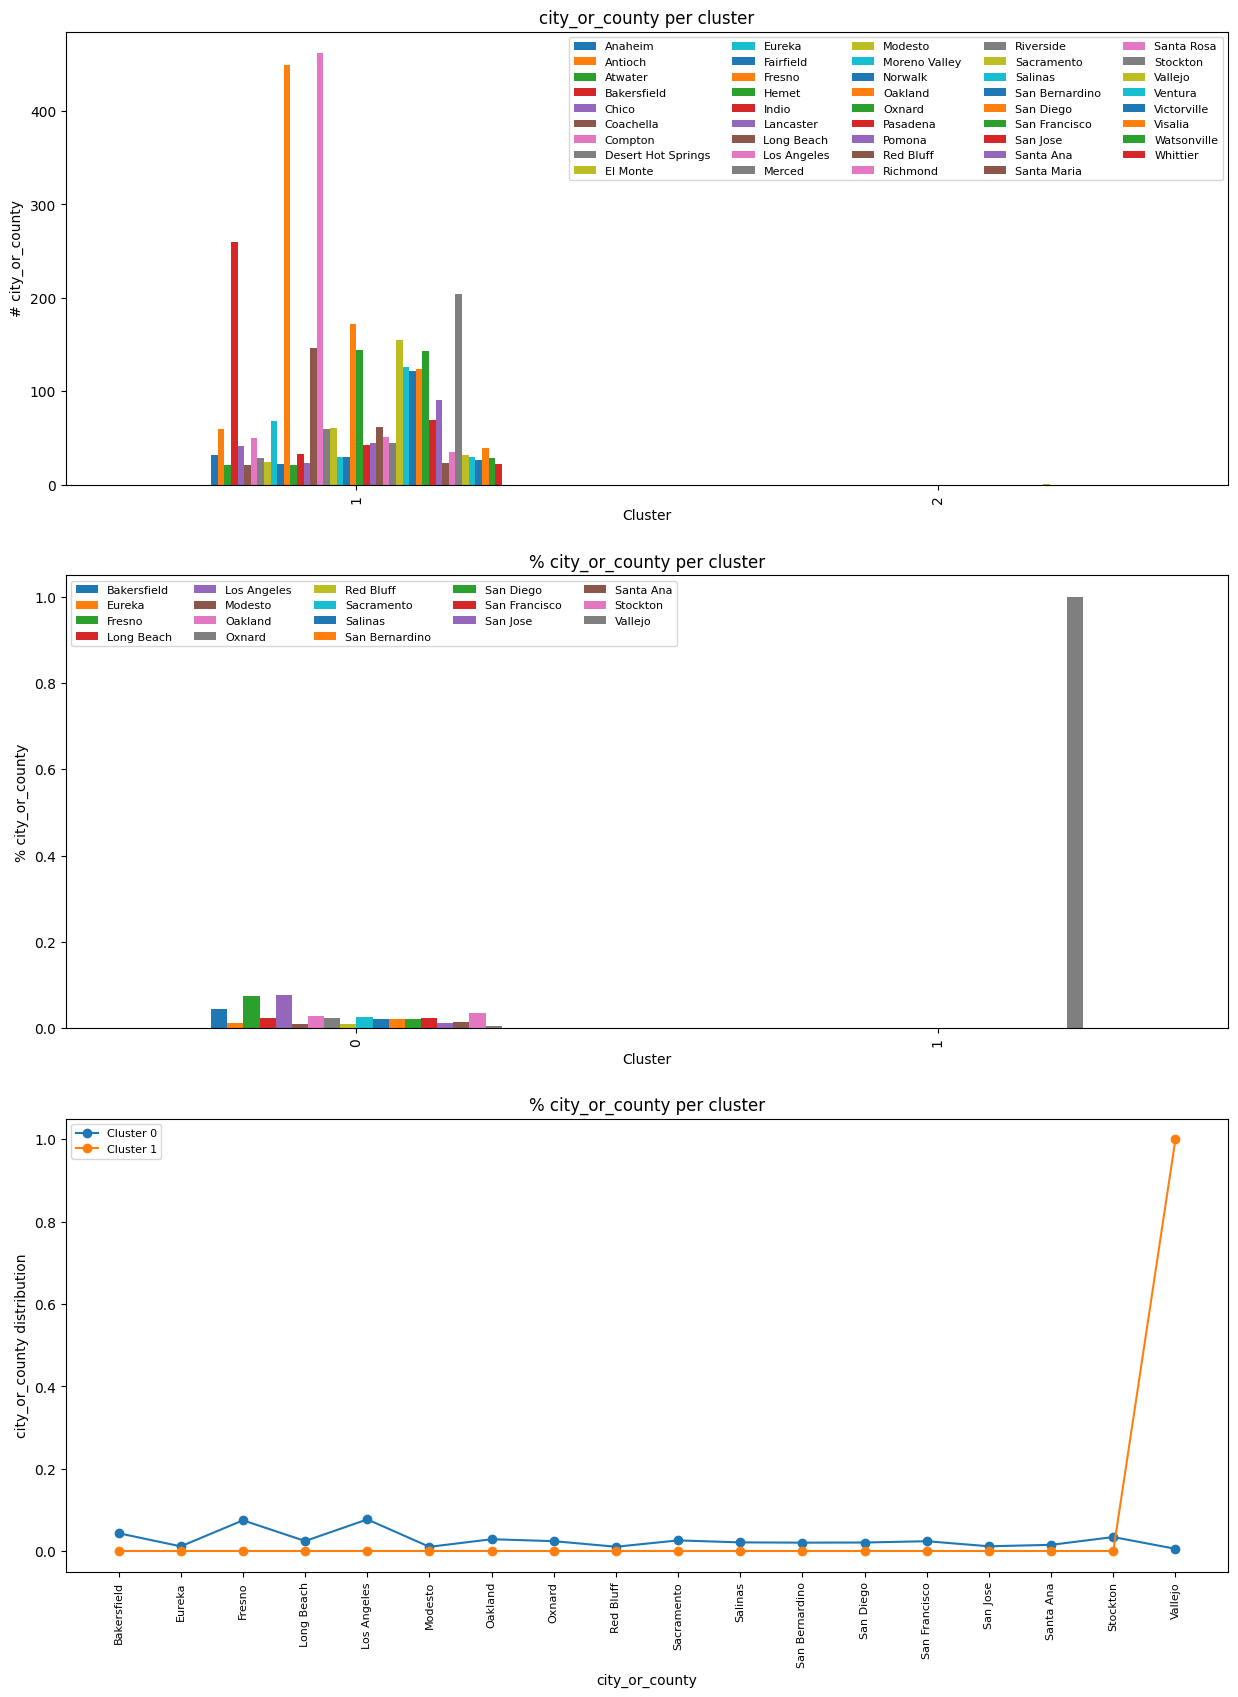

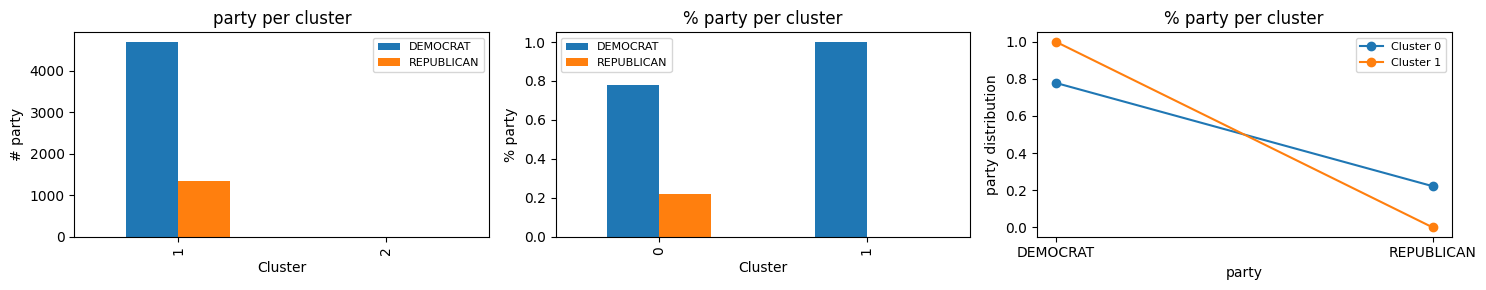

Original Reduced Model


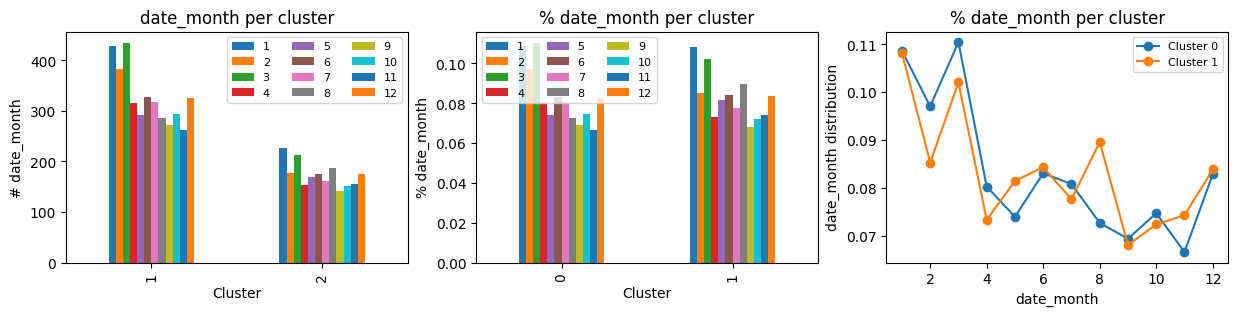

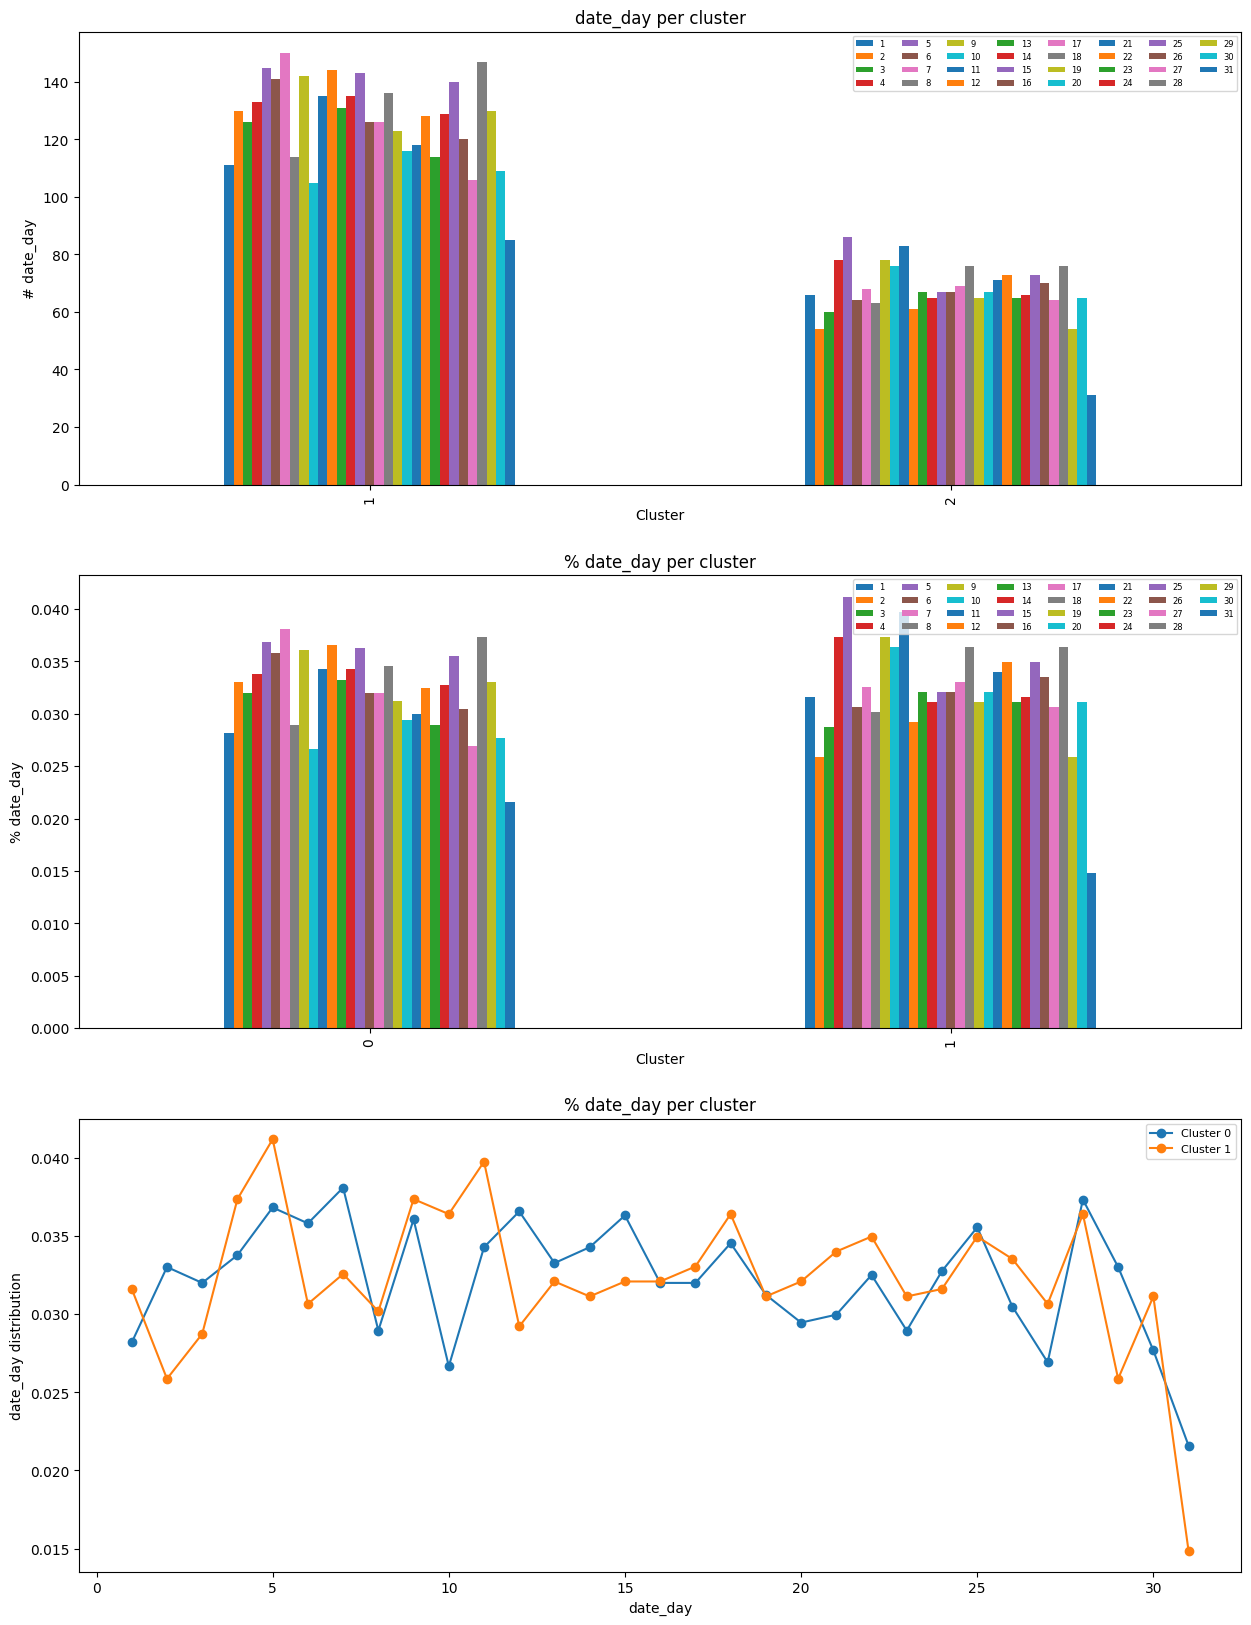

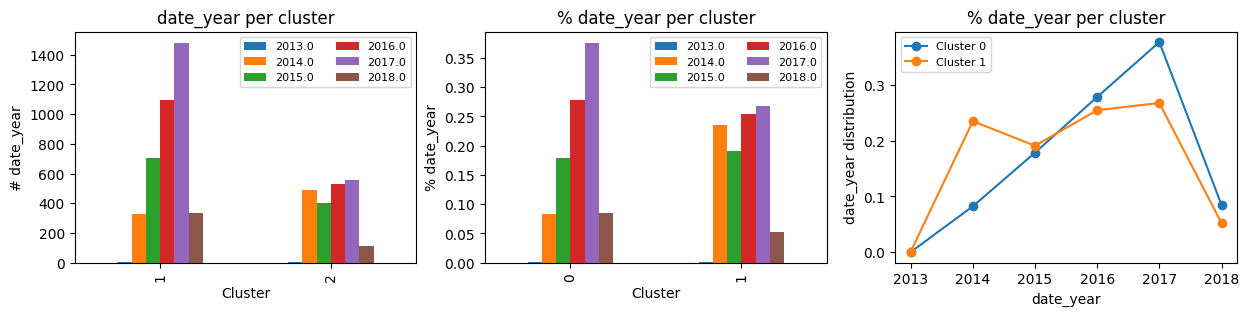

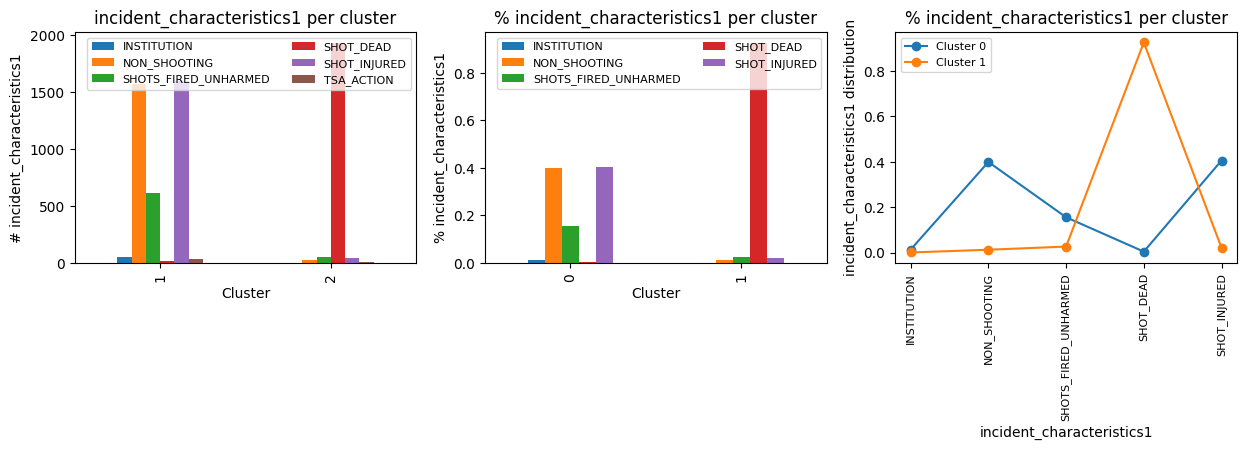

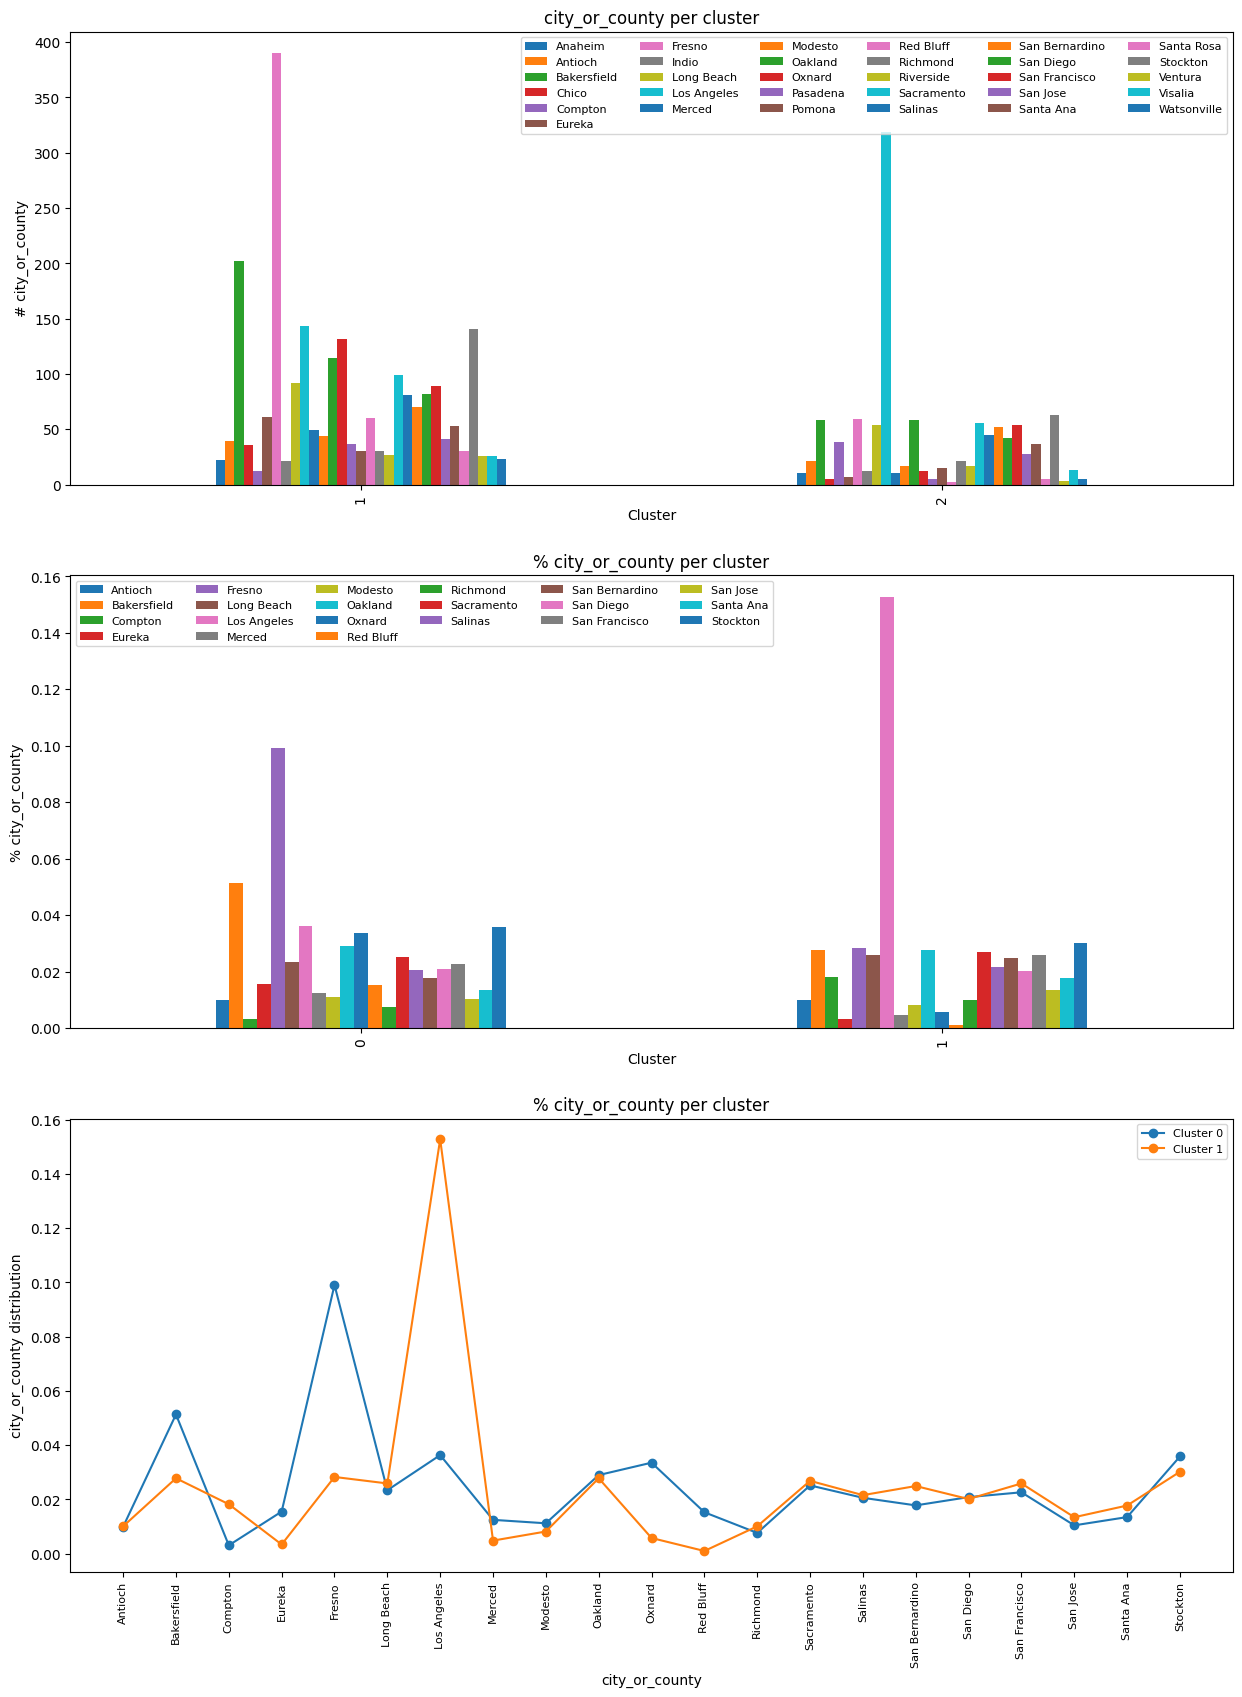

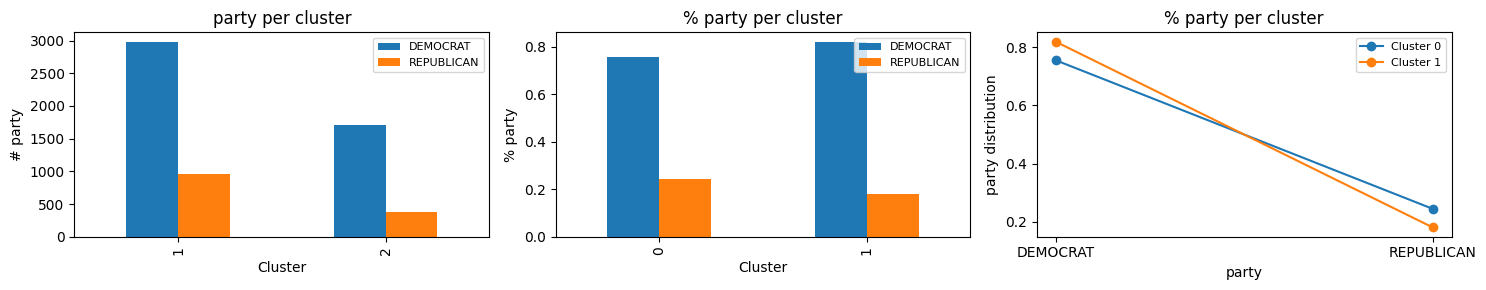

Augmented Reduced Model


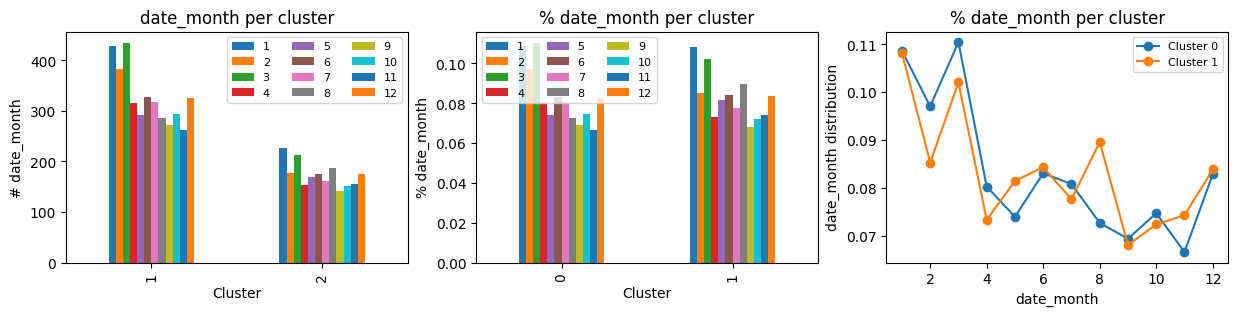

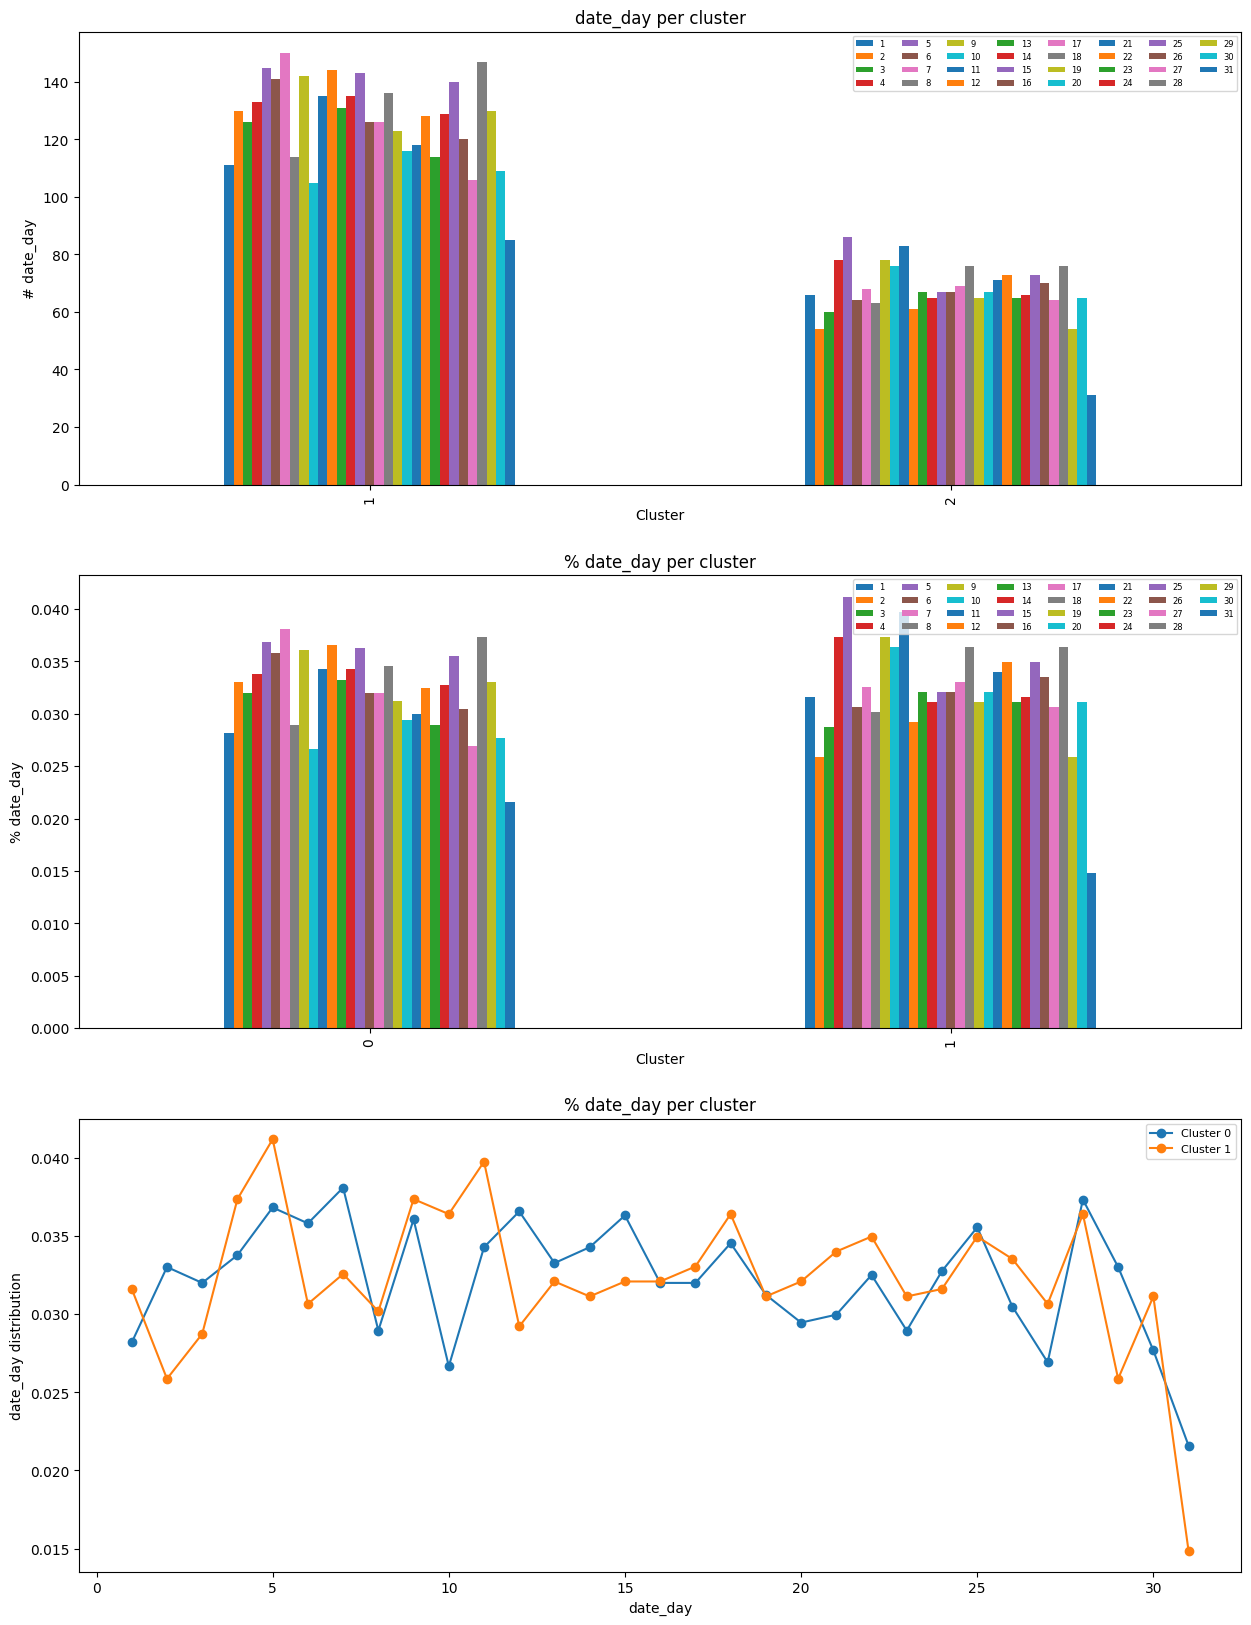

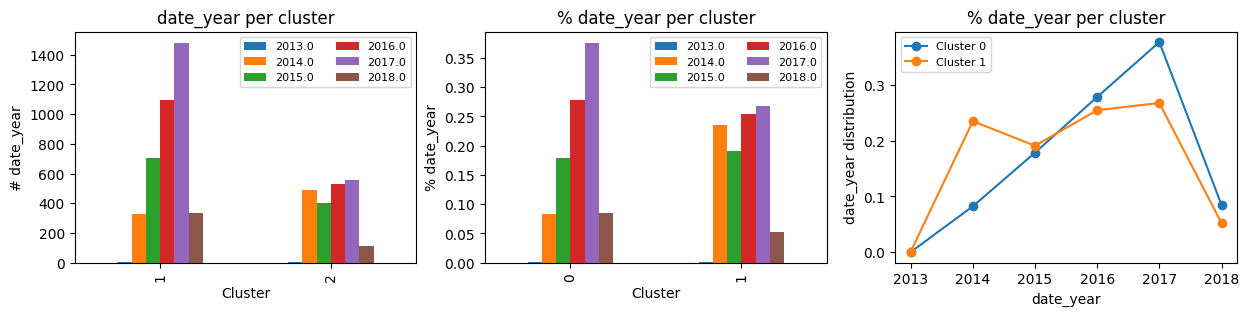

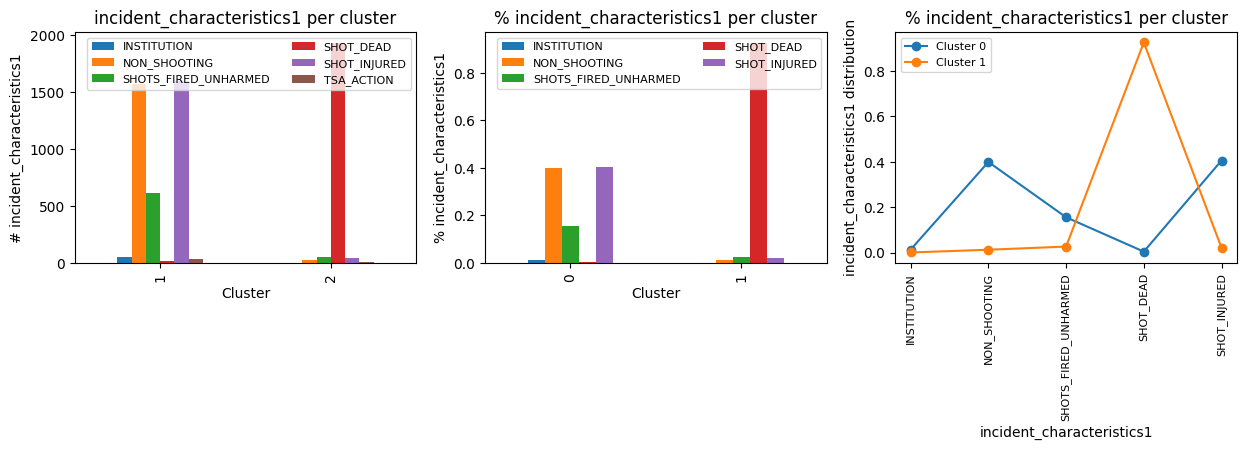

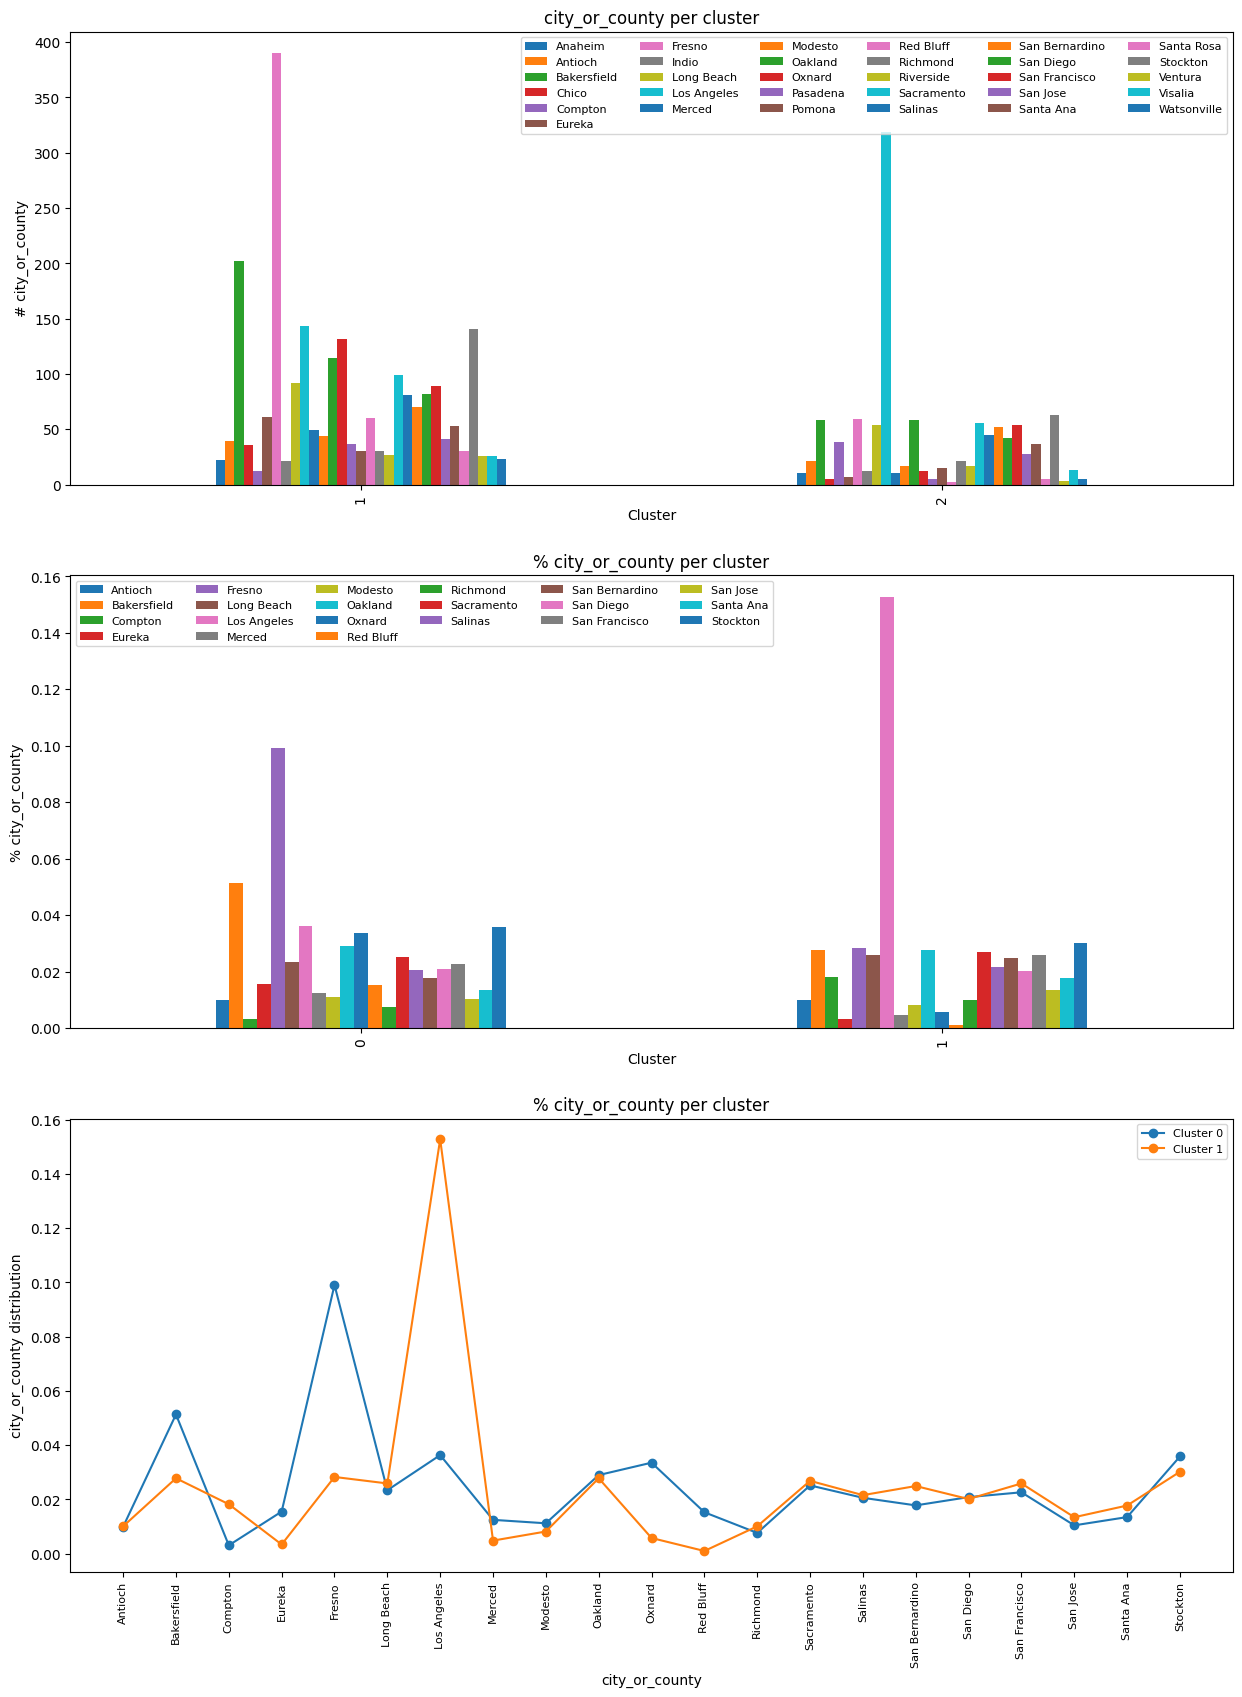

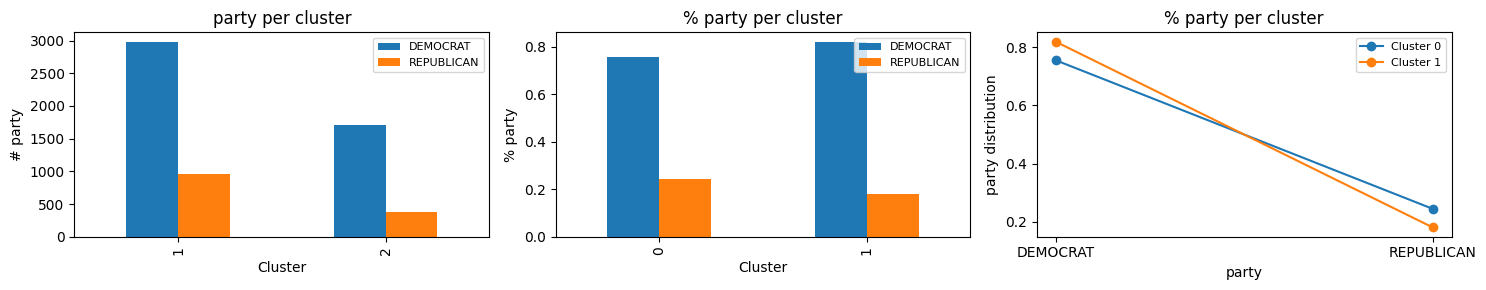

Indicators Reduced Model


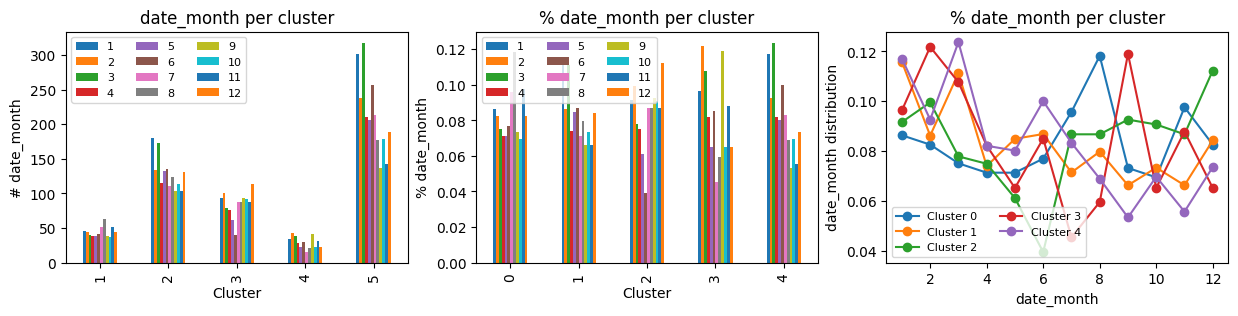

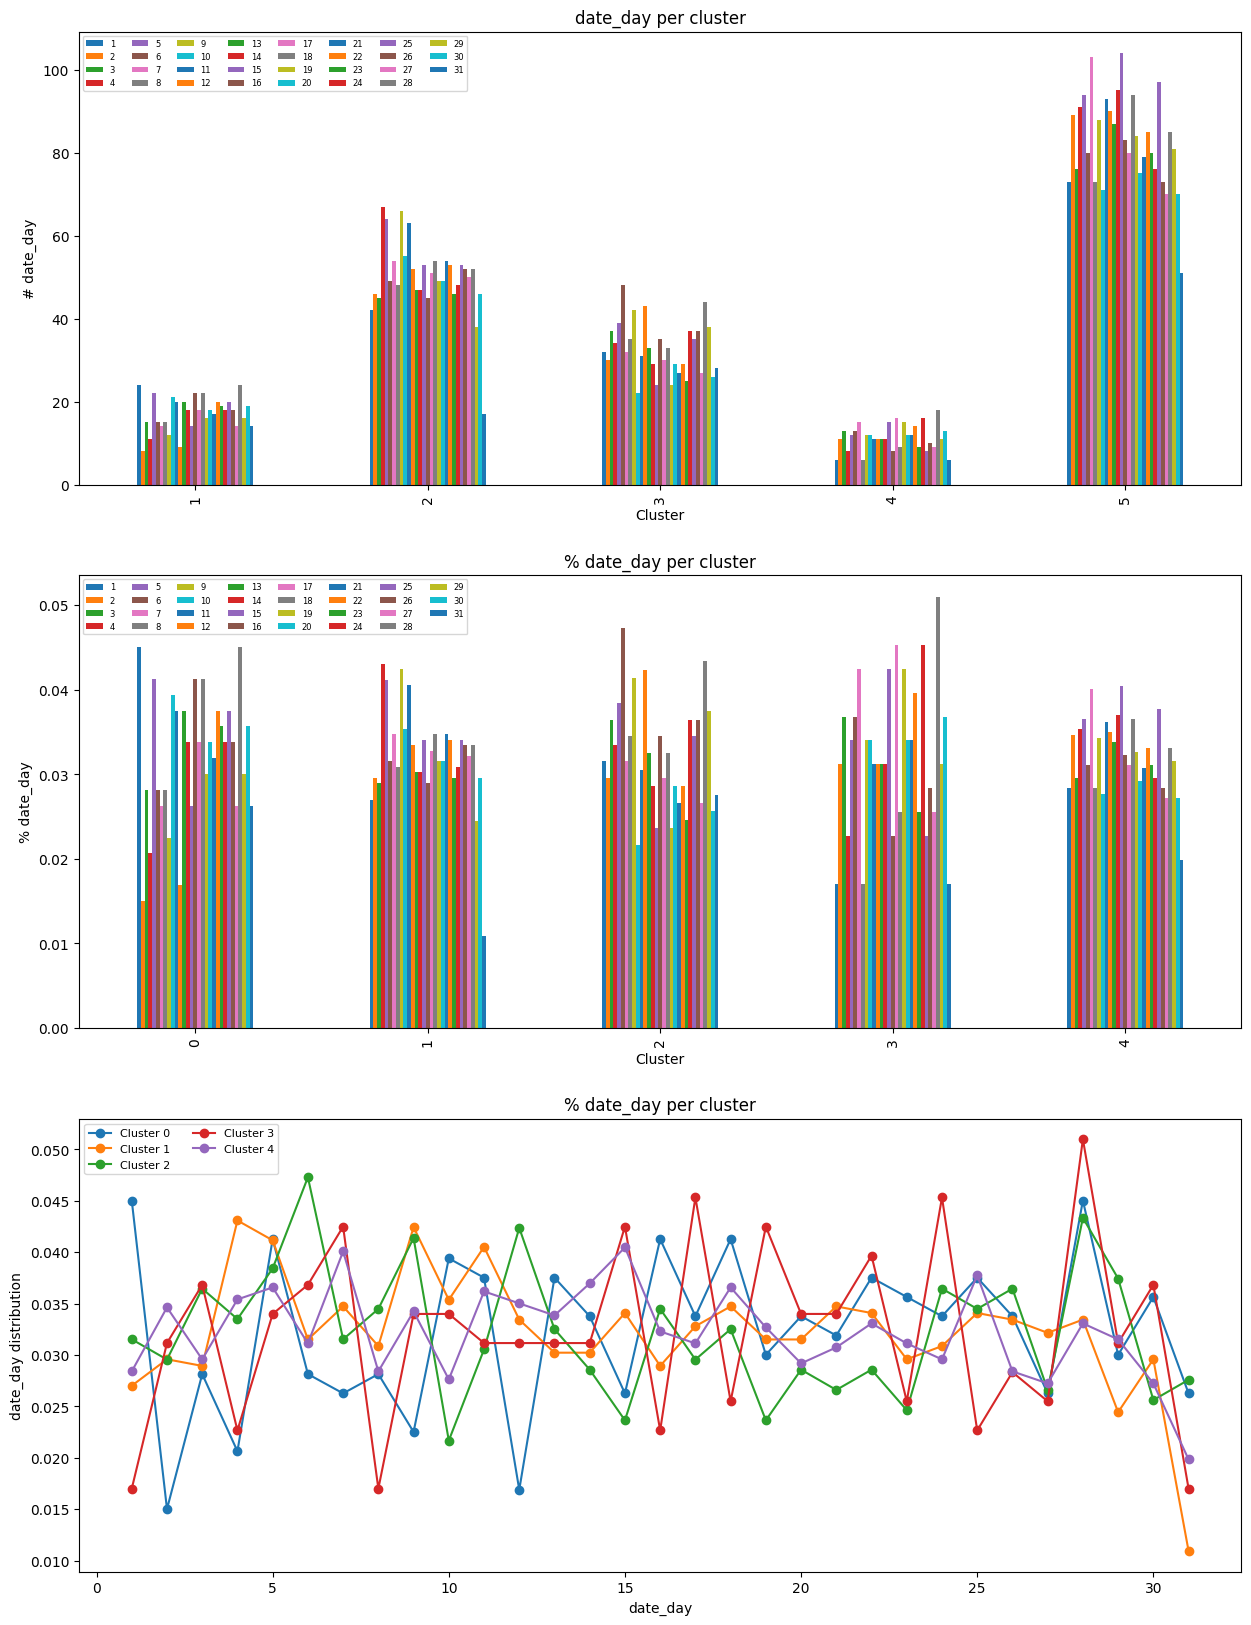

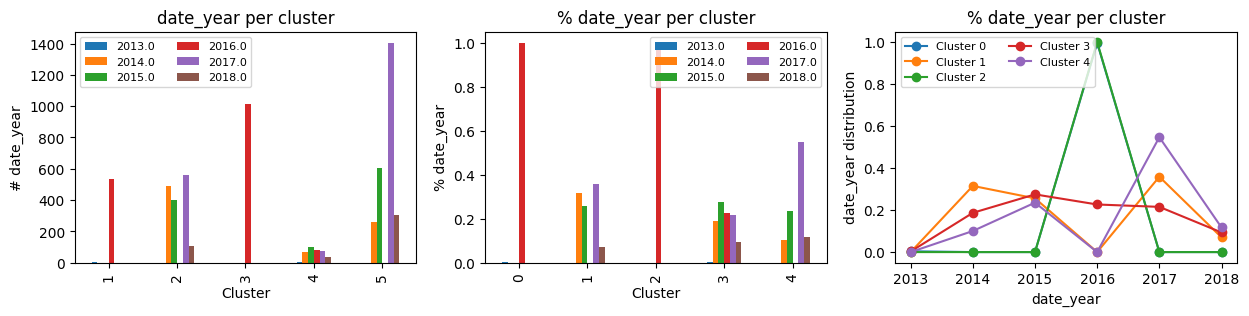

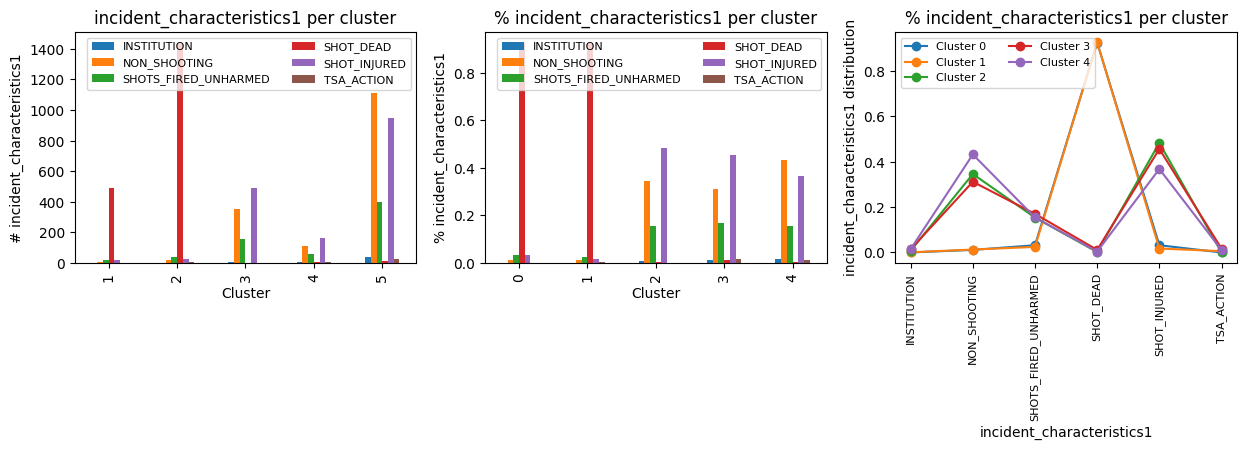

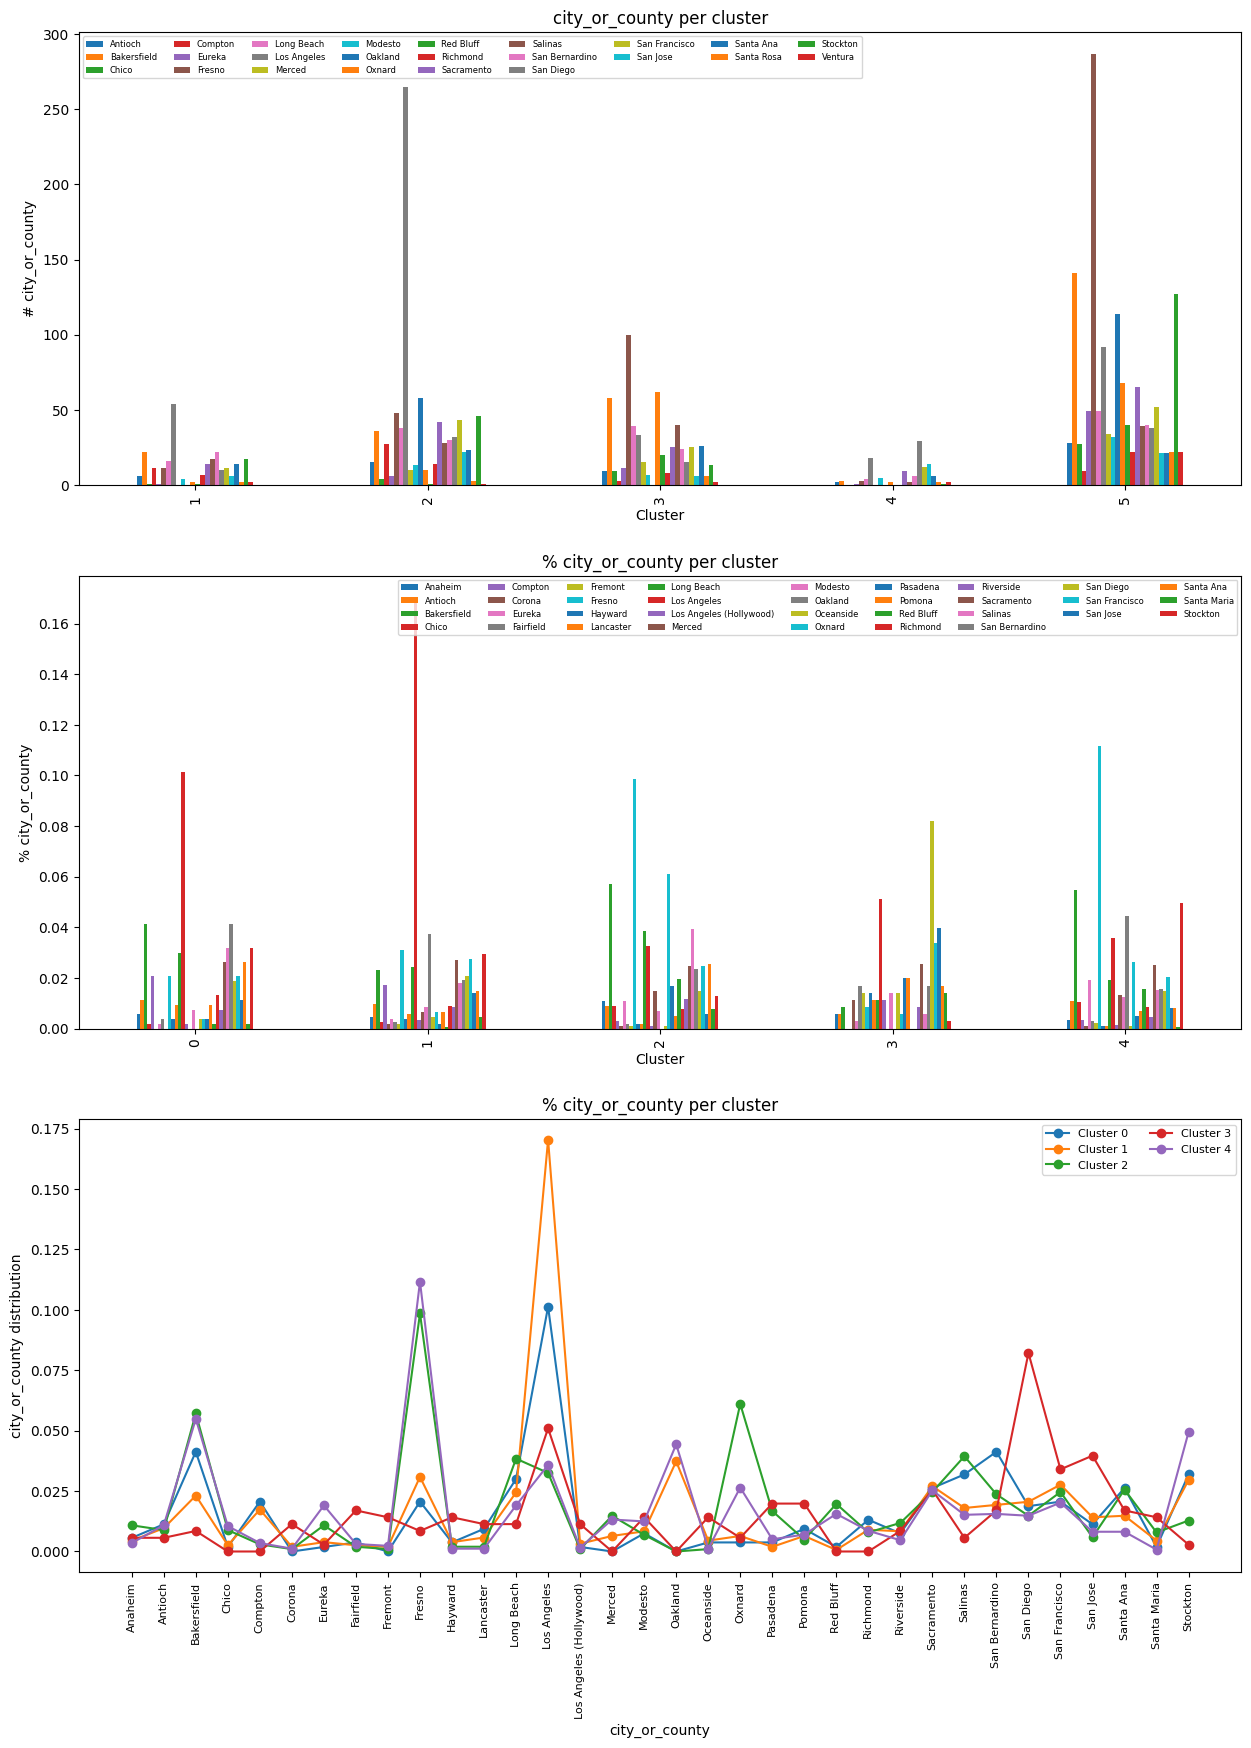

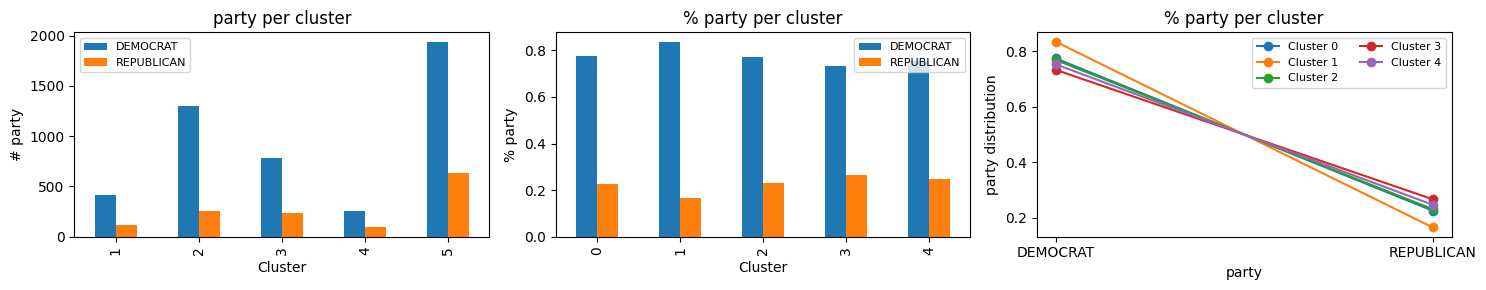

In [76]:
# categorical attributes distribution inside clusters

categoricals = ['date_month', 'date_day', 'date_year', 'incident_characteristics1', 'city_or_county', 'party']
df_c = df_init[categoricals]

for model, model_name, means in zip(best_models2.values(), model_names[0:6], true_meanss):
    print(model_name)
    labels = model['labels'][np.argmax(model['silhouette'])]
    for cat in categoricals:

        xt_pct = pd.crosstab(labels, df_c[cat])
        if cat == 'city_or_county':
            xt_pct = xt_pct.loc[:, (xt_pct > 0).any(axis=0)]

        a = xt_pct.values
        cols = xt_pct.columns
        ps = []
        for i in range(len(cols)):
            ps.append([])

        for row in a:
            dist = row / np.sum(row)
            for i in range(len(cols)):
                ps[i].append(dist[i])

        d = {}
        i = 0
        for c in cols:
            d[c] = ps[i]
            i += 1

        xt_pct_p = pd.DataFrame(d)
        if cat == 'city_or_county' or cat == 'incident_characteristics1':
            xt_pct_p = xt_pct_p.loc[:, (xt_pct_p > 0.01).any(axis=0)]
            xt_pct = xt_pct.loc[:, (xt_pct > 20).any(axis=0)]

        distrs = xt_pct_p.values
        cols = xt_pct_p.columns
        avg_distr = np.mean(distrs, axis=0)
        
    #----------------------------------------------
        if (cat == 'party' or cat == 'date_month' or cat == 'date_year' or cat == 'incident_characteristics1') and (len(means) <= 6):
            fig, axes = plt.subplots(1, 3, figsize=(15, 3))
        else:
            fig, axes = plt.subplots(3, 1, figsize=(15, 20))

        if len(cols) > 30:
            fs = 6
        else:
            fs = 8

        if cat == 'incident_characteristics1':
            ncol = ceil(len(cols) / 4)#6
        else:
            ncol = ceil(len(cols) / 4)

        xt_pct.plot(kind='bar', stacked=False, title=f'{cat} per cluster', ax=axes[0])
            
        axes[0].legend(fontsize=fs, loc='best', ncol=ncol)
        axes[0].set_xlabel('Cluster')
        axes[0].set_ylabel(f'# {cat}')

        xt_pct_p.plot(kind='bar', stacked=False, title=f'% {cat} per cluster', ax=axes[1])
        axes[1].legend(fontsize=fs, loc='best', ncol=ncol)
        axes[1].set_xlabel('Cluster')
        axes[1].set_ylabel(f'% {cat}')

        for i in range(len(means)):
            line, = axes[2].plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')
            if cat == 'incident_characteristics1' or cat == 'city_or_county':
                axes[2].set_xticks(range(len(cols)), cols, rotation=90, fontsize=8)

        ncol = ceil(len(means) / 4)
        axes[2].legend(fontsize=8, loc='best', ncol=ncol)
        axes[2].set_xlabel(cat)
        axes[2].set_ylabel(f'{cat} distribution')
        axes[2].set_title(f'% {cat} per cluster')
    
    plt.tight_layout()
    plt.show()